<a href="https://colab.research.google.com/github/zxymargaret/ROSAS/blob/master/2025_Model_Preliminary_Build_ROSAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data smoothing using Kalman Filter (x,y,delta_t)

Process Raw Unity Data (x, y, delta_t)

In [1]:
import os
import numpy as np
import pandas as pd
import re
from glob import glob

In [7]:
import matplotlib.pyplot as plt
# Math library
from itertools import accumulate

In [3]:
# Raw .csv file paths from Unity Export, put them in a list of strings
# Adapted from 2024 Visualizer
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File paths
raw_file_paths = ['/content/drive/My Drive/2025Fall/Thesis/Savoye_Drawings/Savoye_Heirarchy_GazeCoordinates.txt']  # Update this path

# Define Kalman Filter

In [5]:
# ---------- Kalman with fixed dt (constant-velocity, NaN-tolerant) ----------
def kalman_smooth_xy_constdt(x, y, dt,
                             accel_var=30.0, meas_var=4.0,
                             gate_mahalanobis_sq=16.0):
    """
    Kalman smoothing for equally spaced samples (fixed dt).
    x, y: 1D arrays (NaNs allowed to represent missing samples)
    dt:   fixed time step in seconds (e.g., 1/120 for 120 Hz)
    Returns (x_smooth, y_smooth)
    """
    x_meas = np.asarray(x, dtype=float)
    y_meas = np.asarray(y, dtype=float)
    N = len(x_meas)
    if N == 0:
        return x_meas.copy(), y_meas.copy()

    H = np.array([[1,0,0,0],
                  [0,1,0,0]], dtype=float)
    R = np.eye(2) * float(meas_var)

    # Pre-build F and Q for this dt (fixed)
    F = np.array([[1,0,dt,0],
                  [0,1,0,dt],
                  [0,0,1, 0],
                  [0,0,0, 1]], dtype=float)
    dt2, dt3, dt4 = dt*dt, dt*dt*dt, (dt*dt)*(dt*dt)
    q1 = dt4*0.25*accel_var
    q2 = dt3*0.5*accel_var
    q3 = dt2*accel_var
    Q = np.array([[q1, 0,  q2, 0],
                  [0,  q1, 0,  q2],
                  [q2, 0,  q3, 0],
                  [0,  q2, 0,  q3]], dtype=float)

    # Initialize from first valid sample
    valid0 = np.where(~np.isnan(x_meas) & ~np.isnan(y_meas))[0]
    if len(valid0) == 0:
        return x_meas.copy(), y_meas.copy()
    k0 = valid0[0]
    x_state = np.array([x_meas[k0], y_meas[k0], 0.0, 0.0], dtype=float)
    P = np.diag([meas_var, meas_var, 1e3, 1e3])

    xs = np.empty(N); ys = np.empty(N)

    for k in range(N):
        # Predict
        x_state = F @ x_state
        P = F @ P @ F.T + Q

        # Update if valid measurement
        if not (np.isnan(x_meas[k]) or np.isnan(y_meas[k])):
            z = np.array([x_meas[k], y_meas[k]])
            y_res = z - (H @ x_state)
            S = H @ P @ H.T + R

            # Gating (optional)
            try:
                Sinv = np.linalg.inv(S)
            except np.linalg.LinAlgError:
                Sinv = np.linalg.pinv(S)

            if gate_mahalanobis_sq is None:
                accept = True
            else:
                m2 = float(y_res.T @ Sinv @ y_res)
                accept = (m2 <= gate_mahalanobis_sq)

            if accept:
                K = P @ H.T @ Sinv
                x_state = x_state + (K @ y_res)
                P = (np.eye(4) - K @ H) @ P

        xs[k], ys[k] = x_state[0], x_state[1]

    return xs, ys

# Optional Ema Smooth
def ema_smooth(x, alpha=0.25):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    prev = np.nan
    for i, v in enumerate(x):
        if np.isnan(v):
            out[i] = prev
        else:
            prev = v if np.isnan(prev) else (alpha*v + (1-alpha)*prev)
            out[i] = prev
    return out

In [6]:
# Adapted from ROSA 2025
def group_data_process(raw_file_paths,
                       save_dir="/content/temp_gaze_paths/",
                       image_dir="/content/stimuli_image/",
                       smooth_filter = "Kalman",
                       kalman_params=None,
                       ema_alpha=0.25,
                       dt_const=None,
                       sample_rate_hz=None):
    """
    Processes multiple CSV files containing gaze tracking data, groups entries based on "Iteration",
    and stores each group's data in a temporary directory with unique CSV filenames.
    Also generates corresponding image paths and category labels.

    Args:
        file_paths (list of str): List of CSV file paths.
        save_dir (str): Directory to store processed CSV files.
        image_dir (str): Directory where images are stored (image paths are generated, but not saved).
        smooth_filter (str|None): "Kalman", "EMA", or None
        kalman_params (dict): e.g., {"accel_var":30.0, "meas_var":9.0, "gate_mahalanobis_sq":16.0}

    Returns:
        tuple:
            - List of CSV file paths
            - List of corresponding image paths (generated but not saved)
            - List of category labels (first word of CSV name, without numbers)
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(image_dir, exist_ok=True)

    if kalman_params is None:
        kalman_params = {"accel_var": 30.0, "meas_var": 9.0, "gate_mahalanobis_sq": 16.0}

    # Resolve dt if a constant was provided
    if dt_const is None and sample_rate_hz is not None:
        dt_const = 1.0 / float(sample_rate_hz)

    csv_file_paths, image_file_paths, category_labels = [], [], []

    for raw_file_path in raw_file_paths:
        csv_name = os.path.splitext(os.path.basename(raw_file_path))[0]
        category_name = re.sub(r'\d+', '', csv_name.split('_')[0])

        with open(raw_file_path, "r", encoding="utf-8", errors="ignore") as f:
            data = f.read()

        groups = data.strip().split("Iteration")

        for group_idx, group in enumerate(groups):
            text = group.strip()
            if not text:
                continue

            rows = []
            for line in text.splitlines():
                line = line.strip()
                if not line:
                    continue
                # Try comma; then whitespace
                parsed = None
                parts = [p.strip() for p in line.split(",")]
                if len(parts) >= 2:
                    try:
                        x, y = float(parts[0]), float(parts[1])
                        t = float(parts[2]) if len(parts) >= 3 else np.nan
                        parsed = (x, y, t)
                    except Exception:
                        parsed = None
                if parsed is None:
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            x, y = float(parts[0]), float(parts[1])
                            t = float(parts[2]) if len(parts) >= 3 else np.nan
                            parsed = (x, y, t)
                        except Exception:
                            pass
                if parsed is not None:
                    rows.append(parsed)

            if len(rows) == 0:
                continue

            df = pd.DataFrame(rows, columns=["x", "y", "t"])

            # Decide smoothing mode
            have_t = not df["t"].isna().all()
            use_fixed_dt = (dt_const is not None) or (not have_t)

            # If no dt_const provided but timestamps exist, try to infer const dt for stability
            if use_fixed_dt and dt_const is None and have_t:
                diffs = np.diff(df["t"].to_numpy(dtype=float))
                dt_const = float(np.median(diffs[diffs > 0])) if diffs.size else 1e-3
                # Guard against zeros
                if dt_const <= 0:
                    dt_const = 1e-3

            # Apply smoothing
            if smooth_filter is None or str(smooth_filter).lower() in ("none", "false", "no"):
                df["x_smooth"] = df["x"]; df["y_smooth"] = df["y"]

            elif str(smooth_filter).lower() == "ema":
                df["x_smooth"] = ema_smooth(df["x"].to_numpy(), alpha=float(ema_alpha))
                df["y_smooth"] = ema_smooth(df["y"].to_numpy(), alpha=float(ema_alpha))

            elif str(smooth_filter).lower() == "kalman":
                if use_fixed_dt:
                    xs, ys = kalman_smooth_xy_constdt(
                        df["x"].to_numpy(), df["y"].to_numpy(),
                        dt=float(dt_const),
                        accel_var=float(kalman_params.get("accel_var", 30.0)),
                        meas_var=float(kalman_params.get("meas_var", 9.0)),
                        gate_mahalanobis_sq=kalman_params.get("gate_mahalanobis_sq", 16.0),
                    )
                else:
                    # Fallback: variable-dt
                    xs, ys = _kalman_var_dt(
                        t=df["t"].to_numpy(),
                        x=df["x"].to_numpy(),
                        y=df["y"].to_numpy(),
                        accel_var=float(kalman_params.get("accel_var", 30.0)),
                        meas_var=float(kalman_params.get("meas_var", 9.0)),
                        gate_mahalanobis_sq=kalman_params.get("gate_mahalanobis_sq", 16.0),
                    )
                df["x_smooth"] = xs; df["y_smooth"] = ys
            else:
                raise ValueError(f"Unknown smooth_filter: {smooth_filter}")

            # Save grouped CSV
            csv_save_path = os.path.join(save_dir, f"{csv_name}_group{group_idx}.csv")
            df.to_csv(csv_save_path, index=False)

            # Generate image path placeholder
            image_path = os.path.join(image_dir, f"Group{group_idx}.jpg")

            csv_file_paths.append(csv_save_path)
            image_file_paths.append(image_path)
            category_labels.append(category_name)

    return csv_file_paths, image_file_paths, category_labels


## Unused Test Functions

In [ ]:
# Run off-line filter and make individual eye-tracking session output under folder ""temp_gaze_paths"
csvs, imgs, labels = group_data_process(
    raw_file_paths,
    save_dir="/content/temp_gaze_paths/",
    image_dir="/content/stimuli_image_folder/",
    smooth_filter="Kalman",
    kalman_params={
        "accel_var": 0.02,          # smoother ↗ if you increase (e.g., 0.2–0.5)
        "meas_var": 1e-5,        # if jittery, try 1e-4; if very clean, 1e-5
        "gate_mahalanobis_sq": None  # set None to disable gating
    },
    sample_rate_hz=60.0           # fixed 60 Hz (dt = 1/60)
)

In [ ]:
!zip -r /content/temp_gaze_paths.zip /content/temp_gaze_paths

  adding: content/temp_gaze_paths/ (stored 0%)
  adding: content/temp_gaze_paths/Oct18_match_group11.csv (deflated 64%)
  adding: content/temp_gaze_paths/Savoye_Shape_GazeCoordinates_group4.csv (deflated 64%)
  adding: content/temp_gaze_paths/Savoye_Shape_GazeCoordinates_group16.csv (deflated 64%)
  adding: content/temp_gaze_paths/Savoye_Shape_GazeCoordinates_group11.csv (deflated 65%)
  adding: content/temp_gaze_paths/Savoye_Heirarchy_GazeCoordinates_group6.csv (deflated 64%)
  adding: content/temp_gaze_paths/Oct18_match_group15.csv (deflated 65%)
  adding: content/temp_gaze_paths/Savoye_Heirarchy_GazeCoordinates_group3.csv (deflated 65%)
  adding: content/temp_gaze_paths/Oct18_match_group17.csv (deflated 64%)
  adding: content/temp_gaze_paths/Savoye_Circulation_GazeCoordinates_group13.csv (deflated 65%)
  adding: content/temp_gaze_paths/Oct18_match_group2.csv (deflated 65%)
  adding: content/temp_gaze_paths/Savoye_Shape_GazeCoordinates_group18.csv (deflated 65%)
  adding: content/tem

In [ ]:
from google.colab import files
files.download('/content/temp_gaze_paths.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load smoothed data and produce image overlay (x, y, delta_t, smoothed_x, smoothed_y)

In [ ]:
smoothed_data_path = "/content/temp_gaze_paths/Oct18_match_group17.csv"
# Image path updated to Google Drive
sketch_path = "/content/drive/My Drive/2025Fall/Thesis/Savoye_Drawings/Colab_Image/G1.png"

In [8]:
from typing import Any, Dict, List

import torch
from torchvision import tv_tensors
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn.functional as F

import numpy as np
#np processes matrix
from PIL import Image

In [ ]:
# Still image + still eye-tracking tensors
# Transform: Load, resize, and convert the image to a tensor
transform = transforms.Compose([
    transforms.Resize((1080, 1080)),  # Resize to match the size of your existing tensor
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.ToTensor()            # Convert the image to a tensor
])

# Load the image
image = Image.open(sketch_path)
image_tensor = transform(image)  # Shape will be (1, 1080, 1080)

# Reverse (invert) the grayscale values
image_tensor_reversed = 1 - image_tensor  # Invert values in the range [0, 1]

# Add a batch dimension to the image tensor
image_tensor = image_tensor_reversed.squeeze()

In [ ]:
# parameters for eye-tracking data, read from files. These size is for the drawing size!
# Current image size is 512 x 512 100 dpi. resize to 1080 for eye-tracking data
image_width = 1080
image_height = 1080
image_size = (image_height, image_width)


canvas_width = 1920
canvas_height = 1080

In [ ]:
# Temporary Plotting:
smoothed_data_path = "/content/temp_gaze_paths/Oct18_match_group17.csv"
data = np.loadtxt(smoothed_data_path, delimiter=',', skiprows = 1)

# Separate the data into x and y coordinates
x_list = data[:, 3] # gaze point x-coordinates: data type: list
y_list = data[:, 4] # gaze point y-coordinates: data type: list
t_interval_list = data[:, 2]
t_list = list(accumulate(t_interval_list)) # gaze point time stamp: data type: list

#canvas_to_screen_ratio = 0.5625

# Convert normalized coordinates to pixel coordinates
# Using same calculation as in Unity: Canvas is the texture which gazepoints was drawn live
x_pixel = [(x + 1)/2 *(canvas_width - 1) for x in x_list]
y_pixel = [canvas_height - ((y + 1)/2 *(canvas_height - 1)) for y in y_list]

# Ensure pixel coordinates are integers (if needed)
x_pixel = [int(round(x)) for x in x_pixel]
y_pixel = [int(round(y)) for y in y_pixel]

# Normalize timestamps to [0, 1]
t_min, t_max = min(t_list), max(t_list)
t_list = [(t - t_min) / (t_max - t_min) for t in t_list]

# Filter to on-screen points (optional but avoids warnings)
mask = (np.array(x_pixel) >= 0) & (np.array(x_pixel) < canvas_width) & \
       (np.array(y_pixel) >= 0) & (np.array(y_pixel) < canvas_height)

xp = np.array(x_pixel)[mask]
yp = np.array(y_pixel)[mask]
tp = np.array(t_list)[mask]  # already normalized [0,1]

# --- rotate gaze points 90° clockwise ---
x_rot = np.array(x_pixel)
y_rot = np.array(y_pixel)

plt.figure(figsize=(19.2, 10.8), dpi=100)
plt.scatter(x_rot, y_rot, c=tp, s=2, alpha=0.9, cmap='viridis')

plt.xlim([0, canvas_width-1]); plt.ylim([canvas_height-1, 0])
#plt.gca().invert_yaxis()
plt.title("Gaze points colored by time (0→1)")
plt.xlabel("x (px)"); plt.ylabel("y (px)")
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label="Normalized time")

overlay = image
overlay_left = (1920 - 1080) / 2      # 420 px from left
overlay_right = overlay_left + 1080   # 420 + 1080 = 1500
overlay_top = 0                       # y=0 top
overlay_bottom = 1080

plt.imshow(
    overlay,
    extent=[overlay_left, overlay_right, overlay_bottom, overlay_top],
    aspect='equal',
    alpha=0.6    # optional transparency
)
plt.show()



FileNotFoundError: /content/temp_gaze_paths/Oct18_match_group17.csv not found.

# Build Tensor Layer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:

# -----------------------------
# Constants for your layout
# -----------------------------
IMG_H, IMG_W = 1080, 1080           # target image size
CANVAS_W, CANVAS_H = 1920, 1080     # original XY coordinate space
X_LEFT = (CANVAS_W - IMG_W) // 2    # 420
X_RIGHT = X_LEFT + IMG_W            # 1500

# -----------------------------
# Utilities
# -----------------------------
def normalize_to_01(img_uint8_or_float):
    """Normalize image to float32 in [0,1]. Accepts uint8 or float-like."""
    x = tf.convert_to_tensor(img_uint8_or_float)
    x = tf.image.convert_image_dtype(x, dtype=tf.float32)  # handles uint8->float in [0,1]
    return x

def coords_to_image_indices(x, y):
    """
    Map (x,y) in 1920x1080 canvas into indices on the centered 1080x1080 square.
    Keeps y as-is, shifts x by X_LEFT. Filters points outside the square.
    Returns int32 indices (row=y_idx, col=x_idx) clipped into [0,1080).
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)

    # Keep only points falling inside the 1080-wide centered band
    in_band = (x >= X_LEFT) & (x < X_RIGHT) & (y >= 0) & (y < IMG_H)
    x = tf.boolean_mask(x, in_band)
    y = tf.boolean_mask(y, in_band)

    # Shift x into [0,1080)
    x_sq = x - float(X_LEFT)        # [0,1080)
    y_sq = y                        # already [0,1080)

    # Convert to integer pixel indices (use floor; could also round)
    x_idx = tf.cast(tf.clip_by_value(tf.floor(x_sq), 0, IMG_W - 1), tf.int32)
    y_idx = tf.cast(tf.clip_by_value(tf.floor(y_sq), 0, IMG_H - 1), tf.int32)
    return y_idx, x_idx

def scatter_count_layer(y_idx, x_idx, weights=None):
    """
    Build a (1080,1080) float32 layer. Each point adds 1 (or weight) to its pixel.
    """
    if weights is None:
        weights = tf.ones_like(y_idx, dtype=tf.float32)
    else:
        weights = tf.convert_to_tensor(weights, dtype=tf.float32)

    # Flatten 2D indices to 1D
    flat_idx = y_idx * IMG_W + x_idx
    counts = tf.math.unsorted_segment_sum(weights, flat_idx, IMG_H * IMG_W)
    layer = tf.reshape(counts, (IMG_H, IMG_W))
    # Optional normalize to [0,1] (comment out if you prefer raw counts)
    maxv = tf.reduce_max(layer)
    layer = tf.where(maxv > 0, layer / maxv, layer)
    return tf.cast(layer, tf.float32)

def gaussian_kernel_1d(sigma, radius=None):
    """
    Create 1D Gaussian kernel normalized to sum=1.
    radius ~ 3*sigma by default.
    """
    if radius is None:
        radius = int(tf.math.ceil(3.0 * sigma))
    coords = tf.range(-radius, radius + 1, dtype=tf.float32)
    g = tf.exp(-(coords**2) / (2.0 * sigma**2))
    g /= tf.reduce_sum(g)
    g = tf.reshape(g, (-1, 1, 1, 1))  # shape for depthwise conv (H, W, in_ch, out_ch) later
    return g, radius

def gaussian_blur_2d(layer, sigma=2.0):
    """
    Separable Gaussian blur using depthwise convs.
    Expects layer shape (H, W).
    """
    x = tf.reshape(layer, (1, IMG_H, IMG_W, 1))   # NHWC

    g, r = gaussian_kernel_1d(sigma)
    # Horizontal: kernel width = (2r+1), height = 1
    kx = tf.transpose(g, perm=[1, 0, 2, 3])       # (1, W, 1, 1)
    x = tf.nn.depthwise_conv2d(x, kx, strides=[1,1,1,1], padding='SAME')

    # Vertical: kernel height = (2r+1), width = 1
    ky = g                                        # (H, 1, 1, 1)
    x = tf.nn.depthwise_conv2d(x, ky, strides=[1,1,1,1], padding='SAME')

    x = tf.squeeze(x, axis=0)                     # (H, W, 1)
    x = tf.squeeze(x, axis=-1)                    # (H, W)
    # Normalize to [0,1]
    maxv = tf.reduce_max(x)
    x = tf.where(maxv > 0, x / maxv, x)
    return tf.cast(x, tf.float32)

# -----------------------------
# Main builder
# -----------------------------
def build_two_channel_tensor(
    img_1080_gray,          # 2D array-like: (1080,1080), uint8 or float
    x_coords, y_coords,     # 1D arrays of gaze points in 1920x1080 space
    weights=None,           # optional per-point weights (e.g., time)
    use_gaussian=False,     # True -> Gaussian heatmap, False -> count mask
    gaussian_sigma=2.0
):
    """
    Returns tensor of shape (1080, 1080, 2) float32:
      channel 0: normalized grayscale image
      channel 1: rasterized gaze layer aligned to the centered overlay
    """
    # Channel 0: normalized image
    print(img_1080_gray.shape)
    img0 = normalize_to_01(img_1080_gray)                   # (1080,1080), float32

    # Map coords -> (row, col) indices on the 1080x1080 square
    y_idx, x_idx = coords_to_image_indices(x_coords, y_coords)

    # Channel 1: gaze layer
    base = scatter_count_layer(y_idx, x_idx, weights=weights)
    if use_gaussian:
        base = gaussian_blur_2d(base, sigma=gaussian_sigma)

    # Stack channels: (H, W, 2)
    two_ch = tf.stack([img0, base], axis=-1)
    return two_ch




In [ ]:
# -----------------------------
# Example usage
# -----------------------------
# img_1080_gray: your 1080x1080 grayscale (numpy or tf), dtype uint8 or float
# x_coords, y_coords: your gaze points in the original 1920x1080 canvas coordinates
# weights (optional): e.g., time-based weights in [0,1]

two_ch_tensor = build_two_channel_tensor(image_tensor, x_pixel, y_pixel,
                                   weights=t_list, use_gaussian=True, gaussian_sigma=2.0)
print(two_ch_tensor.shape)  # (1080, 1080, 2)

NameError: name 'image_tensor' is not defined

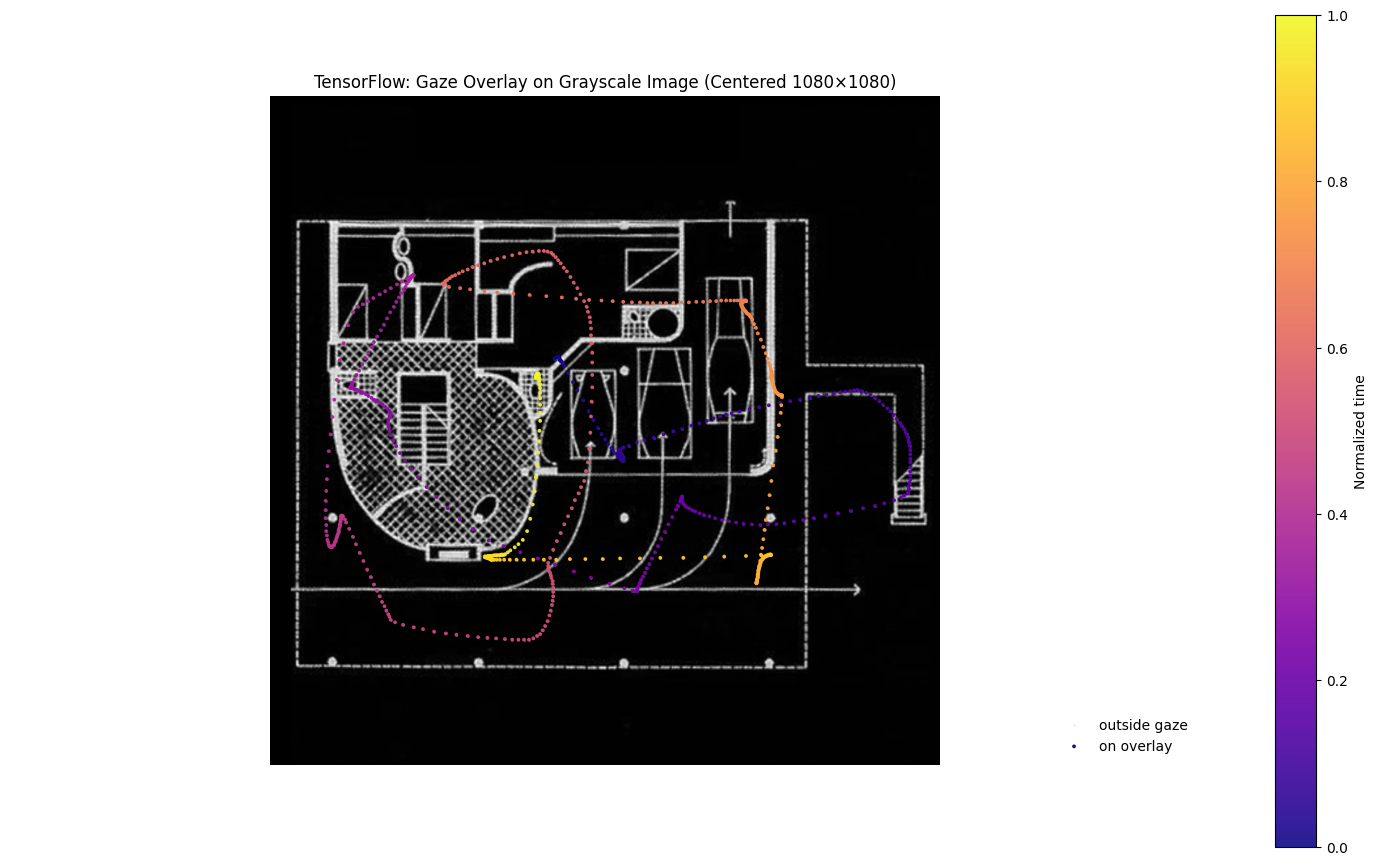

In [ ]:

# --- assume you have ---
# img_tf: shape (1080, 1080), float32 or uint8 Tensor
# x_rot, y_rot: 1D numpy arrays (gaze coordinates in 1920x1080 space)
# tp: 1D numpy array of same length as x_rot (for coloring by time)

canvas_width, canvas_height = 1920, 1080
overlay_left = (canvas_width - 1080) / 2   # 420 px
overlay_right = overlay_left + 1080        # 1500 px



# Convert to NumPy for Matplotlib
img_np = image_tensor.numpy()

# --- mask gaze points within 1080x1080 overlay band ---
mask = (x_rot >= overlay_left) & (x_rot < overlay_right)
x_sq = x_rot[mask] - overlay_left
y_sq = y_rot[mask]

# --- plot ---
plt.figure(figsize=(19.2, 10.8), dpi=100)

# Draw the image in its correct position
plt.imshow(img_np, extent=[overlay_left, overlay_right, 1080, 0], cmap='gray', aspect='equal')

# Plot all points (light gray) to show full canvas
plt.scatter(x_rot, y_rot, c='lightgray', s=1, alpha=0.3, label='outside gaze')

# Plot active region points (within overlay)
plt.scatter(x_sq + overlay_left, y_sq, c=tp[mask], s=3, cmap='plasma', alpha=0.9, label='on overlay')

plt.colorbar(label='Normalized time')
plt.title("TensorFlow: Gaze Overlay on Grayscale Image (Centered 1080×1080)")
plt.xlim([0, canvas_width])
plt.ylim([canvas_height, 0])
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.legend(loc='lower right', frameon=False)
plt.show()


In [ ]:
# Sample values from double-Layered tensor:
y_idx = 60
x_idx = 75

pixel_values = two_ch_tensor[y_idx, x_idx]   # shape (2,)
grayscale_value = pixel_values[0]
gaze_weight = pixel_values[1]
print(grayscale_value, gaze_weight)

tf.Tensor(0.0039215684, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# ROSAS's Network
## Vector Quantizer Layer Build

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

For classifying actions from eye movements:

The encoder transforms gaze patterns (temporal-spatial features) into latent embeddings.

The vector quantizer discretizes these embeddings into prototypical “gaze behavior codes.”

The decoder or classifier then operates on these discrete latent tokens to predict the action label (e.g., explore, focus, search).

So each code in the codebook effectively becomes a learned symbol of gaze behavior — e.g., “smooth pursuit to the left,” “rapid saccade toward target,” “fixation cluster,” etc.

# Sub-Action Extraction Layer (static)
Later will be upgraded into online extraction layer

Final form: Online make of domain knowledge for individual designers

Extract foveal-vision area with eye-movement path segment to build sub-actions:
Its trainable parameters contains PCCA, a probabilistic modeling framework for discretetime stochastic processes.A collection of probabilistic constraint automata operating concurrently. A PCCA is a collection of PCAs (X, T, O).


*   i= xi r i isasetofvariables for component i, and xi is a state variable. r i is a set of attribute variables, including variables used to define the PCA (e.g., observation and guard variables).
*   Ti represents the state transition model for xi. That is, Ti represents P(xi(t + 1) xi(t), r i(t)). Here, xi(t) represents the state of the variable at time t.
*   Oi represents the observation model. Oi represents observation matrix P(oixi), where oi r i Then, PCCA, A, is a set of PCAs.

Is predicates sub-actions?



## Vector Quantizer

In [10]:
# ----------------------------------
# Vector Quantizer
# ----------------------------------
class VectorQuantizer(layers.Layer):
    def __init__(self, num_codes=512, code_dim=128, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.num_codes = num_codes
        self.code_dim = code_dim
        self.beta = beta # commitment loss

    def build(self, input_shape):# a learnable codebook matrix E ​∈ R^number of code*d_code
        # Each row E is a vector embedding that represents one "prototype pattern"
        # in the latent space, such as a gaze trajectory segment
        self.codebook = self.add_weight(
            name="codebook",
            shape=(self.num_codes, self.code_dim),
            initializer="random_uniform",
            trainable=True,
        )

    def call(self, z_e): # z_e continuous latent embedding
        z_e_shape = tf.shape(z_e)
        D = z_e.shape[-1]
        z_flat = tf.reshape(z_e, [-1, D]) # Z ∈ R^ B*H*W*D

        z_sq = tf.reduce_sum(tf.square(z_flat), axis=1, keepdims=True)
        e_sq = tf.reduce_sum(tf.square(self.codebook), axis=1)
        ze = tf.matmul(z_flat, self.codebook, transpose_b=True)
        dists = z_sq + e_sq[None, :] - 2.0 * ze
        # Nearest Code Lookup
        codes = tf.argmin(dists, axis=1)
        # Replace with nearest codebook vector
        z_q_flat = tf.gather(self.codebook, codes)
        # Quantized version of latent representation
        z_q = tf.reshape(z_q_flat, z_e_shape)

        # Loss flows back to codebook z_q
        codebook_loss = tf.reduce_mean(tf.square(tf.stop_gradient(z_e) - z_q))
        # Loss flows back to Latent Space encoder only z_e
        commitment_loss = tf.reduce_mean(tf.square(z_e - tf.stop_gradient(z_q)))

        self.add_loss(codebook_loss + self.beta * commitment_loss)

        z_q = z_e + tf.stop_gradient(z_q - z_e)
        return z_q, codes

# ----------------------------------
# Encoder
# ----------------------------------
# Hierarchical feature extractor
def ConvBlock(ch, ks=3, s=1):
    return keras.Sequential([
        layers.Conv2D(ch, ks, strides=s, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.Activation("relu"),
    ])

def build_encoder(in_ch=2, base=64, latent_dim=128):
    x_in = keras.Input(shape=(None, None, in_ch))

    # downsample 2 x 3 times
    x = ConvBlock(base)(x_in) # H x W, Channel numbers = in_ch
    x = ConvBlock(base, s=2)(x) # H/2 x W/2
    x = ConvBlock(base*2)(x) # Channel x 2
    x = ConvBlock(base*2, s=2)(x) # H/4 W/4
    x = ConvBlock(base*4)(x) # Channel x 4
    x = ConvBlock(base*4, s=2)(x) # H/8 W/8
    x = ConvBlock(base*4)(x) # channel x 4

    # Output latent space: z_e (B, H/8(68), W/8(68), latent_dim = codebookdime)
    z_e = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(x_in, z_e, name="encoder")

# ----------------------------------
# Classifier Head
# ----------------------------------
def build_classifier_head(num_classes, feature_dim, dropout=0.25):
    x_in = keras.Input(shape=(None, None, feature_dim))
    # A small Multi Layer Perception that receives quantized latents, and
    # do classification
    x = layers.GlobalAveragePooling2D()(x_in) # glabal pattern probability
    if dropout:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(x_in, out, name="classifier_head")

# ----------------------------------
# Full Model with Downscaling
# ----------------------------------
def build_vq_classifier_540(num_classes,
                            num_codes=512,
                            code_dim=128,
                            beta=0.25,
                            base=64,
                            dropout=0.25):
    inputs = keras.Input(shape=(None, None, 2))  # expects 540×540×2 from dataset

    # ↓ Downscale to 540×540
    #x = layers.Resizing(540, 540, interpolation="bilinear", name="downscale")(inputs)

    # encoder to latent space (Environment)
    encoder = build_encoder(in_ch=2, base=base, latent_dim=code_dim)
    z_e = encoder(inputs)

    # Codebook (Vector QUantizer)
    vq = VectorQuantizer(num_codes=num_codes, code_dim=code_dim, beta=beta)
    z_q, _ = vq(z_e)

    # Classifier (consumes z_q, pools spatially, predict class probabilities)
    head = build_classifier_head(num_classes, feature_dim=code_dim, dropout=dropout)
    logits = head(z_q)

    model = keras.Model(inputs, logits, name="vq_classifier_540")
    return model

## improve encoder v2

In [11]:


# -------------------------
# Norms & small helpers
# -------------------------
def GroupNorm(groups=8, epsilon=1e-5, name=None):
    return layers.GroupNormalization(groups=groups, epsilon=epsilon, name=name)

def ConvBNAct(ch, ks=3, s=1, norm='gn', act='relu', name=None):
    def block(x):
        x = layers.Conv2D(ch, ks, strides=s, padding="same", use_bias=False, name=None if name is None else f"{name}_conv")(x)
        x = GroupNorm(name=None if name is None else f"{name}_gn")(x) if norm=='gn' \
            else layers.BatchNormalization(name=None if name is None else f"{name}_bn")(x)
        if act:
            x = layers.Activation(act, name=None if name is None else f"{name}_act")(x)
        return x
    return block

class DropPath(layers.Layer):
    def __init__(self, drop_prob=0.0, **kwargs):
        super().__init__(**kwargs); self.drop_prob = drop_prob
    def call(self, x, training=None):
        if (not training) or self.drop_prob == 0.0:
            return x
        keep = 1.0 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,)*(len(x.shape)-1)
        r = tf.random.uniform(shape, dtype=x.dtype)
        return x * tf.cast(r < keep, x.dtype) / keep

def SEBlock(reduction=0.25, name=None):
    def block(x):
        ch = x.shape[-1]
        mid = max(8, int(ch * reduction))
        s = layers.GlobalAveragePooling2D(name=None if name is None else f"{name}_gap")(x)
        s = layers.Dense(mid, activation="relu", name=None if name is None else f"{name}_fc1")(s)
        s = layers.Dense(ch, activation="sigmoid", name=None if name is None else f"{name}_fc2")(s)
        s = layers.Reshape((1,1,ch))(s)
        return layers.Multiply(name=None if name is None else f"{name}_scale")([x, s])
    return block

class BlurPoolLayer(layers.Layer):
    """3×3 binomial blur (depthwise) + 2× downsample, non-trainable."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._pool = layers.AveragePooling2D(pool_size=2, strides=2, padding="same")

    def build(self, input_shape):
        ch = int(input_shape[-1])
        # 3x3 binomial kernel
        k = tf.constant([[1.,2.,1.],
                         [2.,4.,2.],
                         [1.,2.,1.]], dtype=tf.float32) / 16.0
        k = tf.reshape(k, (3, 3, 1, 1))                          # (3,3,1,1)
        k = tf.tile(k, [1, 1, ch, 1])                             # (3,3,C,1) depthwise
        # store as a non-trainable weight so it traces correctly
        self.kernel = self.add_weight(
            name="blur_kernel",
            shape=(3,3,ch,1),
            initializer=tf.keras.initializers.Constant(k.numpy()),
            trainable=False,
        )

    def call(self, x):
        # depthwise blur, then average pool
        x = tf.nn.depthwise_conv2d(x, self.kernel, strides=[1,1,1,1], padding="SAME")
        return self._pool(x)


def ResidualBlock(ch, stride=1, use_se=True, drop_path=0.0, norm='gn', dilation=1, name=None):
    def block(x):
        in_ch = x.shape[-1]
        shortcut = x

        # downsample via blurpool if stride>1
        if stride == 1:
            y = ConvBNAct(ch, 1, 1, norm=norm, act='relu', name=None if name is None else f"{name}_conv1")(x)
        else:
            y = BlurPoolLayer(name=None if name is None else f"{name}_blur")(x)
            y = ConvBNAct(ch, 1, 1, norm=norm, act='relu', name=None if name is None else f"{name}_conv1")(y)

        # depthwise (with dilation) + pointwise
        y = layers.DepthwiseConv2D(3, padding="same", dilation_rate=dilation, use_bias=False,
                                   name=None if name is None else f"{name}_dw")(y)
        y = GroupNorm(name=None if name is None else f"{name}_dw_gn")(y) if norm=='gn' \
            else layers.BatchNormalization(name=None if name is None else f"{name}_dw_bn")(y)
        y = layers.Activation("relu")(y)
        y = layers.Conv2D(ch, 1, padding="same", use_bias=False, name=None if name is None else f"{name}_pw")(y)
        y = GroupNorm(name=None if name is None else f"{name}_pw_gn")(y) if norm=='gn' \
            else layers.BatchNormalization(name=None if name is None else f"{name}_pw_bn")(y)

        if use_se:
            y = SEBlock(0.25, name=None if name is None else f"{name}_se")(y)

        # match shortcut if channels differ
        if (in_ch != ch) or (stride > 1):
            s = 2 if stride > 1 else 1
            shortcut = ConvBNAct(ch, 1, s, norm=norm, act=None, name=None if name is None else f"{name}_proj")(shortcut)

        y = layers.Add()([shortcut, DropPath(drop_path, name=None if name is None else f"{name}_droppath")(y)])
        y = layers.Activation("relu")(y)
        return y
    return block

def ASPP_Lite(ch, rates=(1,2,3), norm='gn', name="aspp"):
    def branch(x, rate, idx):
        y = layers.Conv2D(ch, 3, padding="same", dilation_rate=rate, use_bias=False, name=f"{name}_dil{idx}")(x)
        y = GroupNorm(name=f"{name}_dil{idx}_gn")(y) if norm=='gn' else layers.BatchNormalization(name=f"{name}_dil{idx}_bn")(y)
        y = layers.Activation("relu")(y)
        return y
    def block(x):
        feats = [branch(x, r, i) for i, r in enumerate(rates)]
        y = layers.Concatenate(name=f"{name}_concat")(feats)
        y = ConvBNAct(ch, 1, 1, norm=norm, act='relu', name=f"{name}_fuse")(y)
        return y
    return block

# -------------------------
# Improved encoder (stride total = 8x), slash-free names
# -------------------------
def build_encoder_v2(in_ch=2, base=64, code_dim=128, norm='gn',
                     depths=(2,2,3),      # blocks per stage
                     drop_path_rate=0.1,
                     dilations=(1,1,2),   # last stage uses dilation
                     use_se=True,
                     name="encoder_v2"):
    """
    Output: z_e of shape (B, H/8, W/8, code_dim)
    """
    x_in = keras.Input(shape=(None, None, in_ch), name="input")

    # Stem → /2
    x = ConvBNAct(base, 3, 1, norm=norm, act='relu', name="stem_conv")(x_in)
    x = BlurPoolLayer(name="stem_blur")(x)                  # H/2, W/2
    x = ConvBNAct(base, 3, 1, norm=norm, act='relu', name="stem_conv2")(x)

    # linear DropPath schedule
    dp_idx, total_blocks = 0, sum(depths)
    def dpr():
        nonlocal dp_idx
        val = drop_path_rate * dp_idx / max(1, total_blocks-1)
        dp_idx += 1
        return val

    # Stage 1 (keep /2)
    for b in range(depths[0]):
        x = ResidualBlock(base, stride=1, use_se=use_se, drop_path=dpr(), norm=norm, dilation=1,
                          name=f"stage1_b{b}")(x)

    # Stage 2 → /4
    x = ResidualBlock(base*2, stride=2, use_se=use_se, drop_path=dpr(), norm=norm, dilation=1,
                      name="stage2_down")(x)
    for b in range(depths[1]-1):
        x = ResidualBlock(base*2, stride=1, use_se=use_se, drop_path=dpr(), norm=norm, dilation=1,
                          name=f"stage2_b{b}")(x)

    # Stage 3 → /8 + dilation
    x = ResidualBlock(base*4, stride=2, use_se=use_se, drop_path=dpr(), norm=norm, dilation=1,
                      name="stage3_down")(x)
    for b in range(depths[2]-1):
        x = ResidualBlock(base*4, stride=1, use_se=use_se, drop_path=dpr(), norm=norm, dilation=dilations[2],
                          name=f"stage3_b{b}")(x)

    # ASPP-lite (multi-scale fusion)
    x = ASPP_Lite(base*4, rates=(1,2,3), norm=norm, name="aspp")(x)

    # Project to code_dim for VQ
    z_e = layers.Conv2D(code_dim, 1, padding="same", name="proj_code")(x)

    return keras.Model(x_in, z_e, name=name)


In [12]:
def build_vq_classifier_540_v2(num_classes,
                               num_codes=512, code_dim=128, beta=0.25,
                               base=64, dropout=0.25):
    inputs = keras.Input(shape=(None, None, 2), name="inputs")
    encoder = build_encoder_v2(in_ch=2, base=base, code_dim=code_dim, norm='gn',
                               depths=(2,2,3), drop_path_rate=0.1, dilations=(1,1,2), use_se=True)
    z_e = encoder(inputs)

    # encoder to latent space (Environment)
    vq = VectorQuantizer(num_codes=num_codes, code_dim=code_dim, beta=beta, name="vq")
    z_q, _ = vq(z_e)

    head = build_classifier_head(num_classes, feature_dim=code_dim, dropout=dropout)  # original head
    logits = head(z_q)
    return keras.Model(inputs, logits, name="vq_classifier_540_v2")


In [ ]:
# ----------------------------------
# Example usage V1
# ----------------------------------
num_classes = 3  # e.g., Explore / Focus / Search or Shape/Circulation/Hierarchy
model = build_vq_classifier_540(num_classes=num_classes)

steps_per_epoch = 8

decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=steps_per_epoch*30, alpha=1e-2
)
opt = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)



In [ ]:
# Model V2
num_classes = 3
# e.g., Explore / Focus / Search or Shape/Circulation/Hierarchy
model_v2 = build_vq_classifier_540_v2(num_classes=num_classes)

opt = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)
model_v2.compile(opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.05)  # use one-hot labels
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Cosine decay + warmup is even nicer if you have a scheduler utility.


In [ ]:
model_v2.summary()

Model: "vq_classifier_540_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, None, None, 2)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_v2 (Functional)         │ (None, None, None,     │     2,655,008 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vq (VectorQuantizer)            │ [(None, None, None,    │        65,536 │
│                                 │ 128), (None)]          │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_head (Functional)    │ (None, 3)              │        33,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,754,339 (10.51 MB)

 Trainable params: 2,752,035 (10.50 MB)

 Non-trainable params: 2,304 (9.00 KB)

## Add SpeedGrouperLayer

In [43]:
from tensorflow.keras import layers, metrics

In [39]:
class GazeSpeedGrouper(layers.Layer):
    """
    Input  : (B,H,W,C>=3) with channels [image=0, gaze=1, speed=2]
    Output : (B,H,W,1+K) = [image, gaze_slow, gaze_med, ..., gaze_fast]
    """
    def __init__(self, num_groups=3, speed_idx=2, temperature=1.0,
                 entropy_weight=1e-3, separation_weight=1e-2,
                 keep_speed=False, name="gaze_speed_grouper", **kw):
        super().__init__(name=name, **kw)
        self.K = int(num_groups)
        self.speed_idx = int(speed_idx)
        self.temperature = float(temperature)
        self.entropy_weight = float(entropy_weight)
        self.separation_weight = float(separation_weight)
        self.keep_speed = bool(keep_speed)

        # Keras 3: create trackers here; update them in call()
        self._usage_trackers = [metrics.Mean(name=f"group_usage_{k}") for k in range(self.K)]

    @property
    def metrics(self):
        # Keras will log/reset these automatically
        return self._usage_trackers

    def build(self, input_shape):
        # Learnable bin centers and widths
        self.mu_unconstrained = self.add_weight(
            name="mu_unconstrained", shape=(self.K,), initializer="zeros", trainable=True
        )
        self.log_sigma = self.add_weight(
            name="log_sigma", shape=(self.K,),
            initializer=tf.keras.initializers.Constant(-1.0), trainable=True
        )
        super().build(input_shape)

    @staticmethod
    def _minmax01(x, eps=1e-6):
        xmin = tf.reduce_min(x, axis=[1,2], keepdims=True)
        xmax = tf.reduce_max(x, axis=[1,2], keepdims=True)
        return (x - xmin) / tf.maximum(xmax - xmin, eps)

    def call(self, x, training=None):
        # Sanity: need 3 channels
        tf.debugging.assert_greater_equal(
            tf.shape(x)[-1], 3,
            message="GazeSpeedGrouper expects at least 3 channels: [image, gaze, speed]."
        )

        img   = x[..., 0:1]                                 # (B,H,W,1)
        gaze  = x[..., 1:2]                                 # (B,H,W,1)  <-- fixed slice
        speed = x[..., self.speed_idx:self.speed_idx+1]     # (B,H,W,1)

        # Normalize speed to [0,1] per-sample
        s = self._minmax01(speed)

        # Constrain params
        mu    = tf.sigmoid(self.mu_unconstrained)         # (K,)
        sigma = tf.nn.softplus(self.log_sigma) + 1e-3     # (K,)

        # Soft assignments via RBFs: (B,H,W,K)
        logits = -0.5 * tf.square((s - mu)) / tf.square(sigma) / self.temperature
        assign = tf.nn.softmax(logits, axis=-1)

        # Split gaze into K grouped channels
        gaze_groups = gaze * assign                        # (B,H,W,K)

        # Regularizers (kept via add_loss, OK in Keras 3)
        eps = 1e-8
        entropy = -tf.reduce_mean(tf.reduce_sum(assign * tf.math.log(assign + eps), axis=-1))
        self.add_loss(self.entropy_weight * entropy)

        diffs = tf.abs(mu[None, :] - mu[:, None]) + tf.eye(self.K)
        sep_pen = tf.reduce_sum(tf.exp(-diffs)) - tf.cast(self.K, tf.float32)
        self.add_loss(self.separation_weight * sep_pen)

        # Update trackers instead of add_metric
        usage = tf.reduce_mean(assign, axis=[0,1,2])  # (K,)
        for k, m in enumerate(self._usage_trackers):
            m.update_state(usage[k])

        out = tf.concat([img, gaze_groups], axis=-1)  # (B,H,W,1+K)
        if self.keep_speed:
            out = tf.concat([out, speed], axis=-1)    # (B,H,W,2+K)

        return out


In [40]:
# Model with speed grouper
# class GazeSpeedGrouper(...):  # uses channel 2 as speed
#     ...

def build_vq_classifier_540_v2(num_classes,
                               num_codes=512, code_dim=128, beta=0.25,
                               base=64, dropout=0.25,
                               # --- NEW: speed grouping params ---
                               num_speed_groups=3,          # K = 3 categories
                               use_speed_grouper=True,      # turn on/off grouping layer
                               speed_idx=2,                 # channel index of speed in input
                               keep_speed=False,            # optionally keep raw speed
                               temperature=1.0,
                               entropy_weight=1e-3,
                               separation_weight=1e-2):
    """
    Expects input (H,W,3) = [image, gaze, speed].
    If use_speed_grouper=True, expands to (H,W,1+K[+1 if keep_speed]) before encoder.
    """

    # --- Inputs: switch to 3 channels ---
    inputs = keras.Input(shape=(None, None, 3), name="inputs")  # [img, gaze, speed]

    x = inputs
    if use_speed_grouper:
        x = GazeSpeedGrouper(num_groups=num_speed_groups,
                             speed_idx=speed_idx,
                             temperature=temperature,
                             entropy_weight=entropy_weight,
                             separation_weight=separation_weight,
                             keep_speed=keep_speed,
                             name="gaze_speed_grouper")(x)
        # channels going into encoder
        in_ch = 1 + num_speed_groups + (1 if keep_speed else 0)
    else:
        # no grouping; pass 3 channels directly
        in_ch = 3

    # --- Encoder sees grouped channels ---
    encoder = build_encoder_v2(in_ch=in_ch, base=base, code_dim=code_dim, norm='gn',
                               depths=(2, 2, 3), drop_path_rate=0.1,
                               dilations=(1, 1, 2), use_se=True)
    z_e = encoder(x)

    # --- VQ bottleneck ---
    vq = VectorQuantizer(num_codes=num_codes, code_dim=code_dim, beta=beta, name="vq")
    z_q, _ = vq(z_e)

    # --- Classifier head on quantized latents ---
    head = build_classifier_head(num_classes, feature_dim=code_dim, dropout=dropout)
    logits = head(z_q)

    return keras.Model(inputs, logits, name="vq_classifier_540_v2_speedgroups")



In [41]:
class_names = ("Shape","Circulation","Hierarchy")

In [44]:
model = build_vq_classifier_540_v2(
    num_classes=len(class_names),
    num_codes=512, code_dim=128, beta=0.25, base=64, dropout=0.25,
    num_speed_groups=3, use_speed_grouper=True, keep_speed=False
)

# Input batch should be (B, 540, 540, 3)



'for X, y in build_dataset_3ch(image_paths, gaze_csv_paths, label_ids, batch_size=2).take(1):\n    out = model(X)  # forward pass works end-to-end\n    print("logits:", out.shape)'

# Load Data

In [13]:
import os, re, glob

In [14]:
# Point to the folder(s)
CSV_DIR  = "/content/drive/MyDrive/2025Fall/Thesis/Savoye_Drawings/Oct20_CSV/"     # or same folder for both
IMG_DIR  = "/content/drive/MyDrive/2025Fall/Thesis/Savoye_Drawings/All_Drawings/"   # can be same as CSV_DIR

In [15]:
# Acceptable image extensions (priority order if multiple exist)
IMG_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"]

# ---- groupNumber → image basename mapping ----
GROUP_TO_IMAGE = {
     1:"G1",  2:"P1",  3:"S1",  4:"E1",
     5:"G2",  6:"P2",  7:"S2",  8:"E2",
     9:"G3", 10:"P3", 11:"S3", 12:"E3",
    13:"G4", 14:"P4", 15:"S4", 16:"E4",
}
IMG_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"]
label_to_id = {"shape": 0, "circulation": 1, "heirarchy": 2}

# Regex: capture label and the trailing group number with optional "group" prefix
# Examples matched:
#   Savoye_Circulation_GazeCoordinates_group13.csv
#   Foo_shape_something_GROUP1.csv
CSV_RE = re.compile(
    r"^(?P<bname>.+?)_(?P<label>shape|circulation|heirarchy)_(?P<dtype>.+?)_(?:group)?(?P<group>\d+)\.csv$",
    re.IGNORECASE
)

In [16]:
def find_image_for_group(group_num: int) -> str | None:
    base = GROUP_TO_IMAGE.get(group_num)
    if not base:
        return None
    for ext in IMG_EXTS:
        p = os.path.join(IMG_DIR, base + ext)
        if os.path.isfile(p):
            return p
    for ext in IMG_EXTS:
        matches = glob.glob(os.path.join(IMG_DIR, f"*{base}*{ext}"))
        if matches:
            return matches[0]
    return None

image_paths, gaze_csv_paths, label_ids = [], [], []
unparsed, no_image = [], []

for csv_path in glob.glob(os.path.join(CSV_DIR, "*.csv")):
    fn = os.path.basename(csv_path)
    m = CSV_RE.match(fn)
    if not m:
        unparsed.append(fn)
        continue

    label_text = m.group("label").strip().lower()
    group_num = int(m.group("group"))

    img_path = find_image_for_group(group_num)
    if img_path is None:
        no_image.append((fn, group_num))
        continue

    image_paths.append(img_path)
    gaze_csv_paths.append(csv_path)
    label_ids.append(label_to_id[label_text])

print(f"Paired samples: {len(image_paths)}")
if unparsed:
    print("[WARN] Unparsed CSV filenames:", unparsed[:5])
if no_image:
    print("[WARN] No image found for:", no_image[:5])
unique_ids, counts = np.unique(label_ids, return_counts=True)
print("Label distribution:", dict(zip(unique_ids, counts)))

Paired samples: 48
Label distribution: {np.int64(0): np.int64(16), np.int64(1): np.int64(16), np.int64(2): np.int64(16)}


In [17]:
IMG_H, IMG_W = 1080, 1080           # target image size
CANVAS_W, CANVAS_H = 1920, 1080     # original XY coordinate space
X_LEFT = (CANVAS_W - IMG_W) // 2    # 420
X_RIGHT = X_LEFT + IMG_W            # 1500

In [18]:
# =====================================================
# 3. GAZE CSV → CANVAS PIXELS (pre-processing)
# =====================================================
def _load_and_process_gaze_csv_numpy(csv_path_bytes):
    """
    Loads one CSV file and returns xp, yp, tp arrays (in canvas pixel space).
    Applies your full pre-processing logic.
    """
    path = csv_path_bytes.decode("utf-8")
    data = np.loadtxt(path, delimiter=',', skiprows=1)
    # Separate the data into x and y coordinates
    x_list = data[:, 3]   # gaze x
    y_list = data[:, 4]   # gaze y
    t_interval_list = data[:, 2]
    t_list = list(accumulate(t_interval_list))  # cumulative timestamps

    # Convert normalized [-1,1] to pixel coords
    x_pixel = [(x + 1)/2 * (CANVAS_W - 1) for x in x_list]
    y_pixel = [CANVAS_H - ((y + 1)/2 * (CANVAS_H - 1)) for y in y_list]

    # Round to nearest integer
    x_pixel = np.round(x_pixel).astype(np.int32)
    y_pixel = np.round(y_pixel).astype(np.int32)

    # Normalize timestamps to [0,1]
    t_min, t_max = np.min(t_list), np.max(t_list)
    if t_max > t_min:
        t_norm = [(t - t_min) / (t_max - t_min) for t in t_list]
    else:
        t_norm = [0.0 for _ in t_list]

    # Filter to on-screen points
    mask = (x_pixel >= 0) & (x_pixel < CANVAS_W) & (y_pixel >= 0) & (y_pixel < CANVAS_H)
    xp = np.array(x_pixel)[mask]
    yp = np.array(y_pixel)[mask]
    tp = np.array(t_norm)[mask]  # normalized weights [0,1]


    # 90° clockwise rotation — optional (currently none in your snippet)
    # x_rot = CANVAS_H - yp
    # y_rot = xp
    # xp, yp = x_rot, y_rot

    return xp.astype(np.float32), yp.astype(np.float32), tp.astype(np.float32)

def load_gaze_from_csv_tf(csv_path: tf.Tensor):
    xp, yp, tp = tf.numpy_function(
        _load_and_process_gaze_csv_numpy, [csv_path],
        Tout=[tf.float32, tf.float32, tf.float32]
    )
    xp.set_shape([None]); yp.set_shape([None]); tp.set_shape([None])

    return xp, yp, tp

In [19]:
# =====================================================
# 4. IMAGE LOADER
# =====================================================
def load_image_1080(image_path: tf.Tensor) -> tf.Tensor:
    img_bytes = tf.io.read_file(image_path)
    img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_H, IMG_W], method="bilinear", antialias=True)
    return tf.squeeze(img, axis=-1)  # (1080,1080)


In [20]:
# =====================================================
# 5. UTILITIES
# =====================================================
def normalize_to_01(img_uint8_or_float):
    x = tf.convert_to_tensor(img_uint8_or_float)
    return tf.image.convert_image_dtype(x, dtype=tf.float32)

def coords_to_image_indices_with_weights(x, y, weights=None):
    """
    Map (x,y) in 1920x1080 canvas to indices on the centered 1080x1080 square.
    Returns y_idx, x_idx, w_aligned where all three have the same length.
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)

    if weights is None:
        # If no weights provided, create ones that will be masked along with coords
        weights = tf.ones_like(x, dtype=tf.float32)
    else:
        weights = tf.convert_to_tensor(weights, dtype=tf.float32)

    # Same in-band mask you already use
    in_band = (x >= X_LEFT) & (x < X_RIGHT) & (y >= 0) & (y < IMG_H)

    # Apply the SAME mask to x, y, and weights
    x = tf.boolean_mask(x, in_band)
    y = tf.boolean_mask(y, in_band)
    w = tf.boolean_mask(weights, in_band)

    # Shift + clamp → integer pixel indices
    x_sq = x - float(X_LEFT)                # [0,1080)
    y_sq = y
    x_idx = tf.cast(tf.clip_by_value(tf.floor(x_sq), 0, IMG_W - 1), tf.int32)
    y_idx = tf.cast(tf.clip_by_value(tf.floor(y_sq), 0, IMG_H - 1), tf.int32)

    return y_idx, x_idx, w

def scatter_count_layer(y_idx, x_idx, weights):

    flat_idx = y_idx * IMG_W + x_idx
    counts = tf.math.unsorted_segment_sum(weights, flat_idx, IMG_H * IMG_W)
    layer = tf.reshape(counts, (IMG_H, IMG_W))
    maxv = tf.reduce_max(layer)
    layer = tf.where(maxv > 0, layer / maxv, layer)
    return tf.cast(layer, tf.float32)

def gaussian_kernel_1d(sigma, radius=None):
    if radius is None:
        radius = int(tf.math.ceil(3.0 * sigma))
    coords = tf.range(-radius, radius + 1, dtype=tf.float32)
    g = tf.exp(-(coords**2) / (2.0 * sigma**2))
    g /= tf.reduce_sum(g)
    g = tf.reshape(g, (-1, 1, 1, 1))
    return g, radius

def gaussian_blur_2d(layer, sigma=2.0):
    x = tf.reshape(layer, (1, IMG_H, IMG_W, 1))
    g, r = gaussian_kernel_1d(sigma)
    kx = tf.transpose(g, perm=[1, 0, 2, 3])
    x = tf.nn.depthwise_conv2d(x, kx, strides=[1,1,1,1], padding='SAME')
    ky = g
    x = tf.nn.depthwise_conv2d(x, ky, strides=[1,1,1,1], padding='SAME')
    x = tf.squeeze(x)
    maxv = tf.reduce_max(x)
    x = tf.where(maxv > 0, x / maxv, x)
    return tf.cast(x, tf.float32)

def build_two_channel_tensor(img_1080_gray, x_coords, y_coords, weights=None,
                             use_gaussian=False, gaussian_sigma=2.0):
    img0 = normalize_to_01(img_1080_gray)
    # Map coords AND align weights
    y_idx, x_idx, w_aligned = coords_to_image_indices_with_weights(x_coords, y_coords, weights)

    # Early-out: if no points after masking, avoid NaNs and just make zeros
    def empty_layer():
        return tf.zeros((IMG_H, IMG_W), dtype=tf.float32)

    def nonempty_layer():
        base = scatter_count_layer(y_idx, x_idx, weights=w_aligned)
        if use_gaussian:
            base = gaussian_blur_2d(base, sigma=gaussian_sigma)
        return base

    base = tf.cond(tf.size(y_idx) > 0, nonempty_layer, empty_layer)

    # Stack channels
    return tf.stack([img0, base], axis=-1)


In [150]:
# Build 3-channel tensors
def _scatter_sum(h, w, y_idx, x_idx, values, dtype=tf.float32):
    """Sum-reduce values at integer image coordinates into an (H,W) image."""
    img = tf.zeros((h, w), dtype=dtype)
    idx = tf.stack([y_idx, x_idx], axis=-1)  # (N, 2)
    return tf.tensor_scatter_nd_add(img, idx, values)

def _scatter_mean(h, w, y_idx, x_idx, values, eps=1e-6, dtype=tf.float32):
    """Mean-reduce values at integer image coordinates into an (H,W) image."""
    sum_img = _scatter_sum(h, w, y_idx, x_idx, values, dtype=dtype)
    ones    = tf.ones_like(values, dtype=dtype)
    cnt_img = _scatter_sum(h, w, y_idx, x_idx, ones, dtype=dtype)
    return sum_img / (cnt_img + eps)

def _robust_unit(x, p=95.0, eps=1e-6):
    """Robust [0,1] scaling using 95th percentile; clips outliers."""
    # Flatten across spatial dims if needed; here x is (N,) or (B,H,W,1)
    q = tfp.stats.percentile(x, p, interpolation='linear')  # requires tfp
    q = tf.maximum(q, eps)
    return tf.clip_by_value(x / q, 0.0, 1.0)

def build_three_channel_tensor(img_1080_gray,
                               x_coords, y_coords, t_stamps,
                               use_gaussian=True, gaussian_sigma=2.0,
                               base_weights=None,
                               speed_reduce='mean',
                               speed_normalize='per_seq_robust'):
    """
    Returns (H,W,3): [img_01, base_gaze, speed_map]

    - base_gaze: same idea as your 2-ch builder (optionally time-weighted).
    - speed_map: per-pixel aggregation of segment speeds (pixels/sec).
      Segment speed is assigned to the *second* sample of each (i-1 -> i) segment.
    """
    img0 = normalize_to_01(img_1080_gray)

    # --------------------------
    # 1) Base gaze map (keeps your current behavior)
    # --------------------------
    y_idx, x_idx, w_aligned = coords_to_image_indices_with_weights(
        x_coords, y_coords, base_weights
    )

    def empty_layer():
        return tf.zeros((IMG_H, IMG_W), dtype=tf.float32)

    def nonempty_layer():
        base = _scatter_sum(IMG_H, IMG_W, y_idx, x_idx, w_aligned)
        if use_gaussian:
            base = gaussian_blur_2d(base, sigma=gaussian_sigma)
        return base

    base = tf.cond(tf.size(y_idx) > 0, nonempty_layer, empty_layer)

    # --------------------------
    # 2) Speed map
    # --------------------------
    # Need at least 2 points to form a segment
    def build_speed_map():
        # Original float coords & times for segment diffs
        # (We also need integer pixel indices aligned to the *second* sample)
        x = tf.cast(x_coords, tf.float32)
        y = tf.cast(y_coords, tf.float32)
        t = tf.cast(t_stamps, tf.float32)

        # Deltas (N-1)
        dx = x[1:] - x[:-1]
        dy = y[1:] - y[:-1]
        dt = t[1:] - t[:-1]

        # Guard against non-positive dt
        dt = tf.maximum(dt, 1e-6)

        # Segment speed in *canvas pixels per second*
        seg_speed = tf.sqrt(dx*dx + dy*dy) / dt  # (N-1,)

        # Normalize if desired (keeps relative structure within a sample)
        if speed_normalize == 'per_seq_robust':
            # Avoid tfp requirement by simple high-quantile approximation if you prefer:
            # q = tf.experimental.numpy.percentile(seg_speed, 95)
            # seg_speed = tf.clip_by_value(seg_speed / tf.maximum(q, 1e-6), 0.0, 1.0)
            import tensorflow_probability as tfp  # only needed if using _robust_unit above
            q = tfp.stats.percentile(seg_speed, 95.0, interpolation='linear')
            seg_speed = tf.clip_by_value(seg_speed / tf.maximum(q, 1e-6), 0.0, 1.0)
        elif speed_normalize == 'per_seq_max':
            m = tf.reduce_max(seg_speed)
            seg_speed = tf.clip_by_value(seg_speed / tf.maximum(m, 1e-6), 0.0, 1.0)
        elif speed_normalize == 'none':
            pass

        # Pixel indices for *second* endpoints
        # Reuse your indexer but shift by 1 to align with seg_speed
        _, _, _ = coords_to_image_indices_with_weights(x_coords, y_coords, None)
        y_full, x_full, _ = coords_to_image_indices_with_weights(x_coords, y_coords, tf.zeros_like(x_coords))
        y2 = y_full[1:]
        x2 = x_full[1:]

        # Reduce to image: mean/max/sum
        if speed_reduce == 'mean':
            sp = _scatter_mean(IMG_H, IMG_W, y2, x2, seg_speed)
        elif speed_reduce == 'max':
            # max via trick: scatter sum of exp(k*val) / count, or do two passes:
            # Here we implement a simple "approx max" using high power; adjust k as needed.
            k = 8.0
            sp_num = _scatter_sum(IMG_H, IMG_W, y2, x2, tf.pow(seg_speed, k))
            sp_den = _scatter_sum(IMG_H, IMG_W, y2, x2, tf.ones_like(seg_speed))
            sp = tf.pow(sp_num / tf.maximum(sp_den, 1e-6), 1.0 / k)
        elif speed_reduce == 'sum':
            sp = _scatter_sum(IMG_H, IMG_W, y2, x2, seg_speed)
        else:
            sp = _scatter_mean(IMG_H, IMG_W, y2, x2, seg_speed)

        # Optional smoothing to fill tiny gaps
        if use_gaussian:
            sp = gaussian_blur_2d(sp, sigma=gaussian_sigma)

        return sp

    speed_map = tf.cond(tf.size(x_coords) > 1, build_speed_map, empty_layer)

    # Stack channels: [image_01, base_gaze, speed]
    out = tf.stack([img0, base, speed_map], axis=-1)  # (H,W,3)
    return out

### Old Two channel tensor (deprecated)

In [151]:
# =====================================================
# 6.1 BUILD A SINGLE SAMPLE (IMAGE + CSV) 2 channels
# =====================================================
def make_example_from_paths(image_path, gaze_csv_path, label_id, resize_to_540=True):
    img_1080 = load_image_1080(image_path)
    xp, yp, tp = load_gaze_from_csv_tf(gaze_csv_path)
    two_ch = build_two_channel_tensor(img_1080, xp, yp, weights=tp,
                                      use_gaussian=True, gaussian_sigma=2.0)
    if resize_to_540:
        two_ch = tf.image.resize(two_ch, [540, 540], method="bilinear", antialias=True)
    return two_ch, tf.cast(label_id, tf.int32)

In [152]:
# =====================================================
# 7. BUILD THE FULL DATASET
# =====================================================
def build_dataset(image_paths, gaze_csv_paths, label_ids,
                  batch_size=2, shuffle=True, resize_to_540=True):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, gaze_csv_paths, label_ids))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda ip, gp, lid:
                make_example_from_paths(ip, gp, lid, resize_to_540=resize_to_540),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

Batch X: (2, 540, 540, 2)
Batch y: [2 2]


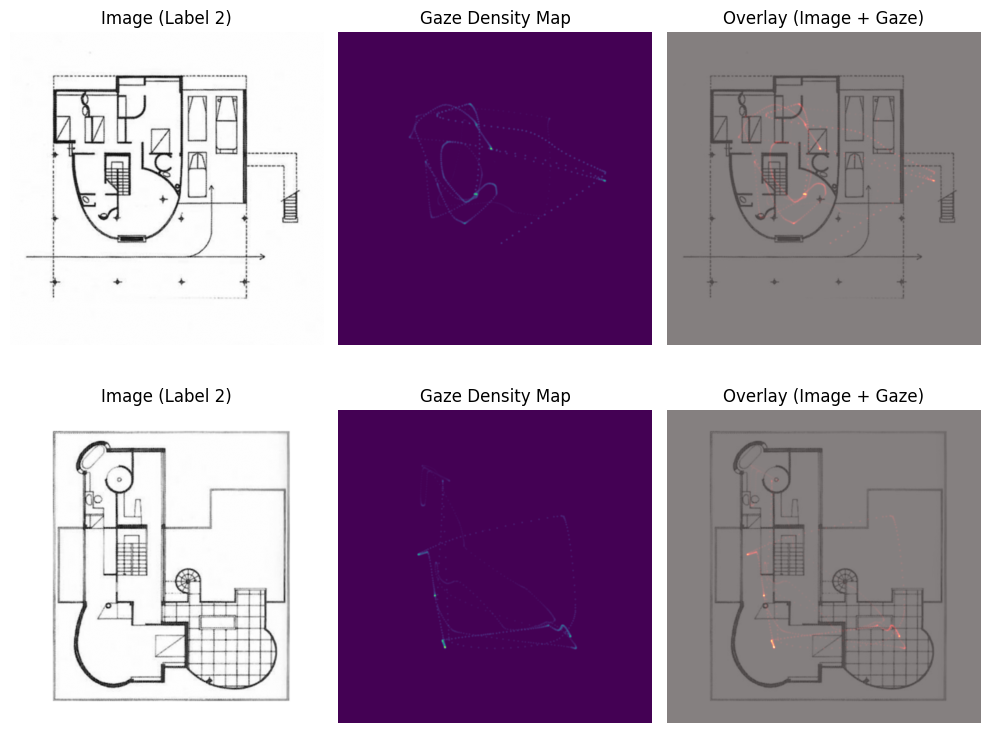

In [25]:
# =====================================================
# 8.USAGE
# =====================================================
BATCH_SIZE = 2
RESIZE_TO_540 = True

dataset = build_dataset(image_paths, gaze_csv_paths, label_ids,
                        batch_size=BATCH_SIZE, resize_to_540=RESIZE_TO_540)

# Peek and visualize
for X, y in dataset.take(1):
    print("Batch X:", X.shape)  # (B, 540, 540, 2)
    print("Batch y:", y.numpy())  # [0, 1, 2]

    batch_size = X.shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(10,4*batch_size))

    if batch_size == 1:
        axes = [axes]  # make iterable if only one sample

    for i in range(batch_size):
        img = X[i, ..., 0].numpy()
        gaze = X[i, ..., 1].numpy()
        label = y[i].numpy()

        # Base grayscale
        axes[i][0].imshow(img, cmap='gray')
        axes[i][0].set_title(f"Image (Label {label})")
        axes[i][0].axis('off')

        # Gaze density map
        axes[i][1].imshow(gaze, cmap='viridis')
        axes[i][1].set_title("Gaze Density Map")
        axes[i][1].axis('off')

        # Overlay both
        axes[i][2].imshow(img, cmap='gray', alpha=0.5)
        axes[i][2].imshow(gaze, cmap='hot', alpha=0.5)
        axes[i][2].set_title("Overlay (Image + Gaze)")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

### 3 channel with speed grouping layer before encoder

In [155]:
# =====================================================
# 6.2 BUILD A SINGLE SAMPLE (IMAGE + CSV) 3 channels
# =====================================================
def make_example_from_paths_3ch(image_path, gaze_csv_path, label_id, resize_to_540=True):
    img_1080 = load_image_1080(image_path)  # (H,W)

    # Expect: xp, yp, tp where tp are *timestamps* or cumulative time (sec)
    # If tp are intervals, make them cumulative once in your loader.
    xp, yp, tp = load_gaze_from_csv_tf(gaze_csv_path)

    three_ch = build_three_channel_tensor(
        img_1080_gray=img_1080,
        x_coords=xp,
        y_coords=yp,
        t_stamps=tp,               # <-- used to compute speed
        use_gaussian=True,
        gaussian_sigma=2.0,
        base_weights=tp,           # keep your time-weighted density in channel 1
        speed_reduce='mean',
        speed_normalize='per_seq_robust'
    )

    if resize_to_540:
        three_ch = tf.image.resize(three_ch, [540, 540], method="bilinear", antialias=True)

    return three_ch, tf.cast(label_id, tf.int32)

def build_dataset_3ch(image_paths, gaze_csv_paths, label_ids,
                      batch_size=2, shuffle=True, resize_to_540=True):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, gaze_csv_paths, label_ids))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda ip, gp, lid:
                make_example_from_paths_3ch(ip, gp, lid, resize_to_540=resize_to_540),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


Batch X: (2, 540, 540, 3)
Batch y: [0 1]


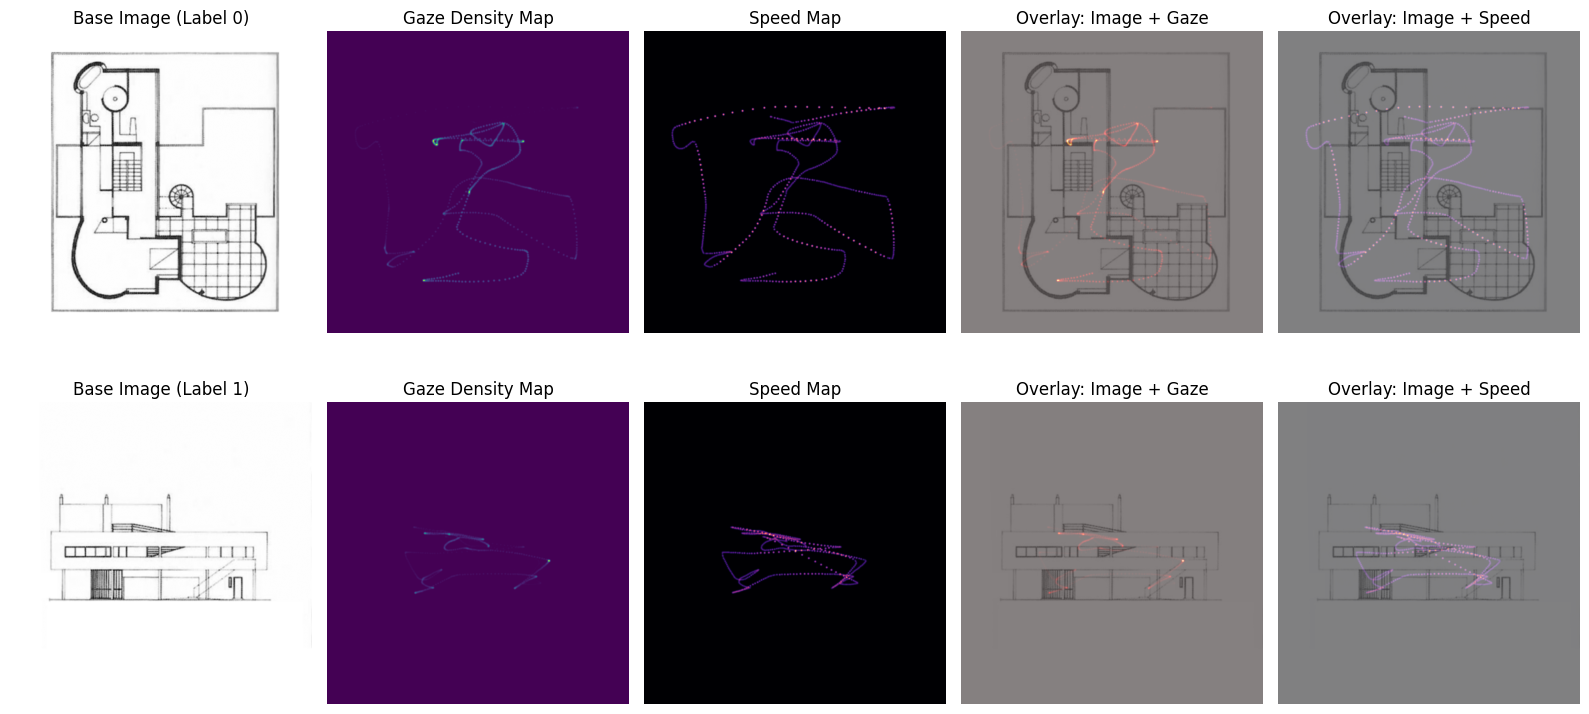

In [156]:
# =====================================================
# 6.2 VISUALIZE SAMPLE (IMAGE + CSV) 3 channels
# =====================================================
BATCH_SIZE = 2
RESIZE_TO_540 = True

dataset = build_dataset_3ch(image_paths, gaze_csv_paths, label_ids,
                            batch_size=BATCH_SIZE, resize_to_540=RESIZE_TO_540)

# Peek and visualize all three channels
for X, y in dataset.take(1):
    print("Batch X:", X.shape)  # (B, 540, 540, 3)
    print("Batch y:", y.numpy())  # e.g. [0, 1]

    batch_size = X.shape[0]
    fig, axes = plt.subplots(nrows=batch_size, ncols=5, figsize=(16, 4 * batch_size))

    if batch_size == 1:
        axes = axes[np.newaxis, :]  # make iterable if one sample

    for i in range(batch_size):
        img   = X[i, ..., 0].numpy()
        gaze  = X[i, ..., 1].numpy()
        speed = X[i, ..., 2].numpy()
        label = y[i].numpy()

        # --- Individual channels ---
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Base Image (Label {label})")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gaze, cmap='viridis')
        axes[i, 1].set_title("Gaze Density Map")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(speed, cmap='magma')
        axes[i, 2].set_title("Speed Map")
        axes[i, 2].axis('off')

        # --- Overlays ---
        axes[i, 3].imshow(img, cmap='gray', alpha=0.5)
        axes[i, 3].imshow(gaze, cmap='hot', alpha=0.5)
        axes[i, 3].set_title("Overlay: Image + Gaze")
        axes[i, 3].axis('off')

        axes[i, 4].imshow(img, cmap='gray', alpha=0.5)
        axes[i, 4].imshow(speed, cmap='inferno', alpha=0.5)
        axes[i, 4].set_title("Overlay: Image + Speed")
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

In [46]:
for X, y in build_dataset_3ch(image_paths, gaze_csv_paths, label_ids, batch_size=2).take(1):
    logits = model(X)            # should run
    print("logits:", logits.shape)

logits: (2, 3)


logits: (2, 3)
Grouper output: (2, 540, 540, 4)
Learned speed centers μ: [0.5 0.5 0.5]
Learned widths σ: [0.3143 0.3143 0.3143]


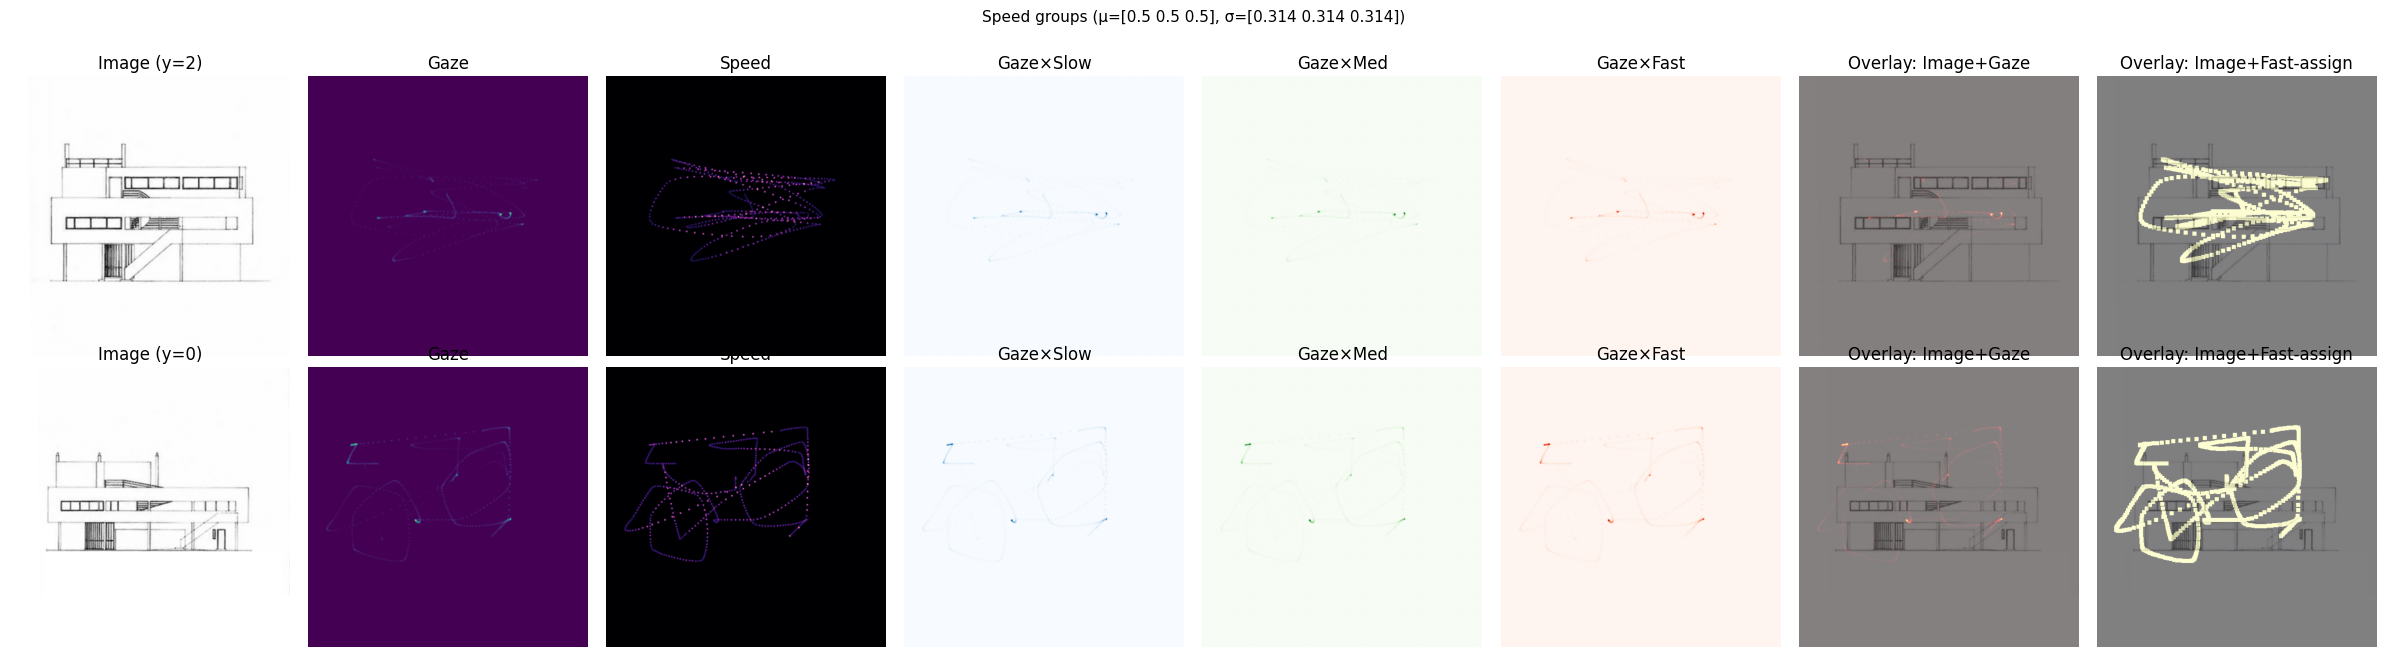

In [48]:


# 1) Locate the grouping layer and build a submodel that outputs it
def get_grouper_layer(m):
    # Prefer name; otherwise find by class name
    for L in m.layers:
        if L.name == "gaze_speed_grouper":
            return L
    # Fallback: search by class name string (works even across reloads)
    for L in m.layers:
        if L.__class__.__name__ == "GazeSpeedGrouper":
            return L
    raise ValueError("GazeSpeedGrouper layer not found in model.")

grouper = get_grouper_layer(model)
grouper_out_model = tf.keras.Model(inputs=model.input, outputs=grouper.output)

# 2) Run one batch through both the model and the grouper output
for X, y in build_dataset_3ch(image_paths, gaze_csv_paths, label_ids, batch_size=2).take(1):
    logits = model(X)
    print("logits:", logits.shape)

    G = grouper_out_model(X, training=False)  # shape: (B, H, W, 1+K[+1 if keep_speed])
    G = G.numpy()
    B, H, W, Cg = G.shape
    print("Grouper output:", G.shape)

    # Determine K and whether keep_speed=True by inspecting channel count
    # G = [img, groups... , (optional speed)]
    # Try K = Cg-1 first; if not 3, assume keep_speed=True and set K=Cg-2
    K = Cg - 1
    keep_speed = False
    if K != 3:
        K = Cg - 2
        keep_speed = True
    assert K == 3, f"Expected 3 groups; inferred K={K} from shape {G.shape}"

    # Pull learned parameters (centers and widths)
    mu   = tf.sigmoid(grouper.mu_unconstrained).numpy()
    sigma= (tf.nn.softplus(grouper.log_sigma) + 1e-3).numpy()
    print("Learned speed centers μ:", np.round(mu, 4))
    print("Learned widths σ:", np.round(sigma, 4))

    # 3) Visualize per-sample
    # Columns:
    # 0: Base image, 1: Gaze, 2: Speed, 3..5: Gaze×(Slow/Med/Fast), 6..7 overlays
    ncols = 8
    fig, axes = plt.subplots(nrows=B, ncols=ncols, figsize=(3.0*ncols, 3.2*B))
    if B == 1:
        axes = axes[np.newaxis, :]

    for i in range(B):
        img   = X[i, ..., 0].numpy()
        gaze  = X[i, ..., 1].numpy()
        speed = X[i, ..., 2].numpy()
        img_g = G[i, ..., 0]
        slow  = G[i, ..., 1]
        med   = G[i, ..., 2]
        fast  = G[i, ..., 3]
        # If keep_speed=True and there is an appended speed channel:
        if keep_speed:
            speed_g = G[i, ..., -1]  # not used below, but available

        # Optionally derive *soft assignment* maps (approx):
        eps = 1e-8
        assign_slow = slow / (gaze + eps)
        assign_med  = med  / (gaze + eps)
        assign_fast = fast / (gaze + eps)

        # Row i
        axes[i,0].imshow(img, cmap='gray');      axes[i,0].set_title(f"Image (y={y[i].numpy()})"); axes[i,0].axis('off')
        axes[i,1].imshow(gaze, cmap='viridis');  axes[i,1].set_title("Gaze");                      axes[i,1].axis('off')
        axes[i,2].imshow(speed, cmap='magma');   axes[i,2].set_title("Speed");                     axes[i,2].axis('off')

        axes[i,3].imshow(slow, cmap='Blues');    axes[i,3].set_title("Gaze×Slow");                 axes[i,3].axis('off')
        axes[i,4].imshow(med,  cmap='Greens');   axes[i,4].set_title("Gaze×Med");                  axes[i,4].axis('off')
        axes[i,5].imshow(fast, cmap='Reds');     axes[i,5].set_title("Gaze×Fast");                 axes[i,5].axis('off')

        # Overlays for quick sanity
        axes[i,6].imshow(img, cmap='gray', alpha=0.6)
        axes[i,6].imshow(gaze, cmap='hot', alpha=0.5);            axes[i,6].set_title("Overlay: Image+Gaze"); axes[i,6].axis('off')
        axes[i,7].imshow(img, cmap='gray', alpha=0.6)
        axes[i,7].imshow(assign_fast, cmap='inferno', alpha=0.5); axes[i,7].set_title("Overlay: Image+Fast-assign"); axes[i,7].axis('off')

    plt.suptitle(f"Speed groups (μ={np.round(mu,3)}, σ={np.round(sigma,3)})", y=1.02, fontsize=11)
    plt.tight_layout()
    plt.show()


### Alternative: Non-Learnable Speed Group Layer

In [131]:

def _ppd_from_geometry(screen_w_px, screen_h_px, screen_w_cm, screen_h_cm, view_dist_cm):
    """Pixels-per-degree (PPD); average of horizontal/vertical."""
    pi = tf.constant(3.141592653589793, tf.float32)
    rad2deg = 180.0 / pi
    deg_w = 2.0 * tf.atan((screen_w_cm / 2.0) / view_dist_cm) * rad2deg
    deg_h = 2.0 * tf.atan((screen_h_cm / 2.0) / view_dist_cm) * rad2deg
    ppd_w = tf.cast(screen_w_px, tf.float32) / deg_w
    ppd_h = tf.cast(screen_h_px, tf.float32) / deg_h
    return (ppd_w + ppd_h) / 2.0

class SpeedAngleHardGrouper(layers.Layer):
    """
    Input : (B,H,W,3) -> [image, gaze, speed]  (speed in px/sample or px/s or normalized [0,1])
    Output: (B,H,W,1+3[+1 if keep_ang_speed]) -> [image, gaze_slow, gaze_med, gaze_fast(, ang_speed)]

    IMPORTANT:
    - If the incoming speed channel is *already normalized to [0,1]*, this layer
      will auto-detect that and interpret T1_deg_per_s / T2_deg_per_s (and edge_softness)
      as *fractions in [0,1]*, skipping any geometry conversion.
    - Otherwise, it uses your declared `speed_unit` ("px_per_sample" or "px_per_sec")
      and converts to deg/s via your screen geometry before thresholding.
    """

    def __init__(self,
                 screen_w_px, screen_h_px,
                 screen_w_cm, screen_h_cm,
                 viewing_distance_cm,
                 sample_rate_hz=60.0,
                 speed_unit="px_per_sample",   # "px_per_sample" or "px_per_sec"
                 T1_deg_per_s=1.0,             # slow/medium boundary (deg/s OR fraction if normalized input)
                 T2_deg_per_s=30.0,            # medium/fast boundary (deg/s OR fraction if normalized input)
                 mode="hard",                  # "hard" or "soft"
                 edge_softness_deg_per_s=0.5,  # softness in deg/s OR fraction if normalized input
                 keep_ang_speed=False,         # append ang_speed (or normalized speed) channel for debugging
                 name="speed_angle_hard_grouper",
                 **kw):
        super().__init__(name=name, **kw)
        assert speed_unit in ("px_per_sample", "px_per_sec")
        assert mode in ("hard", "soft")
        self.screen_w_px = float(screen_w_px)
        self.screen_h_px = float(screen_h_px)
        self.screen_w_cm = float(screen_w_cm)
        self.screen_h_cm = float(screen_h_cm)
        self.viewing_distance_cm = float(viewing_distance_cm)
        self.sample_rate_hz = float(sample_rate_hz)
        self.speed_unit = speed_unit
        self.T1 = float(T1_deg_per_s)
        self.T2 = float(T2_deg_per_s)
        self.mode = mode
        self.edge_softness = float(edge_softness_deg_per_s)
        self.keep_ang_speed = bool(keep_ang_speed)

    def build(self, input_shape):
        # Precompute PPD as a non-trainable constant (used when we need deg/s)
        self.ppd = _ppd_from_geometry(
            self.screen_w_px, self.screen_h_px,
            self.screen_w_cm, self.screen_h_cm,
            self.viewing_distance_cm
        )
        self.ppd = tf.convert_to_tensor(self.ppd, dtype=tf.float32)
        super().build(input_shape)

    @staticmethod
    def _sanitize_speed(s):
        """Replace NaN/Inf with 0 and clamp negatives to 0."""
        s = tf.where(tf.math.is_finite(s), s, tf.zeros_like(s))
        return tf.maximum(s, 0.0)

    def call(self, x):
        # channels: 0=image, 1=gaze, 2=speed
        img   = x[..., 0:1]
        gaze  = x[..., 1:2]
        speed = x[..., 2:3]

        tf.print("speed Min",  tf.reduce_min(speed), "speed max", tf.reduce_max(speed))

        # Basic cleaning
        speed = self._sanitize_speed(speed)

        # --- Auto-detect normalized [0,1] speed input ---
        # If max <= 1.0001 and min >= -1e-6, treat as normalized ∈ [0,1].
        s_min = tf.reduce_min(speed)
        s_max = tf.reduce_max(speed)
        is_normalized = tf.logical_and(
            tf.less_equal(s_max, 1.0001),
            tf.greater_equal(s_min, -1e-6)
        )
        tf.print(is_normalized)

        def _speed_in_deg_per_s():
            # Convert to px/s if needed
            speed_pxps = tf.where(
                tf.constant(self.speed_unit == "px_per_sample"),
                speed * self.sample_rate_hz,   # px/sample -> px/s
                speed                           # already px/s
            )
            # Convert to deg/s: (px/s) / (px/deg)
            ang = speed_pxps / self.ppd
            return self._sanitize_speed(ang)

        # If normalized, use as-is (in [0,1]); else convert to deg/s
        speed_domain = tf.where(is_normalized, speed, _speed_in_deg_per_s())

        # Choose thresholds/softness according to domain
        T1 = tf.where(is_normalized,
                      tf.clip_by_value(tf.cast(self.T1, tf.float32), 0.0, 1.0),
                      tf.cast(self.T1, tf.float32))
        T2 = tf.where(is_normalized,
                      tf.clip_by_value(tf.cast(self.T2, tf.float32), 0.0, 1.0),
                      tf.cast(self.T2, tf.float32))
        softness = tf.where(is_normalized,
                            tf.clip_by_value(tf.cast(self.edge_softness, tf.float32), 1e-6, 1.0),
                            tf.maximum(tf.cast(self.edge_softness, tf.float32), 1e-6))

        # Masks
        if self.mode == "hard":
            slow_mask = tf.cast(speed_domain <  T1, tf.float32)
            med_mask  = tf.cast((speed_domain >= T1) & (speed_domain < T2), tf.float32)
            fast_mask = tf.cast(speed_domain >= T2, tf.float32)
        else:
            # Soft transitions: sigmoid edges around T1/T2
            k = 1.0 / softness  # larger k -> sharper
            s_low  = tf.sigmoid((T1 - speed_domain) * k)   # below T1
            s_fast = tf.sigmoid((speed_domain - T2) * k)   # above T2
            slow_mask = s_low
            fast_mask = s_fast
            med_mask  = tf.clip_by_value(1.0 - slow_mask - fast_mask, 0.0, 1.0)

        gaze_slow = gaze * slow_mask
        gaze_med  = gaze * med_mask
        gaze_fast = gaze * fast_mask

        out = tf.concat([img, gaze_slow, gaze_med, gaze_fast], axis=-1)
        if self.keep_ang_speed:
            # Append the domain we actually thresholded on:
            # - if normalized input: this is the normalized speed
            # - else: this is angular speed in deg/s
            out = tf.concat([out, speed_domain], axis=-1)

        return out

    # Good practice for saving/loading
    def get_config(self):
        return {
            "screen_w_px": self.screen_w_px,
            "screen_h_px": self.screen_h_px,
            "screen_w_cm": self.screen_w_cm,
            "screen_h_cm": self.screen_h_cm,
            "viewing_distance_cm": self.viewing_distance_cm,
            "sample_rate_hz": self.sample_rate_hz,
            "speed_unit": self.speed_unit,
            "T1_deg_per_s": self.T1,
            "T2_deg_per_s": self.T2,
            "mode": self.mode,
            "edge_softness_deg_per_s": self.edge_softness,
            "keep_ang_speed": self.keep_ang_speed,
            "name": self.name,
        }


In [147]:
#Experiment Setting Variables:
imageHeight = 1024 #pixel

distanceToScreen = 56 #cm
fovealVisionDegree = 2 #degrees
screenHeightCm = 19.5 # cm
screenHeightPixel = 1080
screenWidthPixel = 1920
deltaTime = 1/60 # seconds
saccadeThreshold = 375 # milliseconds

height_unity_game_area = 17 #cm
width_unity_game_area = 33 #cm

visual_angle_saccade_threshold = 40

lower_speed_bound = 0.2
upper_speed_bound = 0.6

In [148]:
def build_vq_classifier_540_fix_behavior(
    num_classes,
    num_codes=512, code_dim=128, beta=0.25, base=64, dropout=0.25,
    # geometry for angular-speed conversion:
    screen_w_px=1920, screen_h_px=1080,
    screen_w_cm=52.0, screen_h_cm=29.0,
    viewing_distance_cm=60.0,
    sample_rate_hz=60.0,
    T1_deg_per_s=lower_speed_bound, T2_deg_per_s=upper_speed_bound,
    speed_unit="px_per_sample",
):
    """inputs = keras.Input(shape=(None, None, 3), name="inputs")  # [img, gaze, speed]

    x = SpeedAngleHardGrouper(
        screen_w_px=screen_w_px, screen_h_px=screen_h_px,
        screen_w_cm=screen_w_cm, screen_h_cm=screen_h_cm,
        viewing_distance_cm=viewing_distance_cm,
        sample_rate_hz=sample_rate_hz,
        speed_unit=speed_unit,
        T1_deg_per_s=T1_deg_per_s, T2_deg_per_s=T2_deg_per_s,
        name="speed_angle_hard_grouper"
    )(inputs)"""

    # Input: (B,540,540,3) = [image, gaze, speed]
    inputs = tf.keras.Input(shape=(540, 540, 3), name="inputs")

    x = SpeedAngleHardGrouper(
        screen_w_px=screen_w_px, screen_h_px=screen_h_px,
        screen_w_cm=screen_w_cm, screen_h_cm=screen_h_cm,
        viewing_distance_cm=viewing_distance_cm,
        sample_rate_hz=sample_rate_hz,
        speed_unit="px_per_sample",   # or "px_per_sec" if your ch-2 is already px/s
        T1_deg_per_s=lower_speed_bound, T2_deg_per_s=upper_speed_bound,
        mode="hard",                  # or "soft" for smooth edges
        edge_softness_deg_per_s=0.75,
        keep_ang_speed=False
    )(inputs)

    # x now has 4 channels: [img, slow, med, fast]
    # pass to your encoder expecting in_ch=4


    # Now encoder sees [image, gaze_slow, gaze_med, gaze_fast] => 4 channels
    encoder = build_encoder_v2(in_ch=4, base=base, code_dim=code_dim, norm='gn',
                               depths=(2,2,3), drop_path_rate=0.1, dilations=(1,1,2), use_se=True)
    z_e = encoder(x)

    vq = VectorQuantizer(num_codes=num_codes, code_dim=code_dim, beta=beta, name="vq")
    z_q, _ = vq(z_e)

    head = build_classifier_head(num_classes, feature_dim=code_dim, dropout=dropout)
    logits = head(z_q)
    return keras.Model(inputs, logits, name="vq_classifier_540_fix_behavior")


In [149]:
# Build a *separate* model using hard-coded groups
model_hard = build_vq_classifier_540_fix_behavior(
    num_classes=len(class_names),
    num_codes=512, code_dim=128, beta=0.25, base=64, dropout=0.25,
    # Set YOUR lab geometry + thresholds here:
    screen_w_px=screenWidthPixel, screen_h_px=screenHeightPixel,
    screen_w_cm=width_unity_game_area, screen_h_cm=height_unity_game_area,
    viewing_distance_cm=distanceToScreen,
    sample_rate_hz=60.0,
    speed_unit="px_per_sample",     # or "px_per_sec" if your speed is already px/s
    T1_deg_per_s=lower_speed_bound, T2_deg_per_s=upper_speed_bound
)

# Forward pass sanity check
for X, y in build_dataset_3ch(image_paths, gaze_csv_paths, label_ids, batch_size=2).take(1):
    logits = model_hard(X)
    print("logits:", logits.shape)   # (B, num_classes)

# Compile/train (example)
model_hard.compile(optimizer=keras.optimizers.Adam(2e-4),
                   loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=["accuracy"])
# model_hard.fit(train_ds_3ch, validation_data=val_ds_3ch, epochs=... )


speed Min 0 speed max 0.857937217
1
logits: (2, 3)


speed Min 0 speed max 0.884857178
1


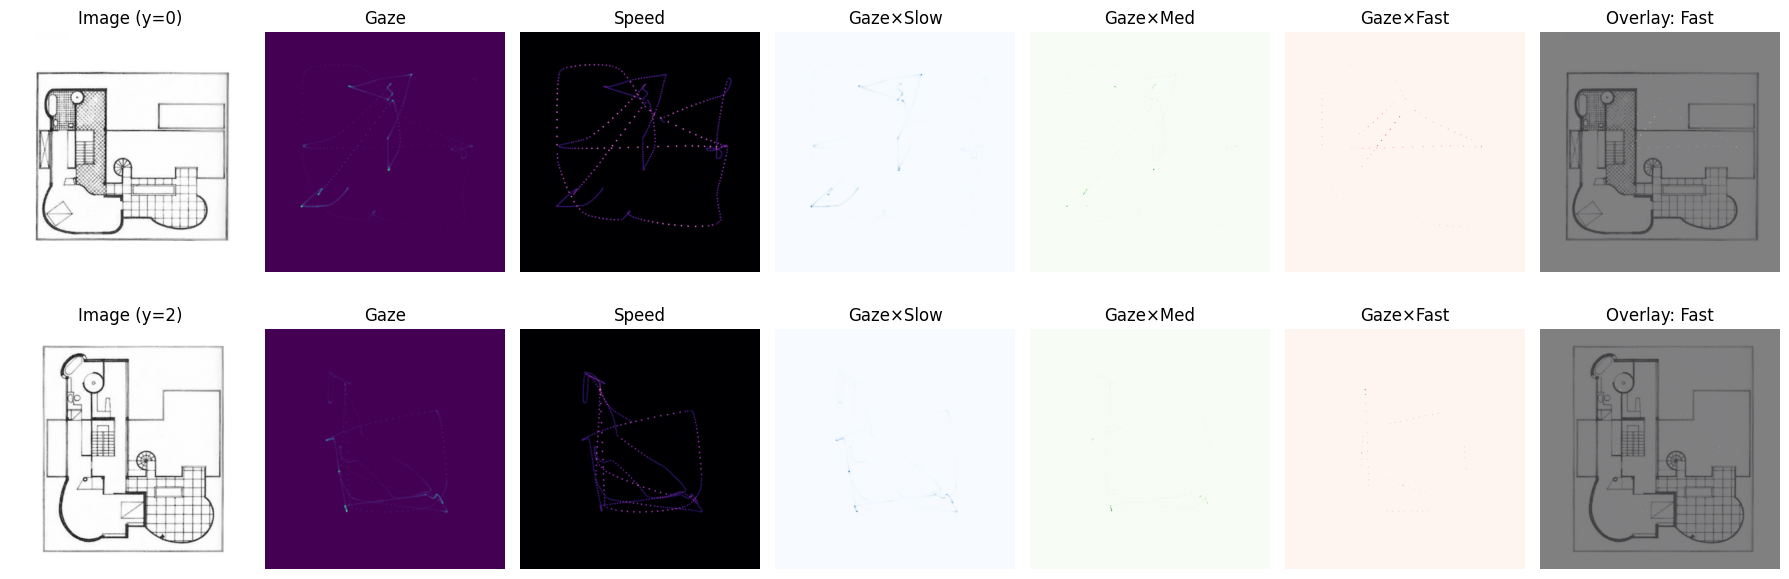

In [157]:
# Submodel to fetch the grouper output
grouper_out = tf.keras.Model(model_hard.input,
                             model_hard.get_layer("speed_angle_hard_grouper").output)

for X, y in build_dataset_3ch(image_paths, gaze_csv_paths, label_ids, batch_size=2).take(1):
    G = grouper_out(X)  # (B,H,W,4) = [img, slow, med, fast]

    import numpy as np, matplotlib.pyplot as plt
    B = X.shape[0]
    fig, axes = plt.subplots(B, 7, figsize=(18, 3.2*B))
    if B == 1: axes = axes[np.newaxis, :]

    for i in range(B):
        img, gaze, speed = X[i,...,0].numpy(), X[i,...,1].numpy(), X[i,...,2].numpy()
        slow, med, fast  = G[i,...,1].numpy(), G[i,...,2].numpy(), G[i,...,3].numpy()

        axes[i,0].imshow(img, cmap='gray');     axes[i,0].set_title(f"Image (y={y[i].numpy()})"); axes[i,0].axis('off')
        axes[i,1].imshow(gaze, cmap='viridis'); axes[i,1].set_title("Gaze");  axes[i,1].axis('off')
        axes[i,2].imshow(speed, cmap='magma');  axes[i,2].set_title("Speed"); axes[i,2].axis('off')
        axes[i,3].imshow(slow, cmap='Blues');   axes[i,3].set_title("Gaze×Slow"); axes[i,3].axis('off')
        axes[i,4].imshow(med,  cmap='Greens');  axes[i,4].set_title("Gaze×Med");  axes[i,4].axis('off')
        axes[i,5].imshow(fast, cmap='Reds');    axes[i,5].set_title("Gaze×Fast"); axes[i,5].axis('off')

        axes[i,6].imshow(img, cmap='gray', alpha=0.6)
        axes[i,6].imshow(fast, cmap='inferno', alpha=0.5); axes[i,6].set_title("Overlay: Fast"); axes[i,6].axis('off')

    plt.tight_layout(); plt.show()


# Training

Make Training and Validation Sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_and_build_datasets(
    image_paths, gaze_csv_paths, label_ids,
    val_size=0.2, seed=42,
    batch_size=2, resize_to_540=True,
    stratify=True
):
    # --- split lists (keeps them aligned) ---
    strat = label_ids if stratify else None
    (train_imgs, val_imgs,
     train_csvs, val_csvs,
     train_labs, val_labs) = train_test_split(
        image_paths, gaze_csv_paths, label_ids,
        test_size=val_size, random_state=seed, stratify=strat
    )

    # --- build datasets with your function ---
    train_ds = build_dataset(
        train_imgs, train_csvs, train_labs,
        batch_size=batch_size, shuffle=True, resize_to_540=resize_to_540
    )
    val_ds = build_dataset(
        val_imgs, val_csvs, val_labs,
        batch_size=batch_size, shuffle=False, resize_to_540=resize_to_540
    )

    # Optional: quick stats
    def _dist(lbls):
        u, c = np.unique(lbls, return_counts=True); return dict(zip(u, c))
    print(f"Train samples: {len(train_imgs)}  | class dist: {_dist(train_labs)}")
    print(f"Val   samples: {len(val_imgs)}    | class dist: {_dist(val_labs)}")

    return train_ds, val_ds, (train_imgs, train_csvs, train_labs), (val_imgs, val_csvs, val_labs)

In [ ]:
BATCH_SIZE = 2
RESIZE_TO_540 = True   # <-- dataset already downscales to 540×540×2
train_ds, val_ds, train_split, val_split = split_and_build_datasets(
    image_paths, gaze_csv_paths, label_ids,
    val_size=0.2, seed=42,
    batch_size=BATCH_SIZE, resize_to_540=RESIZE_TO_540, stratify=True
)

# Peek a batch
for X, y in train_ds.take(1):
    print("train:", X.shape, y.numpy())
for X, y in val_ds.take(1):
    print("val:", X.shape, y.numpy())

Train samples: 38  | class dist: {np.int64(0): np.int64(13), np.int64(1): np.int64(13), np.int64(2): np.int64(12)}
Val   samples: 10    | class dist: {np.int64(0): np.int64(3), np.int64(1): np.int64(3), np.int64(2): np.int64(4)}
train: (2, 540, 540, 2) [2 2]
val: (2, 540, 540, 2) [0 2]


#Visualize Some Data with Labels


In [ ]:
# Map your numeric ids to names
id_to_label = {0: "Shape", 1: "Circulation", 2: "Hierarchy"}

def _to_numpy(x):
    x = x.numpy() if isinstance(x, tf.Tensor) else x
    return np.asarray(x)

def show_samples(ds, n=6, cols=3, gaze_alpha=0.55, save_path=None):
    """
    ds: a tf.data.Dataset yielding (X, y), where X is (H,W,2) or (B,H,W,2)
    n:  number of samples to show
    cols: grid columns
    gaze_alpha: transparency for gaze overlay
    save_path: optional path to save the grid figure
    """
    # Collect n samples (unbatch to simplify)
    samples = []
    for X, y in ds.unbatch().take(n):
        samples.append((X, y))
    if not samples:
        print("Dataset seems empty.")
        return

    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])

    for i, (X, y) in enumerate(samples):
        ax = axes[i // cols, i % cols]
        X = _to_numpy(X)   # (H, W, 2)
        y = int(_to_numpy(y))

        # Split channels: 0=image (grayscale), 1=gaze (heatmap)
        img  = X[..., 0]
        gaze = X[..., 1]
        # Scatter
        x_s = gaze[:, 0]
        y_s = gaze[:, 1]
        t_s = gaze[:, 2]

        # Ensure in [0,1] for display
        img  = np.clip(img,  0.0, 1.0)
        gaze = np.clip(gaze, 0.0, 1.0)

        # Draw background image
        ax.imshow(img, cmap='grey', alpha=0.2, interpolation='nearest')
        # Overlay gaze heatmap
        hm = ax.imshow(gaze, cmap='viridis', alpha=gaze_alpha, interpolation='nearest')



        plt.colorbar(hm, ax=ax, fraction=0.025, pad=0.01, label='Normalized time')

        ax.set_title(f"{id_to_label.get(y, str(y))}", fontsize=12)
        ax.axis('off')

    # Remove any extra axes
    for j in range(i+1, rows*cols):
        axes[j // cols, j % cols].axis('off')

    # Colorbar (optional: for the last heatmap handle)
    cbar = fig.colorbar(hm, ax=axes.ravel().tolist(), shrink=0.6, pad=0.01)
    cbar.set_label("Gaze intensity", rotation=90)

    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0)
        print(f"Saved to {save_path}")
    plt.show()


/tmp/ipython-input-1026170856.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


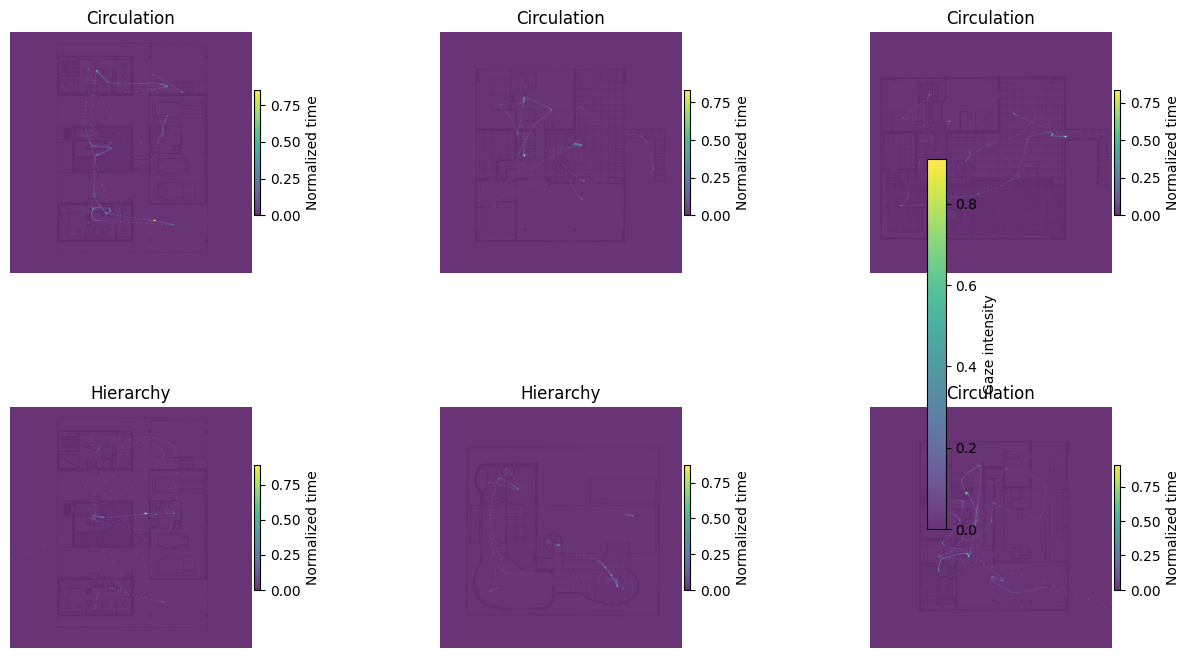

In [ ]:
# Show 6 random training samples
show_samples(train_ds, n=6, cols=3, gaze_alpha=0.8)

# Show 8 validation samples and save the grid
# show_samples(val_ds, n=8, cols=4, gaze_alpha=0.55, save_path="val_preview.png")


Fit Model

In [ ]:
from collections import Counter

In [ ]:
# label_ids is your full list of ints for all samples before splitting
counts = Counter(label_ids)
total = sum(counts.values())
class_weight = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}
print("class_weight:", class_weight)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    "best_vq_classifier.h5", monitor="val_accuracy",
    save_best_only=True, save_weights_only=False
)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True
)

class_weight: {0: 1.0, 2: 1.0, 1: 1.0}


In [ ]:
history = model_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[ckpt, plateau, early],
    class_weight=class_weight  # remove this arg if you don't want weighting
)


Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3822 - loss: 2.0920

19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 545ms/step - accuracy: 0.3789 - loss: 2.0844 - val_accuracy: 0.4000 - val_loss: 1.5541 - learning_rate: 3.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.3463 - loss: 1.5690 - val_accuracy: 0.3000 - val_loss: 1.4005 - learning_rate: 3.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.2730 - loss: 1.6075 - val_accuracy: 0.3000 - val_loss: 1.3825 - learning_rate: 3.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.3766 - loss: 1.4007 - val_accuracy: 0.4000 - val_loss: 1.2248 - learning_rate: 3.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.2388 - loss: 1.3731 - val_accuracy: 0.3000 - val_loss: 1.2334 - learning_rate: 3.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.3685 - loss: 1.3178 - val_accuracy: 0.3000 - val_loss: 1.3180 - learning_rate: 3.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4565 - loss: 1

In [ ]:
history = model_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ckpt, plateau, early],
    class_weight=class_weight  # remove this arg if you don't want weighting
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 533ms/step - accuracy: 0.3668 - loss: 1.9915 - val_accuracy: 0.3000 - val_loss: 1.5406 - learning_rate: 3.0000e-04
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.2269 - loss: 1.6181 - val_accuracy: 0.3000 - val_loss: 1.5328 - learning_rate: 3.0000e-04
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3991 - loss: 1.5059 - val_accuracy: 0.3000 - val_loss: 1.4302 - learning_rate: 3.0000e-04
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3427 - loss: 1.5061 - val_accuracy: 0.4000 - val_loss: 1.3422 - learning_rate: 3.0000e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4178 - loss: 1.3979 - val_accuracy: 0.3000 - val_loss: 1.4254 - learning_rate: 3.0000e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.4462 - loss: 1.5238 - val_accuracy: 0.3000 - val_loss: 1.3771 - learning_rate: 3.0000e-04
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.461

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4898 - loss: 1.1377 - val_accuracy: 0.5000 - val_loss: 1.2265 - learning_rate: 3.0000e-04
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3112 - loss: 1.3182 - val_accuracy: 0.3000 - val_loss: 1.2256 - learning_rate: 3.0000e-04


## Show validation Samples : Probability Distribution

In [ ]:
def collect_val_predictions(model, val_data, max_batches=None):
    """
    Returns:
      probs: (N, C) softmax probabilities
      y_true: (N,) integer labels
      x_keep: (N, H, W, C_in) first channel(s) for optional visualization
    Works with:
      - tf.data.Dataset yielding (x, y)
      - (x_val, y_val) numpy tuples
    """
    all_probs, all_y, all_x = [], [], []

    def _predict_on_arrays(x_val, y_val):
        p = model.predict(x_val, verbose=0)
        return p, y_val, x_val

    if isinstance(val_data, tf.data.Dataset):
        for b, (x, y) in enumerate(val_data):
            if max_batches is not None and b >= max_batches:
                break
            p = model.predict(x, verbose=0)
            all_probs.append(p)
            all_y.append(y.numpy() if hasattr(y, "numpy") else y)
            all_x.append(x.numpy() if hasattr(x, "numpy") else x)
        probs = np.concatenate(all_probs, axis=0)
        y_true = np.concatenate(all_y, axis=0)
        x_keep = np.concatenate(all_x, axis=0)
    else:
        x_val, y_val = val_data
        probs, y_true, x_keep = _predict_on_arrays(x_val, y_val)

    # ensure softmax-like
    if probs.ndim != 2:
        raise ValueError(f"Expected (N, C) probabilities, got shape {probs.shape}")

    return probs, y_true, x_keep


In [ ]:


def show_samples_with_prob_bars(x, probs, y_true, class_names,
                                n_samples=8, start_index=0,
                                figsize=(10, 3)):
    """
    Shows n_samples from start_index. For each sample:
      Left: input image (channel `show_channel`)
      Right: bars for probabilities of all classes
    """
    C = probs.shape[1]
    idxs = np.arange(start_index, min(start_index + n_samples, probs.shape[0]))

    for i in idxs:
        fig = plt.figure(figsize=figsize)

        # --- Left panels: channel 0 and 1 ---
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        img = x[i]
        if img.ndim != 3 or img.shape[-1] < 2:
            raise ValueError("Expected image with 2 channels for display")

        for ax, ch in zip((ax1, ax2), (0, 1)):
            vmin, vmax = np.percentile(img[..., ch], [1, 99])
            ax.imshow(img[..., ch], cmap="gray", vmin=vmin, vmax=vmax, interpolation="nearest")
            ax.set_title(f"Channel {ch}")
            ax.axis("off")

        # --- Right: probability bars ---
        ax3 = fig.add_subplot(1, 3, 3)
        p = probs[i]
        order = np.arange(C)
        ax3.barh(np.arange(C), p[order])
        ax3.set_yticks(np.arange(C))
        ax3.set_yticklabels([class_names[j] for j in order])
        ax3.set_xlim(0.0, 1.0)
        ax3.invert_yaxis()
        yhat = int(np.argmax(p))
        ttl = f"True: {class_names[int(y_true[i])]}\nPred: {class_names[yhat]} (p={p[yhat]:.2f})"
        ax3.set_title(ttl)
        ax3.set_xlabel("Probability")

        plt.tight_layout()
        plt.show()


Predictions shape: (10, 3)


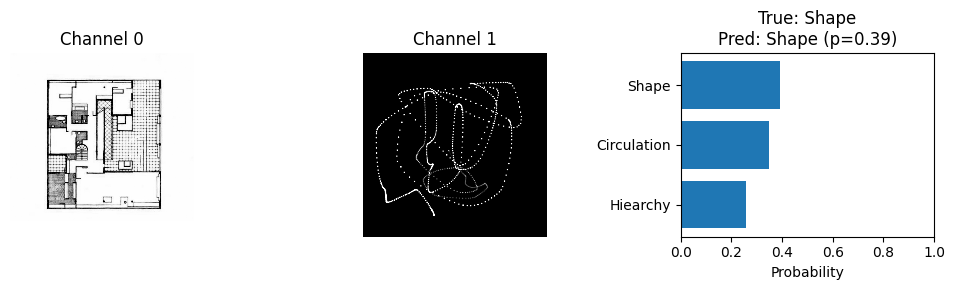

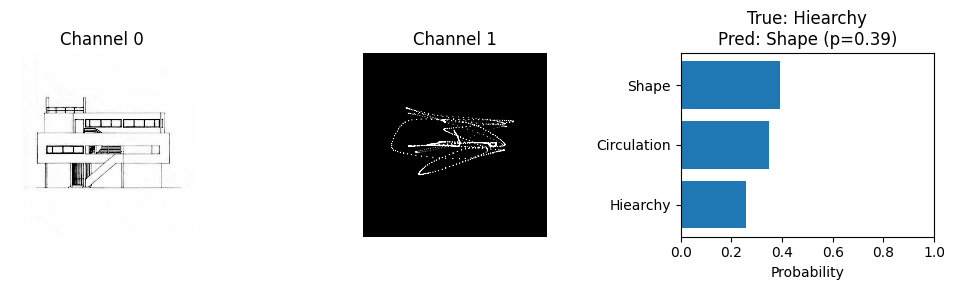

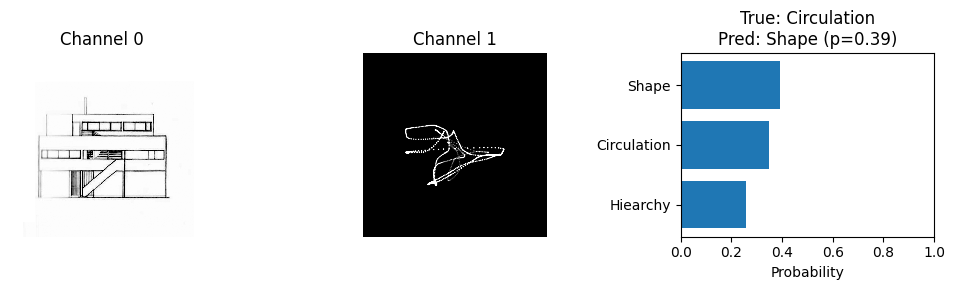

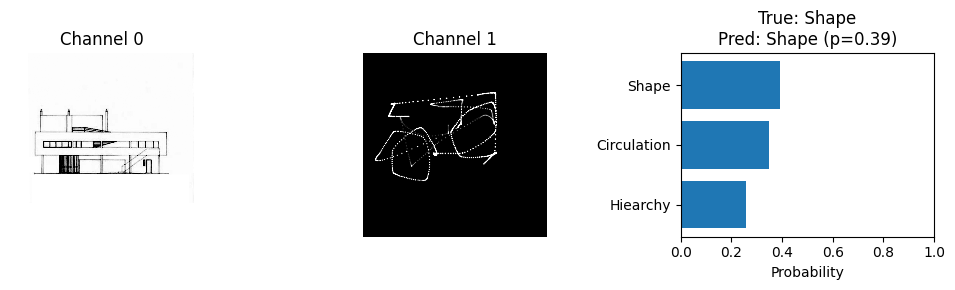

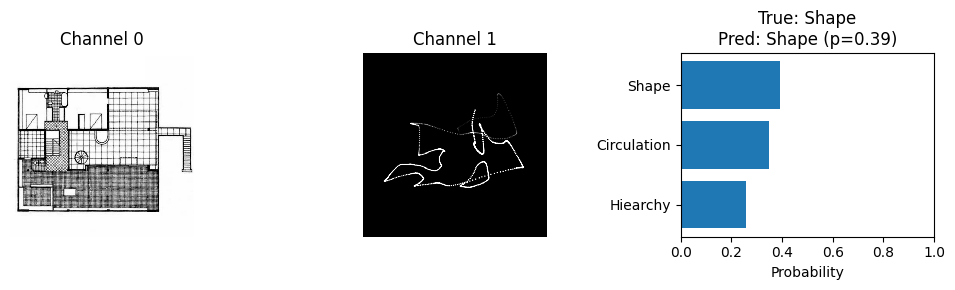

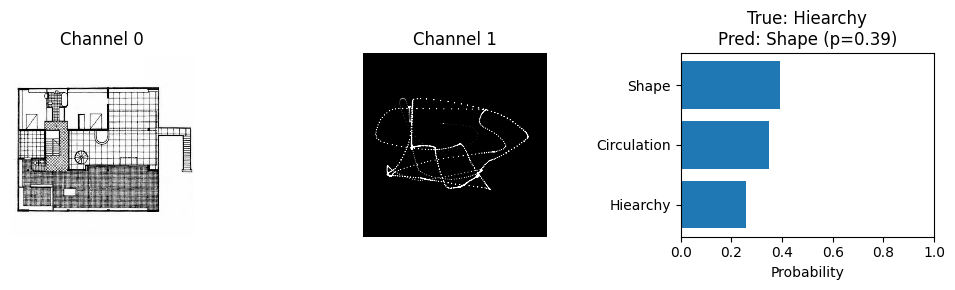

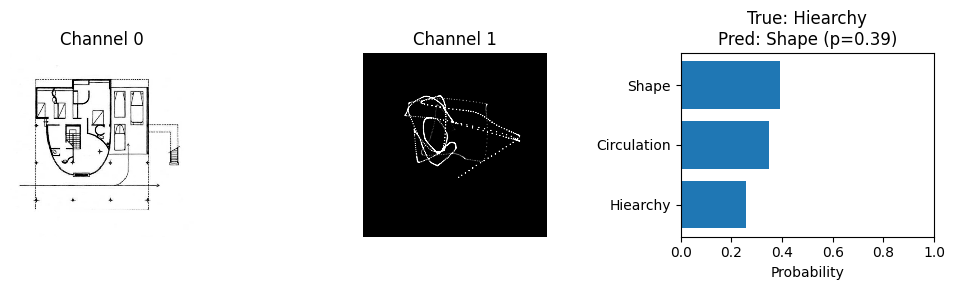

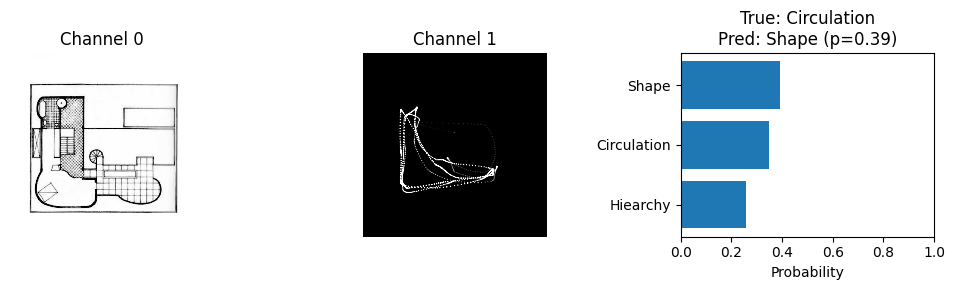

In [ ]:
class_names = ["Shape", "Circulation", "Hiearchy"]  # <-- replace with your labels

probs, y_true, x_keep = collect_val_predictions(model_v2, val_ds)
print("Predictions shape:", probs.shape)

# Show 8 samples (edit start_index to browse)
show_samples_with_prob_bars(
    x_keep, probs, y_true, class_names,
    n_samples=8, start_index=0, figsize=(10, 3)
)

Predictions shape: (10, 3)


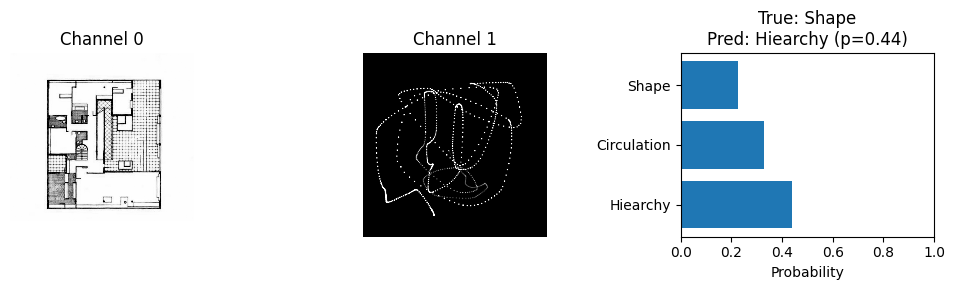

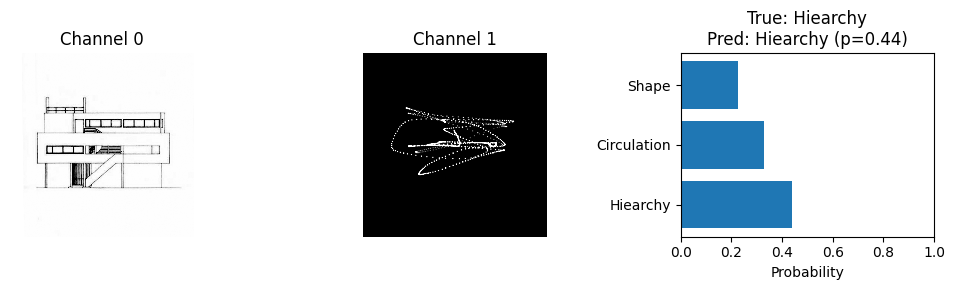

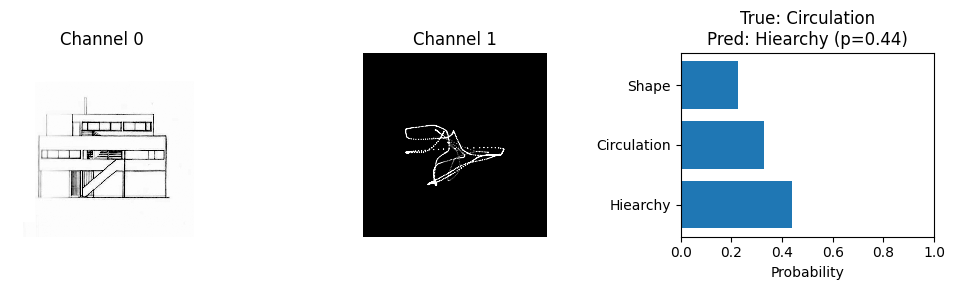

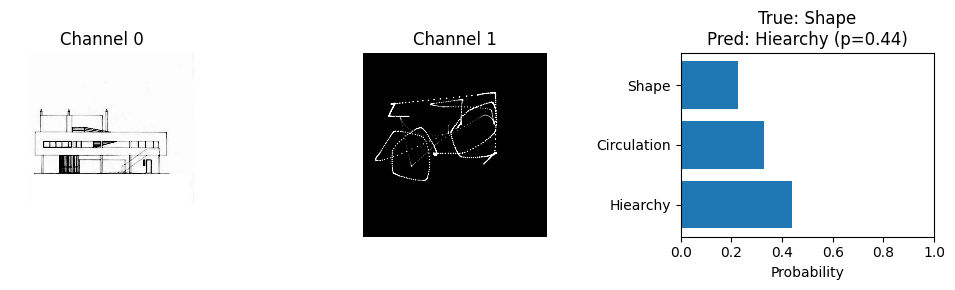

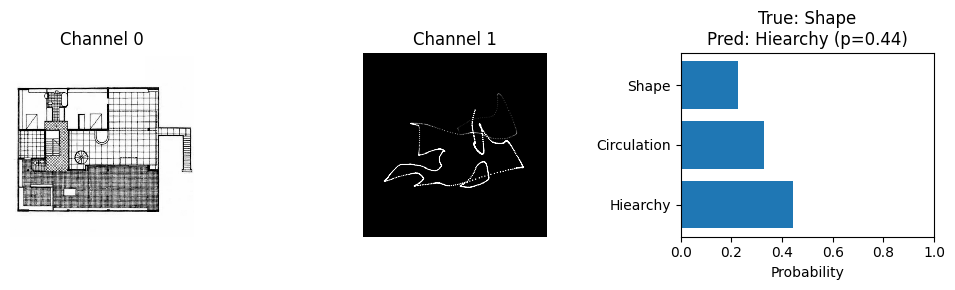

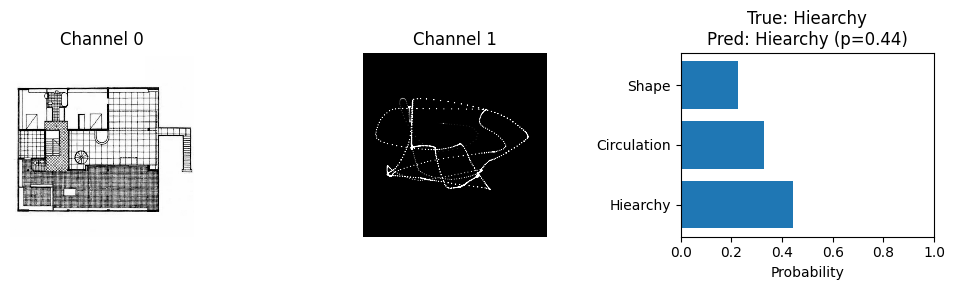

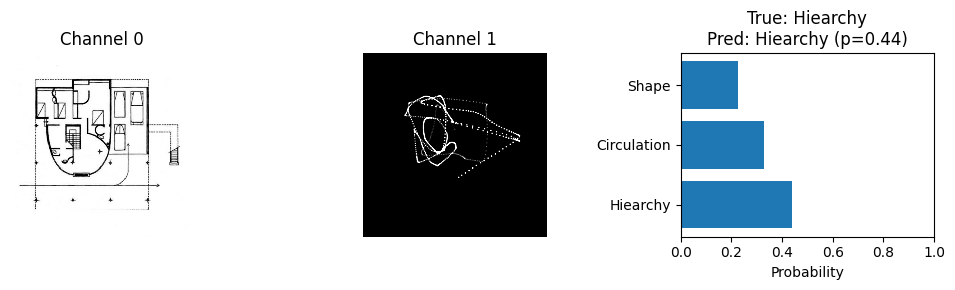

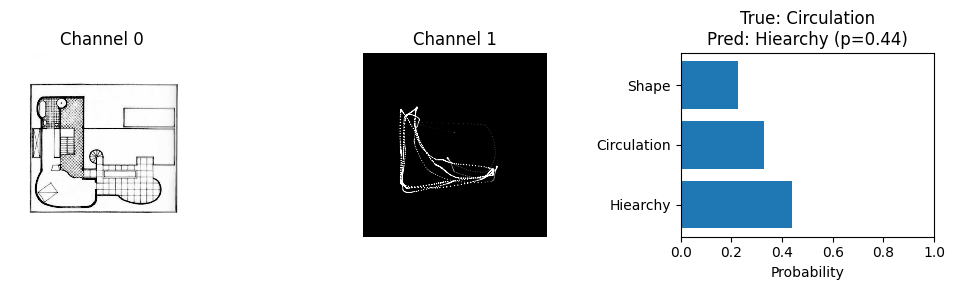

In [ ]:
class_names = ["Shape", "Circulation", "Hiearchy"]  # <-- replace with your labels

probs, y_true, x_keep = collect_val_predictions(model_v2, val_ds)
print("Predictions shape:", probs.shape)

# Show 8 samples (edit start_index to browse)
show_samples_with_prob_bars(
    x_keep, probs, y_true, class_names,
    n_samples=8, start_index=0, figsize=(10, 3)
)

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, probs, class_names, normalize=True):
    y_pred = probs.argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    if normalize:
        cm = cm.astype(np.float64) / (cm.sum(axis=1, keepdims=True) + 1e-9)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set_title("Confusion Matrix" + (" (normalized)" if normalize else ""))
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    # numbers on cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else str(cm[i, j]),
                    ha="center", va="center")

    plt.tight_layout()
    plt.show()


In [ ]:
def metrics_table(y_true, probs, topk=(1,3,5)):
    out = {}
    y_pred = probs.argmax(axis=1)
    acc = (y_pred == y_true).mean()
    out["accuracy_top1"] = float(acc)

    # top-k
    for k in topk:
        topk_idx = np.argsort(probs, axis=1)[:, ::-1][:, :k]
        topk_hit = np.any(topk_idx == y_true[:, None], axis=1).mean()
        out[f"accuracy_top{k}"] = float(topk_hit)

    # negative log-likelihood
    eps = 1e-8
    nll = -np.log(probs[np.arange(len(y_true)), y_true] + eps).mean()
    out["nll"] = float(nll)

    # expected calibration error (ECE) – simple 10-bin version
    bins = np.linspace(0, 1, 11)
    conf = probs.max(axis=1)
    correct = (y_pred == y_true).astype(np.float32)
    ece = 0.0
    for b in range(10):
        lo, hi = bins[b], bins[b+1]
        m = (conf >= lo) & (conf < hi)
        if m.any():
            bin_acc = correct[m].mean()
            bin_conf = conf[m].mean()
            ece += (m.mean()) * abs(bin_acc - bin_conf)
    out["ece_10bins"] = float(ece)
    return out


## Show validation Samples : Learned Codebook Patterns

In [ ]:


def get_encoder_and_vq(model):
    enc = model.get_layer("encoder_v2")
    # Find VectorQuantizer by class or name
    vq = None
    for l in model.layers:
        if l.__class__.__name__ == "VectorQuantizer" or l.name.startswith("vq"):
            vq = l
            break
    if vq is None:
        raise ValueError("VectorQuantizer layer not found in model")
    return enc, vq

def get_head(model):
    try:
        return model.get_layer("classifier_head")
    except:
        # Fallback: last layer(s)
        # Build a submodel that maps z_q -> logits if named head not found
        # Assumes model = end-to-end (inputs->logits). We will reuse its top from z_q shape.
        raise ValueError("classifier_head not found. Please name your head 'classifier_head'.")


In [ ]:

"""
# --- utilities that don't assume a single encoder ---

def get_pre_vq_submodel(model):
    """
    Returns a Keras Model that maps model.inputs -> z_e (pre-VQ tensor).
    Works for:
      - dual-encoder: use layer 'fuse_proj'
      - single-encoder: fall back to encoder output ('encoder' or 'encoder_v2')
    """
    # Preferred: explicit fusion/projection layer before VQ in your dual enc
    for lname in ["fuse_proj", "proj_code"]:
        try:
            lyr = model.get_layer(lname)
            return keras.Model(model.inputs, lyr.output), lname
        except:
            pass

    # Fallback: find a submodel named encoder*/ return its output
    for lname in ["encoder", "encoder_v2", "encoder_img", "encoder_gaze"]:
        try:
            enc = model.get_layer(lname)
            return keras.Model(model.inputs, enc.output), lname
        except:
            continue

    raise ValueError("Could not locate a pre-VQ tensor. Ensure your model has a layer named "
                     "'fuse_proj' (dual enc) or 'proj_code' (single enc), or an 'encoder*' submodel.")

def get_vq_layer(model, name="vq"):
    try:
        return model.get_layer(name)
    except:
        # fallback: first layer of type VectorQuantizer
        for l in model.layers:
            if l.__class__.__name__ == "VectorQuantizer":
                return l
        raise ValueError("VectorQuantizer layer not found (no layer named 'vq' and none by class).")"""


In [ ]:
def run_vq_internals(model, x_batch):
    """
    x_batch: (B, H, W, C) tensor/np
    Returns (for B==1 is simplest):
      z_q: (B, H′, W′, D)
      codes_grid: (B, H′, W′) int32
      codebook: (K, D) from the VQ layer
    """
    enc, vq = get_encoder_and_vq(model)
    z_e = enc(x_batch, training=False)
    z_q, codes_flat = vq(z_e, training=False)  # codes as flat vector
    B = tf.shape(z_q)[0]
    Hq = tf.shape(z_q)[1]
    Wq = tf.shape(z_q)[2]

    codes_grid = tf.reshape(codes_flat, (B, Hq, Wq))
    return z_q, codes_grid, vq.codebook


In [ ]:
def code_contributions_by_gradient(model, x_batch, target_class=None):
    """
    Returns:
      contrib_per_code: (K,) numpy array of total gradient-norm contribution per code index
      codes_grid: (B, H′, W′)
      z_q: (B, H′, W′, D)
      chosen_class: int (the class used for gradient target)
    """
    enc, vq = get_encoder_and_vq(model)
    head = get_head(model)

    with tf.GradientTape() as tape:
        z_e = enc(x_batch, training=False)
        z_q, codes_flat = vq(z_e, training=True)  # watch z_q
        tape.watch(z_q)
        logits = head(z_q, training=False)        # (B, C)
        if target_class is None:
            chosen_class = int(tf.argmax(logits[0]).numpy())
        else:
            chosen_class = int(target_class)
        target_logit = logits[:, chosen_class]    # (B,)

    # Gradient of target logit wrt z_q
    grads = tape.gradient(target_logit, z_q)      # (B, H′, W′, D)
    grad_mag = tf.norm(grads, axis=-1)            # (B, H′, W′), L2 over channels

    B = tf.shape(z_q)[0]
    Hq = tf.shape(z_q)[1]
    Wq = tf.shape(z_q)[2]
    codes_grid = tf.reshape(codes_flat, (B, Hq, Wq))

    # Aggregate gradient magnitude by code index
    K = vq.codebook.shape[0]
    contrib = np.zeros((K,), dtype=np.float64)

    g = grad_mag[0].numpy()           # (H′, W′)
    cg = codes_grid[0].numpy()        # (H′, W′)

    # sum gradient magnitude over positions belonging to each code
    # (vectorized)
    flat_codes = cg.ravel()
    flat_grads = g.ravel()
    for k in np.unique(flat_codes):
        contrib[k] = flat_grads[flat_codes == k].sum()

    return contrib, codes_grid, z_q, chosen_class


In [ ]:
def visualize_top_codes(model, x_batch, class_names=None, target_class=None, upsample_to=None, top_k=3):
    """
    - Shows:
      (a) input channels,
      (b) spatial masks (H′×W′) for top-K codes,
      (c) codebook vectors (1×D heatmaps),
      (d) optional upsampled masks over input size.
    """
    contrib, codes_grid, z_q, chosen_class = code_contributions_by_gradient(model, x_batch, target_class)
    top_ids = np.argsort(contrib)[::-1][:top_k]

    # Pull codebook
    _, vq = get_encoder_and_vq(model)
    codebook = vq.codebook.numpy()  # (K, D)

    x0 = x_batch[0].numpy() if hasattr(x_batch, "numpy") else x_batch[0]
    H, W = x0.shape[:2]
    Hq, Wq = codes_grid.shape[1], codes_grid.shape[2]
    cg = codes_grid[0].numpy()

    # 1) Show both input channels
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    for ax, ch in zip(axes, [0, 1]):
        vmin, vmax = np.percentile(x0[..., ch], [1, 99])
        ax.imshow(x0[..., ch], cmap="gray", vmin=vmin, vmax=vmax, interpolation="nearest")
        ax.set_title(f"Input ch{ch}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

    # 2) Spatial masks at latent resolution
    fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3))
    if top_k == 1:
        axes = [axes]
    for ax, k in zip(axes, top_ids):
        mask = (cg == k).astype(np.float32)  # (H′, W′)
        im = ax.imshow(mask, interpolation="nearest")
        ax.set_title(f"Top code {k}\ncontrib={contrib[k]:.2f}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

    # 3) Optional: upsample masks to input size and overlay
    """if upsample_to is None:
        upsample_to = (H, W)
    try:
        import cv2
        interp = cv2.INTER_NEAREST
        fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3))
        if top_k == 1:
            axes = [axes]
        for ax, k in zip(axes, top_ids):
            mask = (cg == k).astype(np.uint8)
            up = cv2.resize(mask, (W, H), interpolation=interp).astype(np.float32)
            overlay = np.dstack([
                up,                     # R
                np.zeros_like(up),      # G
                np.zeros_like(up)       # B
            ])
            base = (x0[..., [0]] - x0[..., [0]].min()) / (x0[..., [0]].ptp() + 1e-8)
            base = np.repeat(base, 3, axis=-1)
            vis = np.clip(0.7*base + 0.6*overlay, 0, 1)
            ax.imshow(vis, interpolation="nearest")
            ax.set_title(f"Top code {k}")
            ax.axis("off")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("cv2 not available for upsampling overlay; skipping. Reason:", e)"""

    # 4) Show codebook vectors as 1×D heatmaps
    D = codebook.shape[1]
    fig, axes = plt.subplots(top_k, 1, figsize=(10, 1.2*top_k))
    if top_k == 1:
        axes = [axes]
    for ax, k in zip(axes, top_ids):
        vec = codebook[k]  # (D,)
        ax.imshow(vec[None, :], aspect="auto", interpolation="nearest")
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"Codebook[{k}] vector (D={D}), contrib={contrib[k]:.2f}")
    plt.tight_layout(); plt.show()

    # 5) Quick text summary
    if class_names is not None:
        ttl = class_names[chosen_class]
    else:
        ttl = f"class {chosen_class}"
    print(f"Chosen target class for gradients: {ttl}")
    print("Top codes by contribution:", top_ids.tolist())
    for k in top_ids:
        print(f"  code {k}: contrib={contrib[k]:.4f}, count={(cg==k).sum()} locations")


In [ ]:
for x_val_batch, y_val_batch in val_ds.take(5):
    pass  # now you have x_val_batch.shape == (batch_size, H, W, 2)
# If you only want a single sample:
x_val_batch = x_val_batch[:3]
y_val_batch = y_val_batch[:3]

print(val_ds)
print(x_val_batch.shape)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 540, 540, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(2, 540, 540, 2)


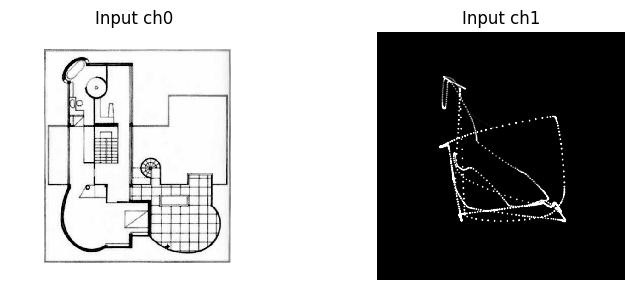

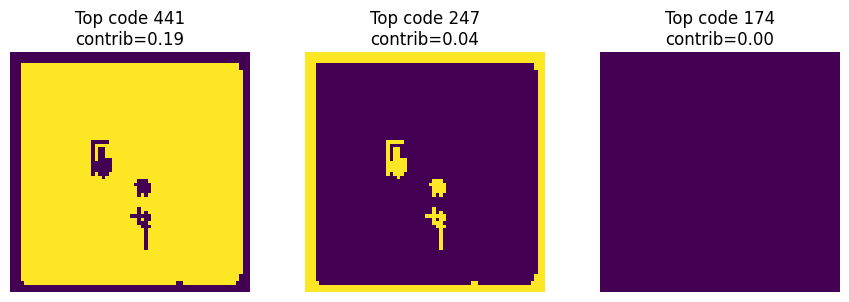

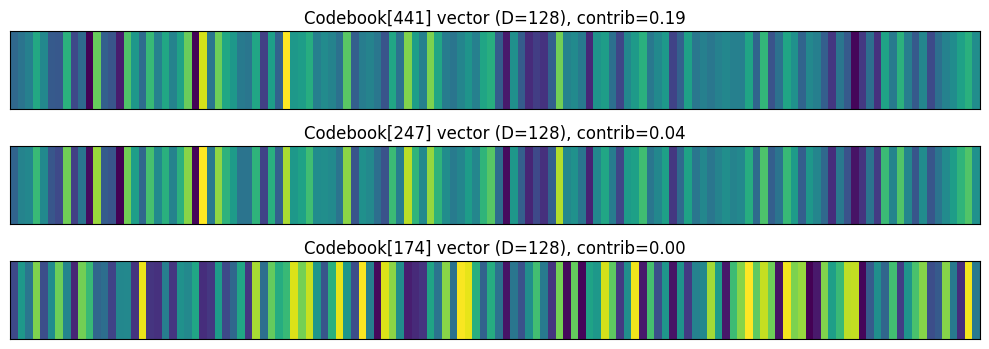

Chosen target class for gradients: Hiearchy
Top codes by contribution: [441, 247, 174]
  code 441: contrib=0.1858, count=3875 locations
  code 247: contrib=0.0359, count=749 locations
  code 174: contrib=0.0000, count=0 locations


In [ ]:
# Assuming you have: model, one validation batch (B=1 is simplest), and class_names
# x_val_batch: (B, H, W, 2)
visualize_top_codes(model_v2, x_val_batch, class_names=["Shape", "Circulation", "Hiearchy"], target_class=None, top_k=3)



🔹 Sample 0


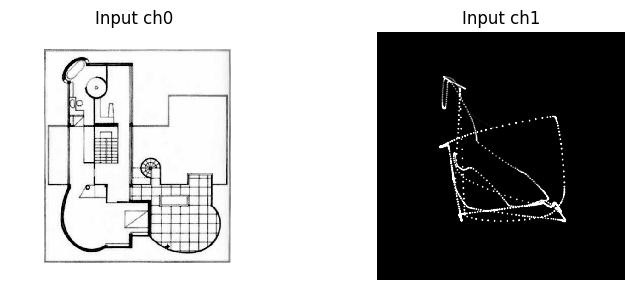

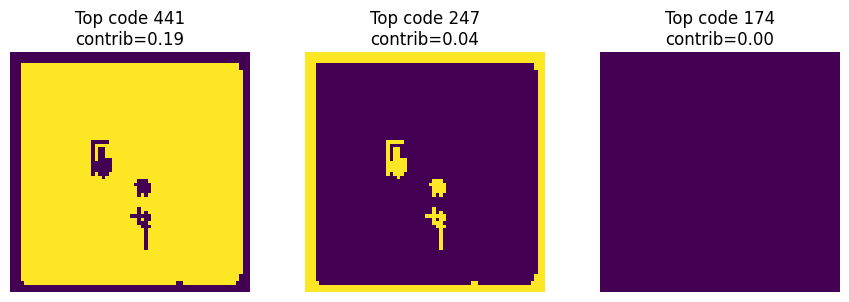

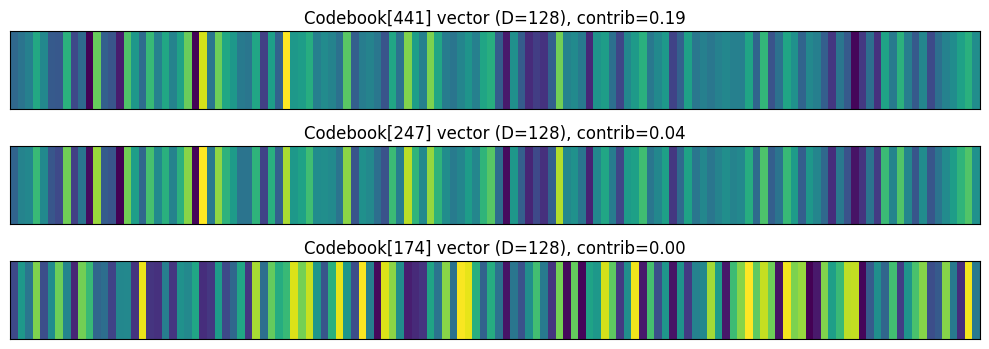

Chosen target class for gradients: Hierarchy
Top codes by contribution: [441, 247, 174]
  code 441: contrib=0.1858, count=3875 locations
  code 247: contrib=0.0359, count=749 locations
  code 174: contrib=0.0000, count=0 locations

🔹 Sample 1


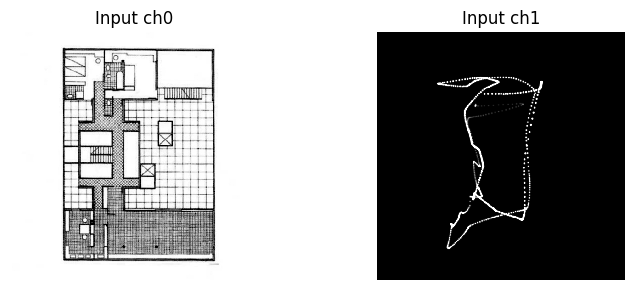

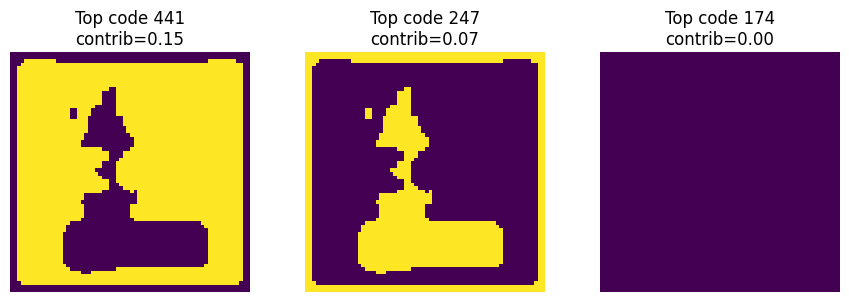

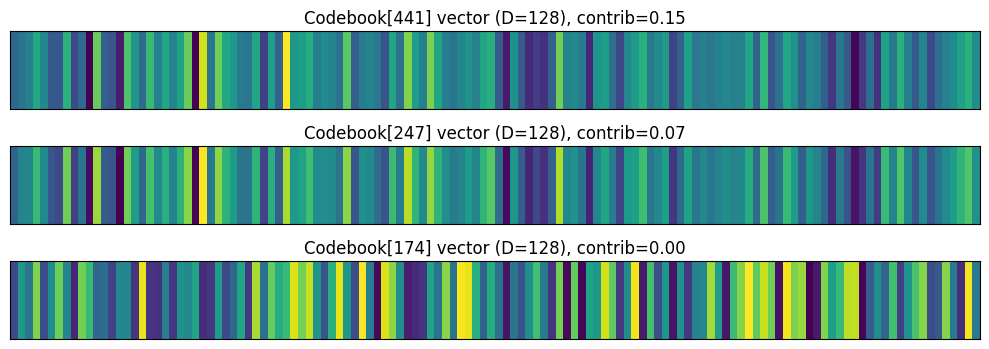

Chosen target class for gradients: Hierarchy
Top codes by contribution: [441, 247, 174]
  code 441: contrib=0.1514, count=3180 locations
  code 247: contrib=0.0687, count=1444 locations
  code 174: contrib=0.0000, count=0 locations


In [ ]:
for i in range(len(x_val_batch)):
    print(f"\n🔹 Sample {i}")
    visualize_top_codes(
        model_v2,
        x_val_batch[i:i+1],                 # slice one sample at a time (keep batch dim)
        class_names=["Shape", "Circulation", "Hierarchy"],
        target_class=None,
        top_k=3
    )



🔹 Sample 0


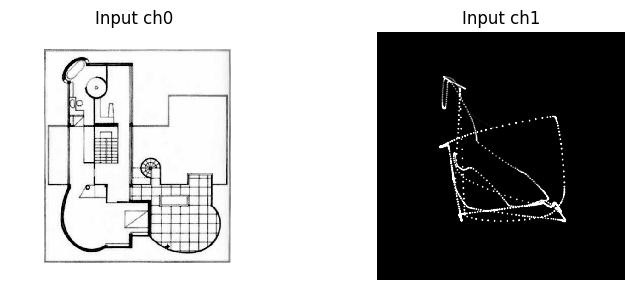

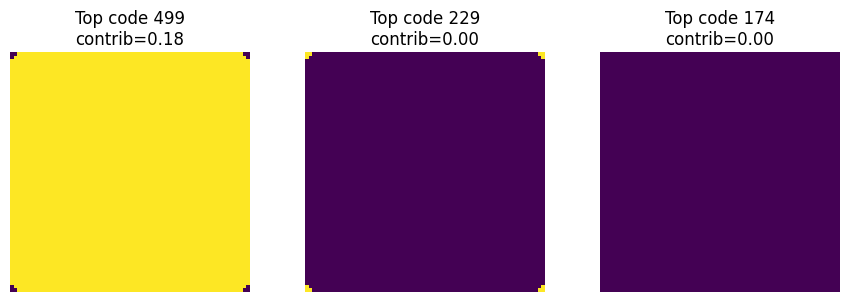

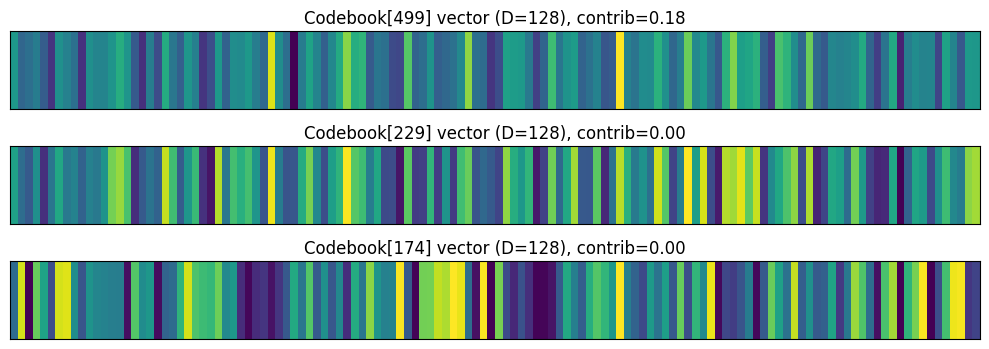

Chosen target class for gradients: Hierarchy
Top codes by contribution: [499, 229, 174]
  code 499: contrib=0.1842, count=4612 locations
  code 229: contrib=0.0005, count=12 locations
  code 174: contrib=0.0000, count=0 locations

🔹 Sample 1


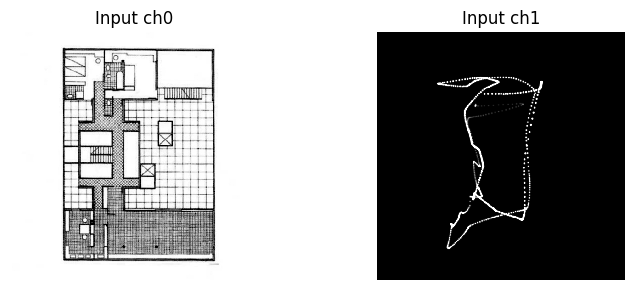

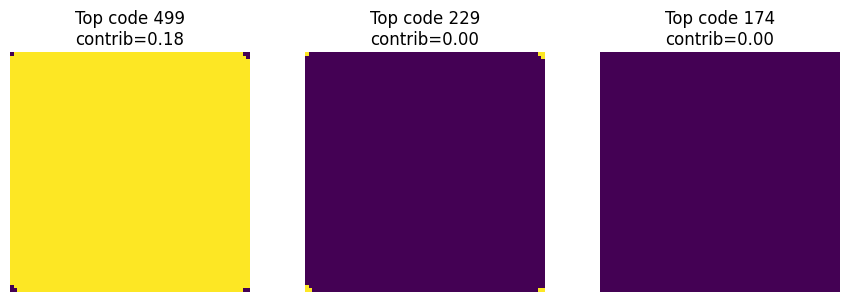

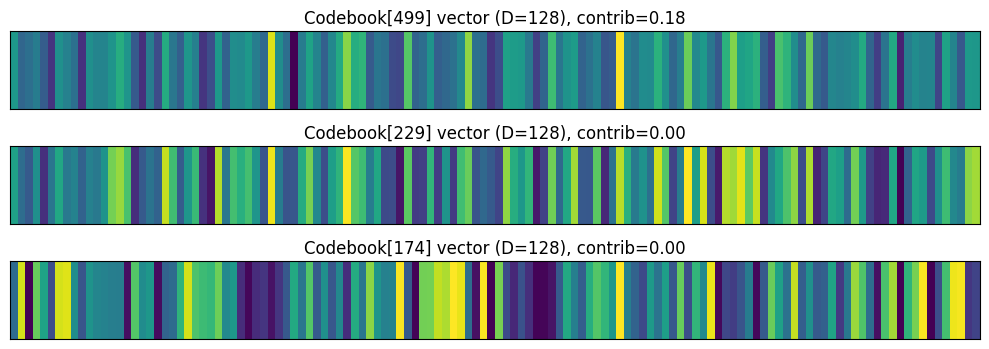

Chosen target class for gradients: Hierarchy
Top codes by contribution: [499, 229, 174]
  code 499: contrib=0.1843, count=4615 locations
  code 229: contrib=0.0004, count=9 locations
  code 174: contrib=0.0000, count=0 locations


In [ ]:
for i in range(len(x_val_batch)):
    print(f"\n🔹 Sample {i}")
    visualize_top_codes(
        model_v2,
        x_val_batch[i:i+1],                 # slice one sample at a time (keep batch dim)
        class_names=["Shape", "Circulation", "Hierarchy"],
        target_class=None,
        top_k=3
    )


🔹 Sample 0


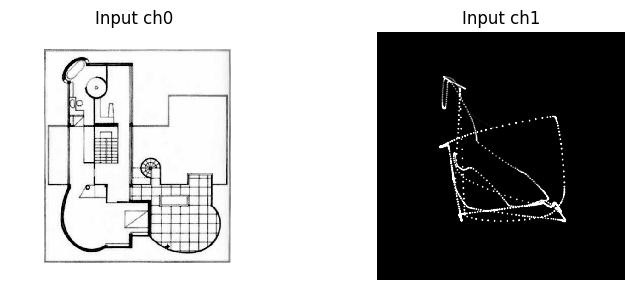

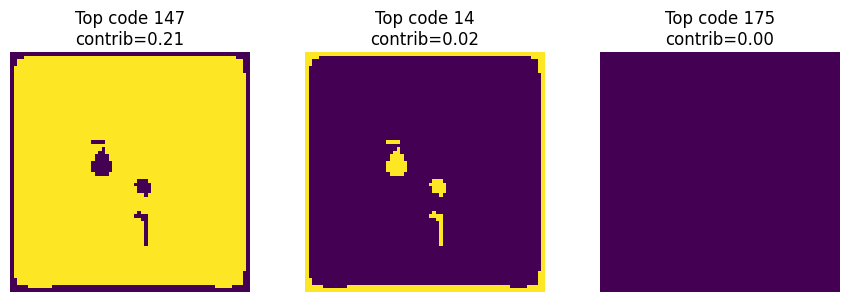

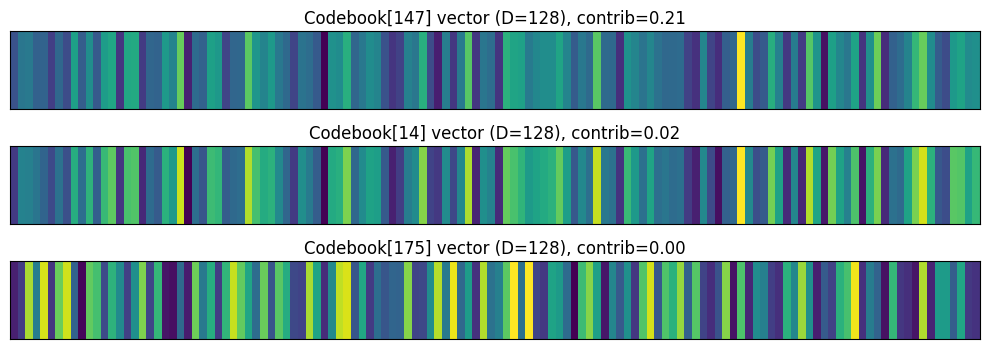

Chosen target class for gradients: Circulation
Top codes by contribution: [147, 14, 175]
  code 147: contrib=0.2094, count=4216 locations
  code 14: contrib=0.0203, count=408 locations
  code 175: contrib=0.0000, count=0 locations

🔹 Sample 1


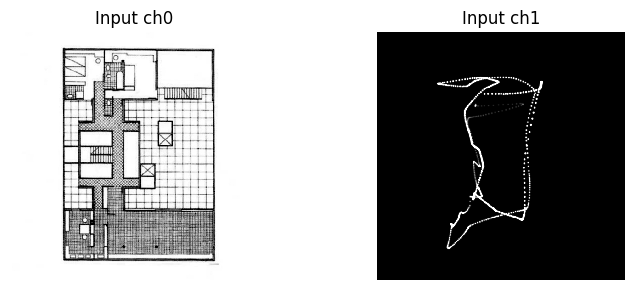

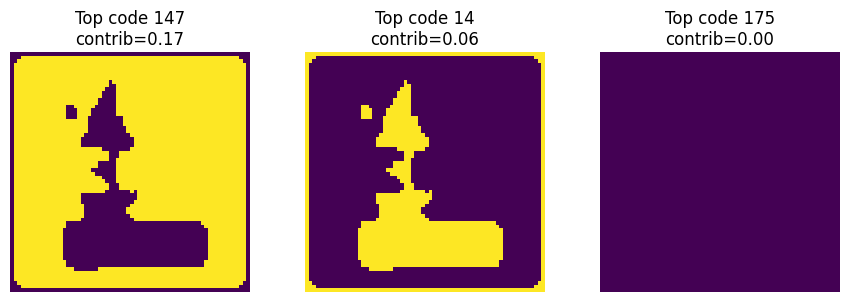

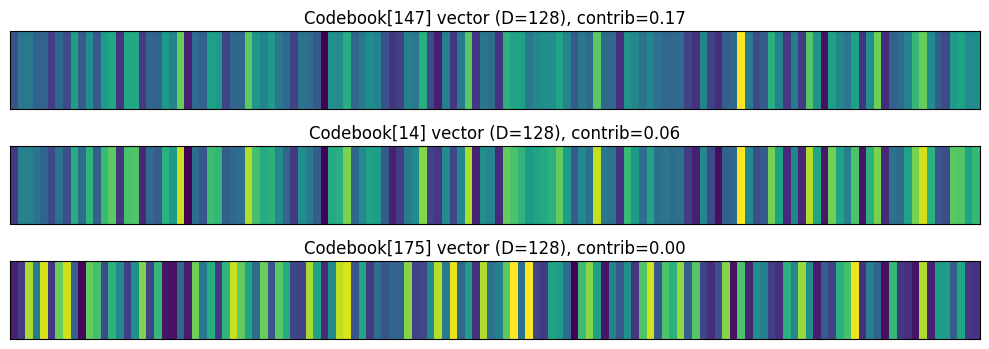

Chosen target class for gradients: Circulation
Top codes by contribution: [147, 14, 175]
  code 147: contrib=0.1717, count=3476 locations
  code 14: contrib=0.0567, count=1148 locations
  code 175: contrib=0.0000, count=0 locations


In [ ]:
for i in range(len(x_val_batch)):
    print(f"\n🔹 Sample {i}")
    visualize_top_codes(
        model_v3,
        x_val_batch[i:i+1],                 # slice one sample at a time (keep batch dim)
        class_names=["Shape", "Circulation", "Hierarchy"],
        target_class=None,
        top_k=3
    )

In deep generative networks, x is the tensor that flows through the networks. It is a representation of abstraction relative to the input.
X is:
token in model_dimension in text models, vector of length model_dim
feature maps in image models, a x a patch
spatial feature map or flattened latent (B, H, W, C)
noisy latents in diffusion models. a 2D x_t tensor H x W
Text cross-attention (conditioning): x = image features (queries); context = text tokens (keys/ values)


# VQ-VAE use for learning codebook patterns for eye-path only

In [ ]:
H, W, C = 540, 540, 2
CODEBOOK_SIZE = 64
CODE_DIM = 32
BETA = 0.25


# =========================
# (2) Add coord channels
# =========================
class AddCoordChannels(layers.Layer):
    """
    Append normalized x/y coordinate grids to a single-channel map.
    Input:  [B,H,W,1]  →  Output: [B,H,W,3] = [gaze, x_grid, y_grid]
    """
    def call(self, x):
        shape = tf.shape(x)
        B, Ht, Wt = shape[0], shape[1], shape[2]

        xs = tf.linspace(0.0, 1.0, Wt)
        ys = tf.linspace(0.0, 1.0, Ht)
        x_grid = tf.tile(tf.reshape(xs, [1, 1, Wt, 1]), [B, Ht, 1, 1])  # [B,H,W,1]
        y_grid = tf.tile(tf.reshape(ys, [1, Ht, 1, 1]), [B, 1, Wt, 1])  # [B,H,W,1]
        return tf.concat([x, x_grid, y_grid], axis=-1)


# --- Vector Quantizer ---
class VectorQuantizer(layers.Layer):
    def __init__(self, num_codes=64, code_dim=64, beta=0.25,track_entropy=True, **kwargs):
        super().__init__(**kwargs)
        self.num_codes = num_codes
        self.code_dim = code_dim
        self.beta = beta
        self.track_entropy = track_entropy

     # --- Metric trackers (Keras 3 style) ---
        self.vq_codebook_loss_tracker = keras.metrics.Mean(name="vq_codebook_loss")
        self.vq_commit_loss_tracker   = keras.metrics.Mean(name="vq_commit_loss")
        if self.track_entropy:
            self.vq_usage_entropy_tracker = keras.metrics.Mean(name="vq_usage_entropy")

    @property
    def metrics(self):
        # Keras will display & reset these automatically
        mets = [self.vq_codebook_loss_tracker, self.vq_commit_loss_tracker]
        if self.track_entropy:
            mets.append(self.vq_usage_entropy_tracker)
        return mets

    def build(self, input_shape):
        self.codebook = self.add_weight(
            shape=(self.num_codes, self.code_dim),
            initializer="uniform",
            trainable=True,
            name="codebook"
        )

    def call(self, z_e):
        z_flat = tf.reshape(z_e, [-1, tf.shape(z_e)[-1]])
        z_sq = tf.reduce_sum(z_flat**2, axis=1, keepdims=True)
        e_sq = tf.reduce_sum(self.codebook**2, axis=1)[tf.newaxis]
        ze = tf.matmul(z_flat, self.codebook, transpose_b=True)
        d = z_sq + e_sq - 2.0 * ze
        codes = tf.argmin(d, axis=1)
        z_q = tf.gather(self.codebook, codes)
        z_q = tf.reshape(z_q, tf.shape(z_e))
        # losses
        codebook_loss = tf.reduce_mean(tf.square(tf.stop_gradient(z_e) - z_q))
        commit_loss   = tf.reduce_mean(tf.square(z_e - tf.stop_gradient(z_q)))

        self.add_loss(codebook_loss + self.beta * commit_loss)



        # --- Update metric trackers (instead of add_metric) ---
        self.vq_codebook_loss_tracker.update_state(codebook_loss)
        self.vq_commit_loss_tracker.update_state(self.beta * commit_loss)

        # --- Optional: track entropy ---
        if self.track_entropy:
            h = tf.shape(z_e)[1]; w = tf.shape(z_e)[2]
            codes_map  = tf.reshape(codes, (-1, h, w))      # [B,h,w]
            codes_flat = tf.reshape(codes_map, [-1])        # [B*h*w]
            # one_hot avoids DenseBincount; make sure indices are int32
            oh = tf.one_hot(tf.cast(codes_flat, tf.int32), depth=self.num_codes, dtype=tf.float32)  # [N, K]
            counts = tf.reduce_sum(oh, axis=0)              # [K]
            probs  = (counts + 1e-6) / (tf.reduce_sum(counts) + 1e-6 * tf.cast(self.num_codes, tf.float32))
            entropy = -tf.reduce_sum(probs * tf.math.log(probs))

            lambda_div = 1e-3
            self.add_loss(-lambda_div * entropy)   # encourage diverse code usage

            # Update the metric tracker if you have one
            self.vq_usage_entropy_tracker.update_state(entropy)
        else:
            h = tf.shape(z_e)[1]; w = tf.shape(z_e)[2]
            codes_map  = tf.reshape(codes, (-1, h, w))

        # straight-through
        z_q_st = z_e + tf.stop_gradient(z_q - z_e)
        h, w = tf.shape(z_e)[1], tf.shape(z_e)[2]
        codes_map = tf.reshape(codes, (-1, h, w))
        return z_q_st, codes_map


# --- Encoder / Decoder ---
def build_gaze_encoder(latent_dim=64):
    inp = layers.Input(shape=(None, None, 3))
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2D(128,4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256,4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(inp, x, name="gaze_encoder")

def build_gaze_decoder(out_channels=1, code_dim=64):
    inp = layers.Input(shape=(None, None, code_dim))
    x = layers.Conv2DTranspose(256,4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2DTranspose(128,4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Cropping2D(((2,2),(2,2)))(x)
    out = layers.Conv2D(out_channels, 1, padding="same", activation=None)(x)
    return keras.Model(inp, out, name="gaze_decoder")


# --- Functional assembly ---
def build_full_vqvae(num_codes=64, code_dim=64, beta=0.25):
    # Input with 2 channels: image + gaze
    inputs = keras.Input(shape=(None, None, 2), name="input_image_gaze")

    # Extract only gaze channel (assume last channel)
    gaze = layers.Lambda(lambda x: x[..., -1:], name="gaze_slice")(inputs)

    gaze_plus_coords = AddCoordChannels(name = "add_coords")(gaze) # new

    # Encode -> Quantize -> Decode
    encoder = build_gaze_encoder(latent_dim=code_dim)
    quantizer = VectorQuantizer(num_codes=num_codes, code_dim=code_dim, beta=beta)
    decoder = build_gaze_decoder(out_channels=1, code_dim=code_dim)

    z_e = encoder(gaze_plus_coords)# new
    z_q, codes = quantizer(z_e)
    recon = decoder(z_q)

    # Create full Functional model
    model = keras.Model(inputs=inputs, outputs=[recon, codes], name="GazeOnlyVQVAE")
    return model







### Regular VQVAE

In [ ]:
# --- Build and inspect ---
path_model_2 = build_full_vqvae(num_codes=64, code_dim=32, beta=0.1)


In [ ]:
path_model_2.summary()

Model: "GazeOnlyVQVAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image_gaze (InputLayer)   │ (None, None, None, 2)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaze_slice (Lambda)             │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_coords (AddCoordChannels)   │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaze_encoder (Functional)       │ (None, None, None, 32) │       667,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vector_quantizer_6              │ [(None, None, None,    │         2,048 │
│ (VectorQuantizer)               │ 32), (None, None,      │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaze_decoder (Functional)       │ (None, None, None, 1)  │       786,945 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,456,097 (5.55 MB)

 Trainable params: 1,456,097 (5.55 MB)

 Non-trainable params: 0 (0.00 B)

## Train Path Only Model

In [ ]:
# Match keys to vqvae.output_names exactly:
loss_key = path_model_2.output_names[0]  # 'gaze_decoder' or 'recon'
ignore_key = path_model_2.output_names[1]  # 'vector_quantizer_*'

In [ ]:
# Keras needs targets for outputs that have a loss. We’ll give it the gaze channel only.
AUTOTUNE = tf.data.AUTOTUNE

def to_gaze_target(x, *rest):
    x = tf.cast(x, tf.float32)                 # be explicit
    y_gaze = x[..., -1:]                       # (B,H,W,1)
    dummy  = tf.zeros((), dtype=tf.float32)    # scalar float32, NOT a string
    return x, {loss_key: y_gaze, ignore_key: dummy}

train_ds_t = (train_ds
              .map(to_gaze_target, num_parallel_calls=AUTOTUNE)
              .prefetch(AUTOTUNE))

val_ds_t = (val_ds
            .map(to_gaze_target, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))

In [ ]:
for xb, yb in val_ds_t.take(1):
    print("gaze min/max:", tf.reduce_min(yb[loss_key]).numpy(), tf.reduce_max(yb[loss_key]).numpy())
    break

gaze min/max: 0.0 0.88381153


In [ ]:
# Compile (loss on recon only; codebook/commit losses are automatic)

def total_var(y):
    return tf.reduce_mean(tf.image.total_variation(y))

def focal_l1(y_true, y_pred, gamma=1.0, eps=1e-3):
    # emphasize brighter gaze intensities
    w = tf.pow(y_true + eps, gamma)
    return tf.reduce_mean(w * tf.abs(y_true - y_pred))

def recon_loss(y_true, y_pred):
    return focal_l1(y_true, y_pred, gamma=1.0) + 1e-4 * total_var(y_pred)

def zero_loss(y_true, y_pred):  # for the codes head
    return tf.constant(0.0, tf.float32)

# Optional: handy metrics
def mae(y_true, y_pred): return tf.reduce_mean(tf.abs(y_true - y_pred))

# If you want a PSNR metric (works on [0,1] signals):
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

pos_w = 12.0
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def weighted_bce(y_true, y_logit):
    w = 1.0 + (pos_w - 1.0) * y_true
    return tf.reduce_mean(w * bce(y_true, y_logit))
def mae_post_sigmoid(y_true, y_logit):
    y_pred = tf.sigmoid(y_logit)
    return tf.reduce_mean(tf.abs(y_true - y_pred))

path_model_2.compile(
    optimizer=keras.optimizers.Adam(2e-4),
    loss={loss_key: weighted_bce, ignore_key: lambda a,b: tf.constant(0.0)},
    loss_weights={loss_key: 1.0, ignore_key: 0.0},
    metrics={loss_key: [mae_post_sigmoid]}
)

In [ ]:
print("Output names:", path_model_2.output_names)

Output names: ListWrapper(['gaze_decoder', 'vector_quantizer_6'])


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "chkpts/gaze_vqvae.{epoch:02d}.weights.h5",
        save_weights_only=True, save_best_only=True,
        monitor="val_gaze_decoder_mae_post_sigmoid", mode="min"
    ),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_gaze_decoder_mae_post_sigmoid",
    patience=8, restore_best_weights=True, mode="min"
)
]
history = path_model_2.fit(
    train_ds_t,
    validation_data=val_ds_t,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - gaze_decoder_loss: 0.6747 - gaze_decoder_mae_post_sigmoid: 0.4835 - loss: 0.8058 - vector_quantizer_6_loss: 0.0000e+00 - vq_codebook_loss: 0.1193 - vq_commit_loss: 0.0119 - vq_usage_entropy: 0.1205 - val_gaze_decoder_loss: 0.2322 - val_gaze_decoder_mae_post_sigmoid: 0.2017 - val_loss: 5.3515 - val_vector_quantizer_6_loss: 0.0000e+00 - val_vq_codebook_loss: 4.6539 - val_vq_commit_loss: 0.4654 - val_vq_usage_entropy: 0.0085
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - gaze_decoder_loss: 0.0892 - gaze_decoder_mae_post_sigmoid: 0.0755 - loss: 9.7791 - vector_quantizer_6_loss: 0.0000e+00 - vq_codebook_loss: 8.8090 - vq_commit_loss: 0.8809 - vq_usage_entropy: 0.0134 - val_gaze_decoder_loss: 0.0341 - val_gaze_decoder_mae_post_sigmoid: 0.0087 - val_loss: 0.3542 - val_vector_quantizer_6_loss: 0.0000e+00 - val_vq_codebook_loss: 0.2912 - val_vq_commit_loss: 0.0291 - val_vq_usage_entropy: 0.2041
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5

### EMA Test

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class VectorQuantizerEMA(layers.Layer):
    def __init__(self, num_codes=64, code_dim=64, beta=0.6,
                 decay=0.99, eps=1e-5, diversity_weight=1e-3,
                 track_entropy=True, name="vector_quantizer_ema", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_codes = num_codes
        self.code_dim = code_dim
        self.beta = beta                 # commitment weight (on encoder)
        self.decay = decay               # EMA decay for counts & embeddings
        self.eps = eps
        self.diversity_weight = diversity_weight
        self.track_entropy = track_entropy

        # Keras 3 metric trackers
        self.vq_commit_loss_tracker   = keras.metrics.Mean(name="vq_commit_loss")
        self.vq_usage_entropy_tracker = keras.metrics.Mean(name="vq_usage_entropy")

    @property
    def metrics(self):
        mets = [self.vq_commit_loss_tracker]
        if self.track_entropy:
            mets.append(self.vq_usage_entropy_tracker)
        return mets

    def build(self, input_shape):
        self.codebook = self.add_weight(
            name="codebook", shape=(self.num_codes, self.code_dim),
            initializer="uniform", trainable=False
        )
        self.ema_count = self.add_weight(
            name="ema_count", shape=(self.num_codes,),
            initializer="zeros", trainable=False
        )
        self.ema_weight = self.add_weight(
            name="ema_weight", shape=(self.num_codes, self.code_dim),
            initializer="zeros", trainable=False
        )

    def _ema_update(self, encodings, z_flat):
        # encodings: [N,K] one-hot; z_flat: [N,D]
        n_per_code   = tf.reduce_sum(encodings, axis=0)                 # [K]
        sum_per_code = tf.matmul(encodings, z_flat, transpose_a=True)   # [K,D]

        self.ema_count.assign(self.decay * self.ema_count + (1. - self.decay) * n_per_code)
        self.ema_weight.assign(self.decay * self.ema_weight + (1. - self.decay) * sum_per_code)

        denom = self.ema_count[:, None] + self.eps
        self.codebook.assign(self.ema_weight / denom)

    def call(self, z_e):
        B = tf.shape(z_e)[0]; H = tf.shape(z_e)[1]; W = tf.shape(z_e)[2]; D = tf.shape(z_e)[3]
        z_flat = tf.reshape(z_e, [-1, D])                                # [N,D]

        # squared distances to codebook: ||z||^2 + ||e||^2 - 2 z·e
        z_sq = tf.reduce_sum(z_flat*z_flat, axis=1, keepdims=True)       # [N,1]
        e_sq = tf.reduce_sum(self.codebook*self.codebook, axis=1, keepdims=True)  # [K,1]
        ze   = tf.matmul(z_flat, self.codebook, transpose_b=True)        # [N,K]
        d    = z_sq + tf.transpose(e_sq) - 2. * ze                       # [N,K]

        codes  = tf.argmin(d, axis=1)                                    # [N]
        z_q    = tf.gather(self.codebook, codes)                         # [N,D]
        z_q    = tf.reshape(z_q, [B, H, W, -1])                          # [B,H,W,D]
        codes_map = tf.reshape(codes, [B, H, W])                         # [B,H,W]

        # commitment loss (no codebook gradient)
        commit = tf.reduce_mean(tf.square(tf.stop_gradient(z_q) - z_e))
        self.add_loss(self.beta * commit)
        self.vq_commit_loss_tracker.update_state(self.beta * commit)

        # straight-through estimator
        z_q_st = z_e + tf.stop_gradient(z_q - z_e)

        # EMA update (no gradients)
        encodings = tf.one_hot(tf.cast(codes, tf.int32), depth=self.num_codes, dtype=tf.float32)  # [N,K]
        self._ema_update(encodings, z_flat)

        # diversity / entropy
        if self.track_entropy or (self.diversity_weight and self.diversity_weight > 0.0):
            counts = tf.reduce_sum(encodings, axis=0) + 1e-6
            probs  = counts / tf.reduce_sum(counts)
            entropy = -tf.reduce_sum(probs * tf.math.log(probs))
            if self.track_entropy:
                self.vq_usage_entropy_tracker.update_state(entropy)
            if self.diversity_weight and self.diversity_weight > 0.0:
                # maximize entropy → subtract from loss
                self.add_loss(- self.diversity_weight * entropy)

        return z_q_st, codes_map

    # Optional: initialize from encoder samples
    def init_codebook_from_samples(self, samples):  # samples: [M,D]
        M = tf.shape(samples)[0]
        idx = tf.random.shuffle(tf.range(M))[:self.num_codes]
        init_vecs = tf.gather(samples, idx)
        self.codebook.assign(init_vecs)
        self.ema_weight.assign(init_vecs)
        self.ema_count.assign(tf.ones_like(self.ema_count))


In [ ]:
def build_full_vqvae(num_codes=64, code_dim=64, beta=0.6, decay=0.99, diversity_weight=1e-3):
    inputs = keras.Input(shape=(None, None, 2), name="input_image_gaze")
    gaze   = layers.Lambda(lambda x: x[..., -1:], name="gaze_slice")(inputs)

    encoder = build_gaze_encoder(latent_dim=code_dim)
    quant   = VectorQuantizerEMA(num_codes=num_codes, code_dim=code_dim,
                                 beta=beta, decay=decay, diversity_weight=diversity_weight)
    decoder = build_gaze_decoder(out_channels=1, code_dim=code_dim)  # last layer activation=None (logits)

    z_e = encoder(gaze)
    z_q, codes = quant(z_e)
    recon = decoder(z_q)  # logits

    return keras.Model(inputs, [recon, codes], name="GazeOnlyVQVAE")


In [ ]:
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def mae_post_sigmoid(y_true, y_logit):
    return tf.reduce_mean(tf.abs(y_true - tf.sigmoid(y_logit)))

model = build_full_vqvae(num_codes=64, code_dim=16, beta=0.6, decay=0.99, diversity_weight=1e-3)  # try code_dim=16 for small data
recon_key, codes_key = model.output_names  # ['gaze_decoder', '<quant_name>']

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss={recon_key: bce_logits, codes_key: lambda a,b: 0.0},
    loss_weights={recon_key: 1.0, codes_key: 0.0},
    metrics={recon_key: [mae_post_sigmoid]}
)

AUTOTUNE = tf.data.AUTOTUNE
def to_targets(x, *rest):
    x = tf.cast(x, tf.float32)
    return x, {recon_key: x[..., -1:], codes_key: tf.zeros((), tf.float32)}

train_ds_t = train_ds.map(to_targets, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds_t   = val_ds.map(to_targets,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [ ]:
history = model.fit(
    train_ds_t,
    validation_data=val_ds_t,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - gaze_decoder_loss: 0.6864 - gaze_decoder_mae_post_sigmoid: 0.4953 - loss: 0.6863 - vector_quantizer_ema_loss: 0.0000e+00 - vq_commit_loss: 5.9326e-05 - vq_usage_entropy: 0.1276 - val_gaze_decoder_loss: 0.6008 - val_gaze_decoder_mae_post_sigmoid: 0.4502 - val_loss: 0.6011 - val_vector_quantizer_ema_loss: 0.0000e+00 - val_vq_commit_loss: 2.8472e-04 - val_vq_usage_entropy: 0.0044
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - gaze_decoder_loss: 0.4118 - gaze_decoder_mae_post_sigmoid: 0.3211 - loss: 0.4492 - vector_quantizer_ema_loss: 0.0000e+00 - vq_commit_loss: 0.0374 - vq_usage_entropy: 0.0019 - val_gaze_decoder_loss: 0.0212 - val_gaze_decoder_mae_post_sigmoid: 0.0013 - val_loss: 0.1215 - val_vector_quantizer_ema_loss: 0.0000e+00 - val_vq_commit_loss: 0.1002 - val_vq_usage_entropy: 0.0020
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - gaze_decoder_loss: 0.0262 - gaze_decoder_mae_post_sigmoid: 0.0012 - loss: 0.0557 - vect

## Troubleshoot

In [ ]:
# Sanity pass on one val batch
for xb, yb in val_ds_t.take(1):
    recon_pred, codes_pred = path_model_2(xb, training=False)
    y_true = yb[loss_key]            # loss_key should be 'recon' or your recon head name
    break

recon_vis = tf.sigmoid(recon_pred)

print("recon_pred shape:", recon_pred.shape)
print("codes_pred shape:", codes_pred.shape)

print("recon min/max:", float(tf.reduce_min(recon_vis)), float(tf.reduce_max(recon_vis)))
print("true  min/max:",  float(tf.reduce_min(y_true)),     float(tf.reduce_max(y_true)))


recon_pred shape: (2, 540, 540, 1)
codes_pred shape: (2, 68, 68)
recon min/max: 6.698034904495387e-10 0.3399294912815094
true  min/max: 0.0 0.8838115334510803


## Visualize Reconstruction

In [ ]:
# Get Validation set
for xb, yb in val_ds_t.take(1):
    recon_pred, codes_pred = path_model_2(xb, training=False)
    recon_vis = tf.sigmoid(recon_pred)  # convert logits → probabilities [0,1]
    true_gaze = yb["gaze_decoder"]
    break

In [ ]:
print("recon_pred shape:", np.array(recon_pred).shape)
print("true_gaze shape:", np.array(true_gaze).shape)

recon_pred shape: (2, 540, 540, 1)
true_gaze shape: (2, 540, 540, 1)


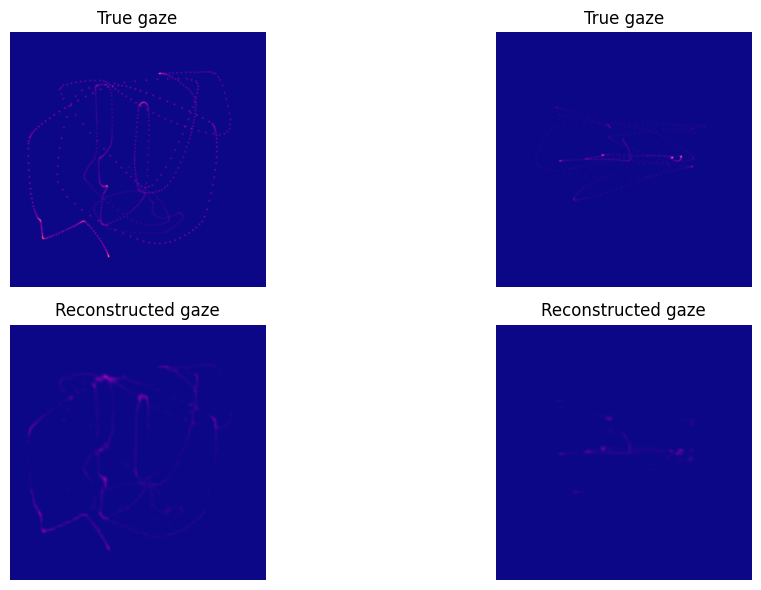

In [ ]:
# Visualize predicted vs True gaze path
def show_gaze_comparison(pred, true, n=2):
    plt.figure(figsize=(6*n, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(true[i, ..., 0], cmap="plasma", vmin=0, vmax=1)
        plt.title("True gaze")
        plt.axis("off")

        plt.subplot(2, n, n+i+1)
        plt.imshow(pred[i, ..., 0], cmap="plasma", vmin=0, vmax=1)
        plt.title("Reconstructed gaze")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_gaze_comparison(recon_vis.numpy(), true_gaze.numpy(), n=2)


## Visualize Codebook

In [ ]:
recon_pred, codes_pred = path_model_2(xb, training=False)
usage = tf.math.bincount(tf.reshape(codes_pred, [-1]), minlength=64).numpy()
print("Nonzero codes:", (usage>0).sum(), " / 64")
print("Usage (top 10):", usage.argsort()[::-1][:10], usage[usage.argsort()[::-1][:10]])

Nonzero codes: 18  / 64
Usage (top 10): [37 18 42 22 61 19 15 45 41  8] [3843 2169  975  562  331  279  237  196  163  143]


In [ ]:
for xb, yb in val_ds_t.take(1):
    recon_pred, codes_pred = path_model_2(xb, training=False)
    true_gaze = yb["gaze_decoder"]
    break


In [ ]:
codes_flat = tf.reshape(codes_pred, [-1])
usage = tf.math.bincount(codes_flat, minlength=64).numpy()  # 64 = codebook size
top8_ids = np.argsort(usage)[::-1][:8]
print("Top 8 most used codes:", top8_ids)
print("Usage counts:", usage[top8_ids])

Top 8 most used codes: [37 18 42 22 61 19 15 45]
Usage counts: [3843 2169  975  562  331  279  237  196]


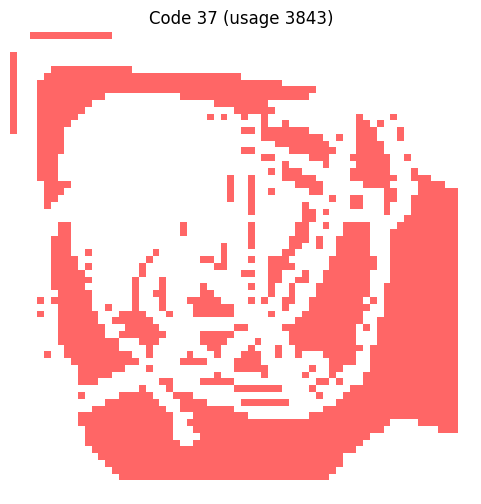

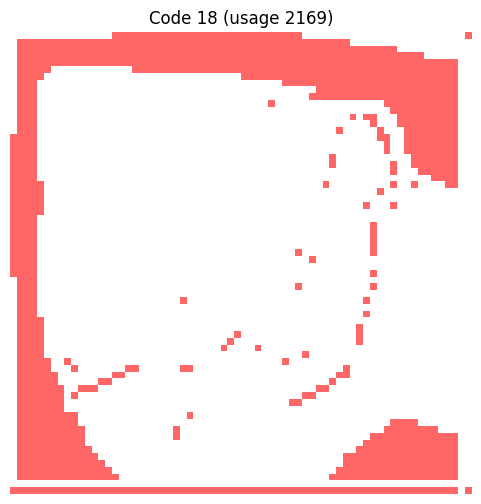

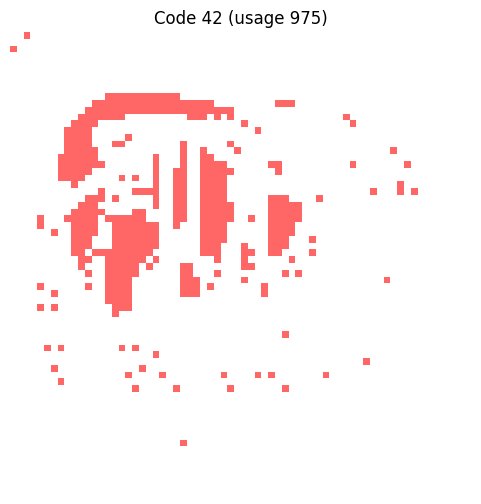

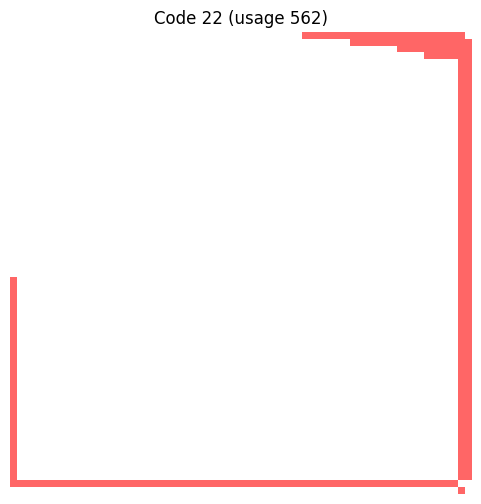

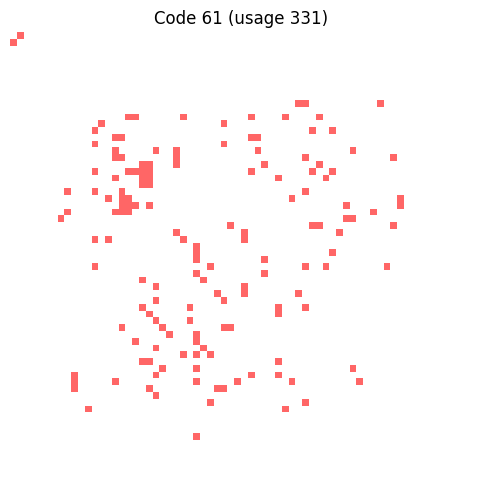

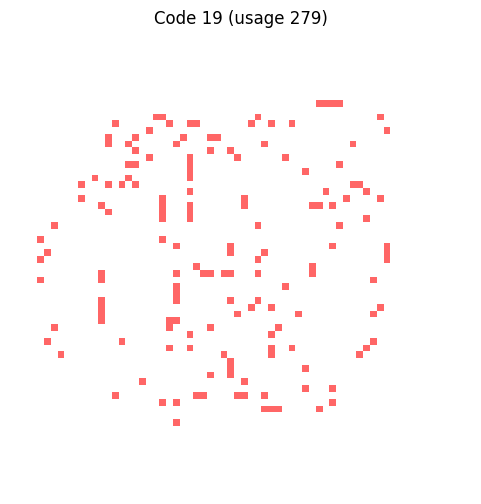

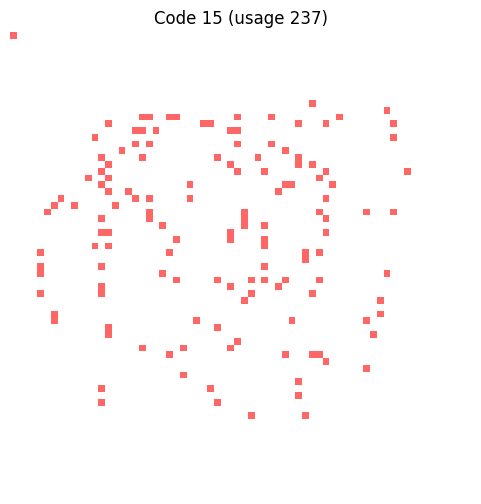

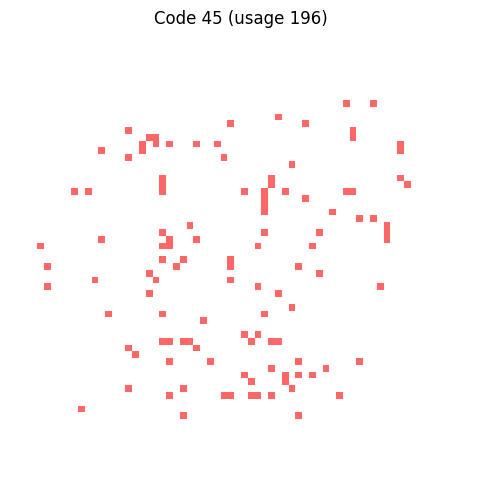

In [ ]:
from matplotlib.colors import ListedColormap

def visualize_top_codes(codes, top_ids, n=3):
    # codes: [B,h,w], top_ids: [3]
    h, w = codes.shape[1:3]
    for i, cid in enumerate(top_ids):
        plt.figure(figsize=(6,6))
        mask = (codes[0] == cid).numpy().astype(float)  # use first image in batch
        plt.imshow(mask, cmap=ListedColormap(["white","red"]), alpha=0.6)
        plt.title(f"Code {cid} (usage {usage[cid]})")
        plt.axis("off")
        plt.show()

visualize_top_codes(codes_pred, top8_ids)

qualitative description of visual interaction with sketches: ETRA ACM. Origianl: saliency, gaze intensity. Qualitative predicates for a PDDL-like  to infer interaction as an intention. LLM not good for tight scheduling sequences.

# Map Gaze Path to Codes

Top 8 codes: [37 18 42 22 61 19 15 45] counts: [3843 2169  975  562  331  279  237  196]


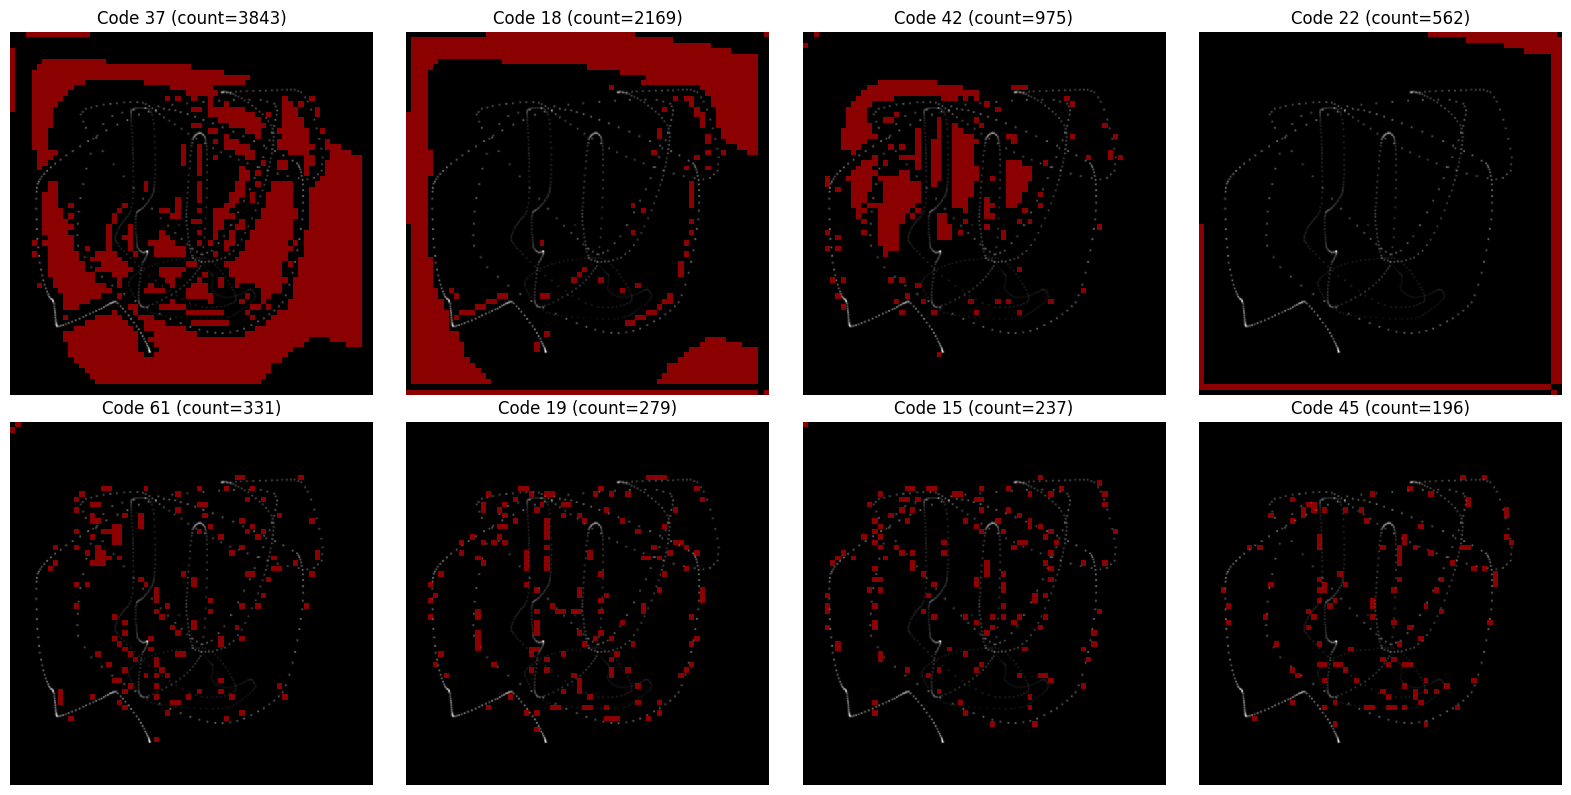

/tmp/ipython-input-3163114868.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab = cm.get_cmap('tab10', 10)


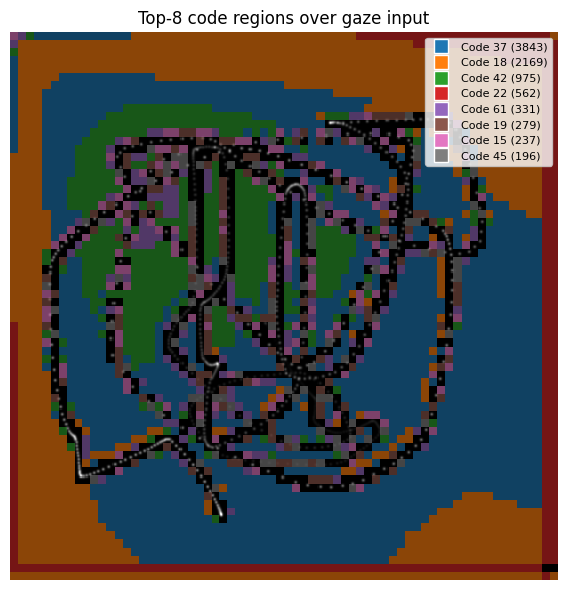

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# --- Forward & pick one batch ---
for xb, yb in val_ds_t.take(1):
    # xb: [B,H,W,2] (image, gaze)
    recon_pred, codes_pred = path_model_2(xb, training=False)  # codes_pred: [B,h',w']
    break

# --- Compute usage & select top-8 codes ---
codes_flat = tf.reshape(tf.cast(codes_pred, tf.int32), [-1])
usage = tf.math.bincount(codes_flat, minlength=CODEBOOK_SIZE).numpy()
top8_ids = np.argsort(usage)[::-1][:8]
print("Top 8 codes:", top8_ids, "counts:", usage[top8_ids])

# --- Helper: upsample code map to input resolution (nearest) ---
def upsample_codes_to_input(codes_map, target_h, target_w):
    # codes_map: [h', w'] int32
    up = tf.image.resize(tf.expand_dims(codes_map, axis=-1), [target_h, target_w], method='nearest')
    return tf.squeeze(tf.cast(up, tf.int32), axis=-1)  # [H,W] int32

# --- Visualize per-code overlays on the original gaze map ---
def visualize_top_codes_on_gaze(xb, codes_pred, top_ids, sample_idx=0):
    """
    xb:          [B,H,W,2] input batch (image + gaze)
    codes_pred:  [B,h',w'] integer code IDs
    top_ids:     list/array of code IDs to visualize
    """
    # 1) pull the original gaze map
    gaze = xb[sample_idx, ..., -1].numpy()         # [H,W]
    H, W = gaze.shape

    # 2) upsample codes to input resolution
    codes_small = tf.cast(codes_pred[sample_idx], tf.int32)  # [h',w']
    codes_up = upsample_codes_to_input(codes_small, H, W).numpy()  # [H,W] int32

    # 3) one plot per code (8 subplots)
    n = len(top_ids)
    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i, cid in enumerate(top_ids):
        plt.subplot(rows, cols, i+1)
        plt.imshow(gaze, cmap='gray', interpolation='nearest')
        mask = (codes_up == int(cid))
        # Use a transparent-red overlay for the mask
        overlay = np.zeros((*mask.shape, 4), dtype=np.float32)
        overlay[mask] = [1.0, 0.0, 0.0, 0.55]  # RGBA with alpha
        plt.imshow(overlay, interpolation='nearest')
        plt.title(f"Code {cid} (count={usage[cid]})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 4) single composite overlay with different colors for each code
    plt.figure(figsize=(6,6))
    plt.imshow(gaze, cmap='gray', interpolation='nearest')
    # pick distinct colors
    tab = cm.get_cmap('tab10', 10)
    colors = [tab(i % 10) for i in range(n)]
    for col, cid in zip(colors, top_ids):
        mask = (codes_up == int(cid))
        overlay = np.zeros((*mask.shape, 4), dtype=np.float32)
        overlay[mask] = [col[0], col[1], col[2], 0.55]  # keep alpha ~0.55
        plt.imshow(overlay, interpolation='nearest')
    # Legend swatches
    handles = [plt.Line2D([0],[0], marker='s', color='w',
                          markerfacecolor=colors[i], markersize=10, linestyle='',
                          label=f"Code {top_ids[i]} ({usage[top8_ids[i]]})")
               for i in range(n)]
    plt.legend(handles=handles, loc='upper right', frameon=True, fontsize=8)
    plt.title("Top-8 code regions over gaze input")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Run visualization ---
visualize_top_codes_on_gaze(xb, codes_pred, top8_ids, sample_idx=0)


# Non-AI Eye-Movement Segmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import tensorflow as tf

CANVAS_H = 540
CANVAS_W = 540

In [ ]:
# ----- From your previous step -----
def _load_and_process_gaze_csv_numpy(csv_path_bytes):
    path = csv_path_bytes.decode("utf-8")
    data = np.loadtxt(path, delimiter=',', skiprows=1)
    if data.ndim == 1: data = data[None, :]

    x_norm = data[:, 3]
    y_norm = data[:, 4]
    t_intervals = data[:, 2]

    t_abs = np.cumsum(t_intervals)
    if t_abs.size > 0 and t_abs.max() > t_abs.min():
        t_norm = (t_abs - t_abs.min()) / (t_abs.max() - t_abs.min())
    else:
        t_norm = np.zeros_like(t_abs)

    x_pix = ((x_norm + 1.0) * 0.5) * (CANVAS_W - 1)
    y_pix = CANVAS_H - ((y_norm + 1.0) * 0.5) * (CANVAS_H - 1)

    x_pix = np.rint(x_pix).astype(np.int32)
    y_pix = np.rint(y_pix).astype(np.int32)
    on_screen = (x_pix >= 0) & (x_pix < CANVAS_W) & (y_pix >= 0) & (y_pix < CANVAS_H)

    xp = x_pix[on_screen].astype(np.float32)
    yp = y_pix[on_screen].astype(np.float32)
    tp = np.asarray(t_norm)[on_screen].astype(np.float32)

    order = np.argsort(tp)
    return xp[order], yp[order], tp[order]

def load_gaze_from_csv_tf(csv_path: tf.Tensor):
    xp, yp, tp = tf.numpy_function(
        _load_and_process_gaze_csv_numpy,
        [csv_path],
        Tout=[tf.float32, tf.float32, tf.float32]
    )
    xp.set_shape([None]); yp.set_shape([None]); tp.set_shape([None])
    # Ragged 1D (nice for variable length)
    xr = tf.RaggedTensor.from_tensor(tf.expand_dims(xp, 0))[0]
    yr = tf.RaggedTensor.from_tensor(tf.expand_dims(yp, 0))[0]
    tr = tf.RaggedTensor.from_tensor(tf.expand_dims(tp, 0))[0]
    return xr, yr, tr

def csv_to_triplets_and_maps(csv_path):
    xr, yr, tr = load_gaze_from_csv_tf(csv_path)
    # Optional dense xyz map for later overlays if you want (can skip)
    xyz_map = rasterize_xyz(xr, yr, tr, H=CANVAS_H, W=CANVAS_W)
    return {"x": xr, "y": yr, "t": tr, "xyz_map": xyz_map}

def rasterize_xyz(xr, yr, tr, H=540, W=540):
    x = tf.clip_by_value(tf.cast(tf.round(xr), tf.int32), 0, W-1)
    y = tf.clip_by_value(tf.cast(tf.round(yr), tf.int32), 0, H-1)
    t = tf.cast(tr, tf.float32)

    zeros = tf.zeros((H, W, 3), dtype=tf.float32)
    idx = tf.stack([y, x], axis=1)
    updates = tf.stack([tf.cast(x, tf.float32), tf.cast(y, tf.float32), t], axis=1)
    dense = tf.tensor_scatter_nd_update(zeros, idx, updates)
    return dense


In [ ]:
def compute_speed_from_xy_t(x, y, t, smooth_window=5):
    x = np.asarray(x, float); y = np.asarray(y, float); t = np.asarray(t, float)
    # They’re already sorted by t (we sorted in loader), but re-sort safely:
    order = np.argsort(t); x, y, t = x[order], y[order], t[order]
    dx, dy = np.diff(x), np.diff(y)
    dt = np.diff(t); dt = np.where(dt <= 1e-9, 1e-9, dt)
    v = np.sqrt(dx*dx + dy*dy) / dt
    v = np.concatenate([[v[0] if v.size else 0.0], v])
    if smooth_window and v.size >= smooth_window:
        k = smooth_window
        vs = np.convolve(v, np.ones(k)/k, mode='same')
        vs[0], vs[-1] = v[0], v[-1]
        v = vs
    return x, y, t, v

def choose_k_by_silhouette(t, v, k_min=2, k_max=7, random_state=0):
    Z = np.stack([t, v], 1)
    Zs = StandardScaler().fit_transform(Z)
    best_k, best_s = None, -1
    for K in range(k_min, k_max+1):
        km = KMeans(n_clusters=K, n_init="auto", random_state=random_state)
        labels = km.fit_predict(Zs)
        if np.unique(labels).size > 1:
            s = silhouette_score(Zs, labels)
            if s > best_s: best_k, best_s = K, s
    return (best_k or 3), best_s

def cluster_by_time_and_speed(t, v, n_clusters=3, random_state=0):
    Z = np.stack([t, v], 1)
    Zs = StandardScaler().fit_transform(Z)
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    labels = km.fit_predict(Zs)
    return labels, km, Z

def plot_t_vs_speed(t, v, labels, title="Clusters in (t, speed)"):
    plt.figure(figsize=(7,4))
    sc = plt.scatter(t, v, c=labels, s=14, cmap="tab10", alpha=0.9)
    plt.xlabel("t (normalized time)"); plt.ylabel("speed (px / unit-t)")
    plt.title(title); plt.colorbar(sc, label="cluster")
    plt.tight_layout(); plt.show()

def plot_xy_path_colored(x, y, labels, title="XY trajectory by cluster", invert_y=True):
    plt.figure(figsize=(5,5))
    sc = plt.scatter(x, y, c=labels, s=14, cmap="tab10", alpha=0.9)
    plt.plot(x, y, lw=0.6, alpha=0.45, color="k")
    if invert_y: plt.gca().invert_yaxis()
    plt.axis("equal"); plt.xlabel("x (px)"); plt.ylabel("y (px)")
    plt.title(title); plt.colorbar(sc, label="cluster")
    plt.tight_layout(); plt.show()

def labels_to_map(H, W, x, y, labels, fill_value=-1):
    lab = np.full((H, W), fill_value, dtype=int)
    xi = np.clip(np.rint(x).astype(int), 0, W-1)
    yi = np.clip(np.rint(y).astype(int), 0, H-1)
    lab[yi, xi] = labels
    return lab

def overlay_clusters_on_image(image, x, y, labels, title="Clusters over image", invert_y=True, alpha=0.85):
    img = image.squeeze() if image.ndim == 3 and image.shape[-1] == 1 else image
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray", interpolation="nearest")
    sc = plt.scatter(x, y, c=labels, s=12, cmap="tab10", alpha=alpha)
    if invert_y: plt.gca().invert_yaxis()
    plt.axis("off"); plt.title(title); plt.colorbar(sc, label="cluster")
    plt.tight_layout(); plt.show()

def show_label_map_over_image(image, labmap, title="Per-pixel clusters (gaze only)", alpha=0.6):
    img = image.squeeze() if image.ndim == 3 and image.shape[-1] == 1 else image
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray", interpolation="nearest")
    mask = labmap >= 0
    overlay = np.ma.masked_where(~mask, labmap)
    plt.imshow(overlay, cmap="tab20", alpha=alpha, interpolation="nearest")
    plt.axis("off"); plt.title(title); plt.tight_layout(); plt.show()


Chosen K=2, silhouette=0.585, points=796


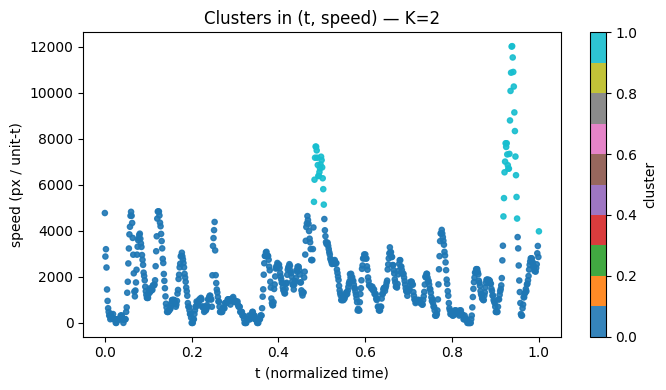

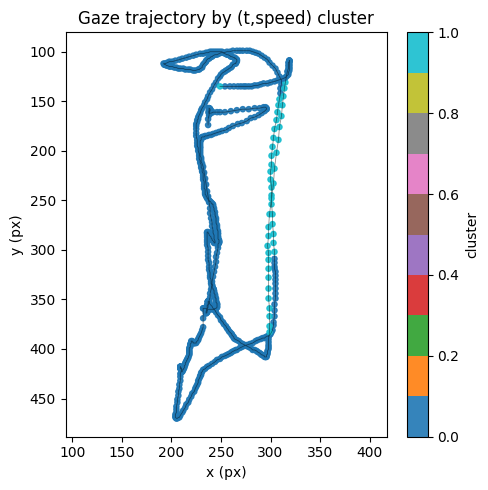

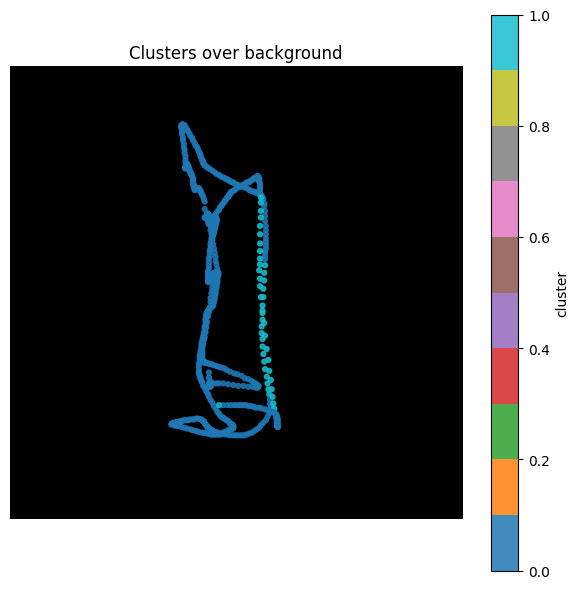

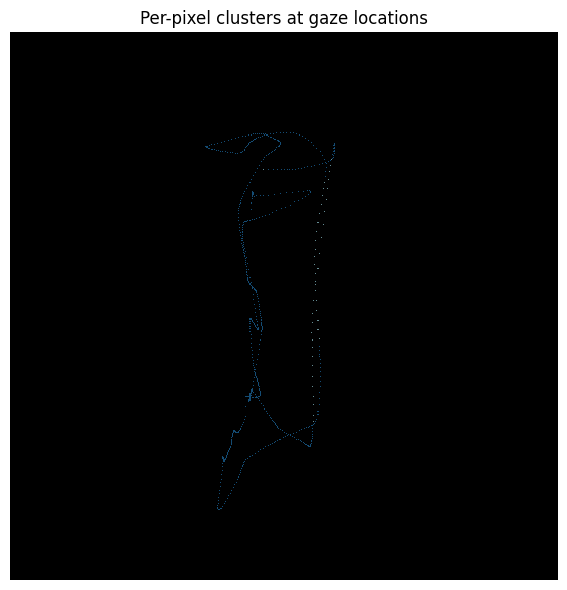

In [ ]:
# List your CSV file paths (strings)
csv_paths = [
    "/content/drive/MyDrive/2025Fall/Thesis/Savoye_Drawings/Oct20_CSV/Savoye_Circulation_GazeCoordinates_group10.csv"
]
file_ds = tf.data.Dataset.from_tensor_slices(csv_paths)

# Map to (x,y,t) ragged + optional xyz_map (dense)
ds = file_ds.map(csv_to_triplets_and_maps, num_parallel_calls=tf.data.AUTOTUNE)

# --- Take one sample and convert Ragged -> NumPy arrays ---
sample = next(iter(ds.take(1)))
xr, yr, tr = sample["x"], sample["y"], sample["t"]  # Ragged 1D
x = xr.numpy(); y = yr.numpy(); t = tr.numpy()      # -> (N,) arrays

# --- Compute speed & cluster ---
x_ord, y_ord, t_ord, v = compute_speed_from_xy_t(x, y, t, smooth_window=5)
K, sil = choose_k_by_silhouette(t_ord, v, k_min=2, k_max=7, random_state=0)
labels, kmeans, _ = cluster_by_time_and_speed(t_ord, v, n_clusters=K, random_state=0)
print(f"Chosen K={K}, silhouette={sil:.3f}, points={len(t_ord)}")

# --- Plots ---
plot_t_vs_speed(t_ord, v, labels, title=f"Clusters in (t, speed) — K={K}")
plot_xy_path_colored(x_ord, y_ord, labels, title="Gaze trajectory by (t,speed) cluster", invert_y=True)

# --- Optional: overlay on an image ---
# If you have a matching background image for this CSV, load it here:
# image = ... # shape (540,540) or (540,540,1), float in [0,1]
# If not, make a blank canvas for demonstration:
image = np.zeros((CANVAS_H, CANVAS_W), dtype=np.float32)

overlay_clusters_on_image(image, x_ord, y_ord, labels, title="Clusters over background", invert_y=True)

# --- Per-pixel label map (cluster id at gaze pixels; −1 elsewhere) ---
labmap = labels_to_map(CANVAS_H, CANVAS_W, x_ord, y_ord, labels, fill_value=-1)
show_label_map_over_image(image, labmap, title="Per-pixel clusters at gaze locations", alpha=0.65)


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# ---------- utilities ----------
def _safe_unique_int(labels):
    labels = np.asarray(labels)
    return np.unique(labels[labels >= 0])

def _join_labels(base_labels, sub_labels, invalid=-1):
    """Combine base cluster ids with per-point sub-group ids.
       If base label is invalid, keep invalid."""
    base_labels = np.asarray(base_labels)
    sub_labels  = np.asarray(sub_labels)
    out = np.full_like(base_labels, fill_value=invalid, dtype=object)
    valid = base_labels >= 0
    # make composite labels like "2_0", "2_1", ...
    out[valid] = np.array([f"{b}_{s}" for b, s in zip(base_labels[valid], sub_labels[valid])], dtype=object)
    return out

# ---------- methods to subdivide by speed ----------
def refine_by_speed_quantiles(v, base_labels, n_bins=3):
    """
    For each base cluster, split speeds into n quantile bins (e.g., tertiles).
    Returns composite string labels: "<base>_<binIdx>"
    """
    v = np.asarray(v, float)
    base_labels = np.asarray(base_labels)
    sub_labels = np.full_like(base_labels, fill_value=-1, dtype=int)
    for b in _safe_unique_int(base_labels):
        idx = np.where(base_labels == b)[0]
        if idx.size < n_bins:
            # too few points; put all in a single bin 0
            sub_labels[idx] = 0
            continue
        # compute bin edges on this cluster's speeds
        qs = np.linspace(0, 1, n_bins+1)
        edges = np.quantile(v[idx], qs)
        # inclusive lower bound, exclusive upper except last
        # to handle ties, add tiny epsilon
        eps = 1e-9
        bins = np.digitize(v[idx] + eps, edges[1:-1], right=False)
        sub_labels[idx] = bins
    return _join_labels(base_labels, sub_labels)

def refine_by_speed_kmeans1d(v, base_labels, k_per_cluster=3, random_state=0):
    """
    For each base cluster, run 1-D k-means on speed to get k_per_cluster subgroups.
    """
    v = np.asarray(v, float)
    base_labels = np.asarray(base_labels)
    sub_labels = np.full_like(base_labels, fill_value=-1, dtype=int)
    for b in _safe_unique_int(base_labels):
        idx = np.where(base_labels == b)[0]
        if idx.size < max(2, k_per_cluster):
            sub_labels[idx] = 0
            continue
        km = KMeans(n_clusters=k_per_cluster, n_init="auto", random_state=random_state)
        sub_labels[idx] = km.fit_predict(v[idx][:, None])
    return _join_labels(base_labels, sub_labels)

def refine_by_speed_gmm1d(v, base_labels, k_min=1, k_max=4, covariance_type="full", random_state=0):
    """
    For each base cluster, fit 1-D GMM with components chosen by BIC in [k_min, k_max].
    """
    v = np.asarray(v, float)
    base_labels = np.asarray(base_labels)
    sub_labels = np.full_like(base_labels, fill_value=-1, dtype=int)
    for b in _safe_unique_int(base_labels):
        idx = np.where(base_labels == b)[0]
        if idx.size < 3:
            sub_labels[idx] = 0
            continue
        best_bic, best_model = np.inf, None
        X = v[idx][:, None]
        # guard against zero-variance edge cases
        if np.allclose(X.std(), 0.0):
            sub_labels[idx] = 0
            continue
        for k in range(k_min, min(k_max, idx.size) + 1):
            try:
                gmm = GaussianMixture(n_components=k, covariance_type=covariance_type,
                                      random_state=random_state)
                gmm.fit(X)
                bic = gmm.bic(X)
                if bic < best_bic:
                    best_bic, best_model = bic, gmm
            except Exception:
                pass
        if best_model is None:
            sub_labels[idx] = 0
        else:
            sub_labels[idx] = best_model.predict(X)
    return _join_labels(base_labels, sub_labels)

# ---------- Dispatcher ----------
def refine_speed_groups(v, base_labels, method="quantile", **kwargs):
    """
    method in {"quantile", "kmeans1d", "gmm1d"}
    kwargs:
      - quantile: n_bins
      - kmeans1d: k_per_cluster, random_state
      - gmm1d: k_min, k_max, covariance_type, random_state
    """
    if method == "quantile":
        n_bins = kwargs.get("n_bins", 3)
        return refine_by_speed_quantiles(v, base_labels, n_bins=n_bins)
    elif method == "kmeans1d":
        return refine_by_speed_kmeans1d(
            v, base_labels,
            k_per_cluster=kwargs.get("k_per_cluster", 3),
            random_state=kwargs.get("random_state", 0)
        )
    elif method == "gmm1d":
        return refine_by_speed_gmm1d(
            v, base_labels,
            k_min=kwargs.get("k_min", 1),
            k_max=kwargs.get("k_max", 4),
            covariance_type=kwargs.get("covariance_type", "full"),
            random_state=kwargs.get("random_state", 0)
        )
    else:
        raise ValueError(f"Unknown method: {method}")


In [ ]:
# A) quantile tertiles inside each cluster
refined_labels_q = refine_speed_groups(v, labels, method="quantile", n_bins=3)

# B) k-means 1D (e.g., 3 subgroups per base cluster)
refined_labels_k = refine_speed_groups(v, labels, method="kmeans1d", k_per_cluster=3, random_state=0)

# C) GMM 1D with BIC to pick 1..4 components per base cluster
refined_labels_g = refine_speed_groups(v, labels, method="gmm1d", k_min=1, k_max=4, random_state=0)


In [ ]:
import matplotlib.pyplot as plt

def plot_t_speed_refined(t, v, refined_labels, title="Refined clusters (t, speed)"):
    # color per composite string label
    uniq = np.unique(refined_labels)
    cmap = plt.cm.get_cmap("tab20", len(uniq))
    plt.figure(figsize=(7,4))
    for i, u in enumerate(uniq):
        m = refined_labels == u
        plt.scatter(t[m], v[m], s=14, alpha=0.9, color=cmap(i), label=str(u))
    plt.xlabel("t"); plt.ylabel("speed")
    plt.title(title); plt.legend(fontsize=8, ncol=2)
    plt.tight_layout(); plt.show()

def plot_xy_refined(x, y, refined_labels, title="XY trajectory by refined groups", invert_y=True):
    uniq = np.unique(refined_labels)
    cmap = plt.cm.get_cmap("tab20", len(uniq))
    plt.figure(figsize=(5,5))
    for i, u in enumerate(uniq):
        m = refined_labels == u
        plt.scatter(x[m], y[m], s=12, alpha=0.9, color=cmap(i), label=str(u))
    plt.plot(x, y, lw=0.6, alpha=0.4, color="k")
    if invert_y: plt.gca().invert_yaxis()
    plt.axis("equal"); plt.xlabel("x"); plt.ylabel("y")
    plt.title(title); plt.legend(fontsize=8, ncol=2)
    plt.tight_layout(); plt.show()


/tmp/ipython-input-2080311467.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


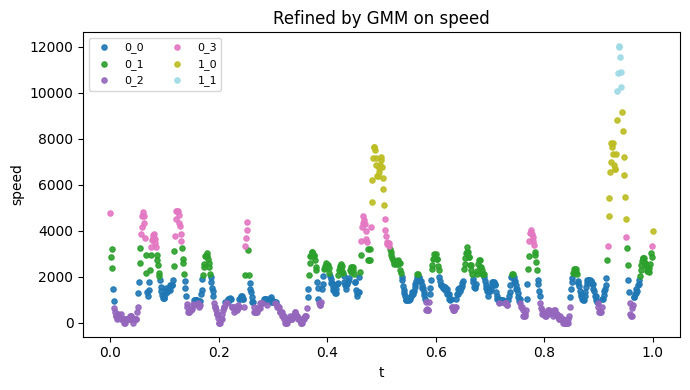

/tmp/ipython-input-2080311467.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


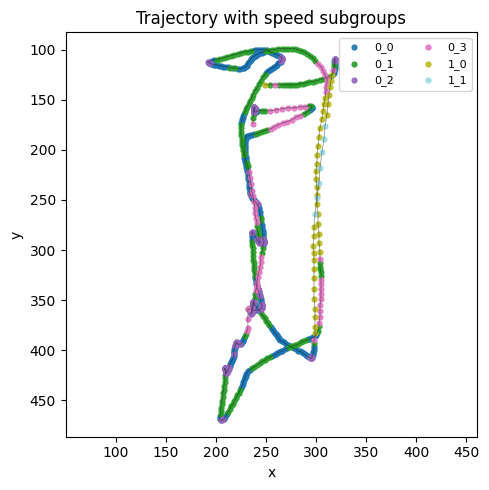

In [ ]:
plot_t_speed_refined(t_ord, v, refined_labels_g, title="Refined by GMM on speed")
plot_xy_refined(x_ord, y_ord, refined_labels_g, title="Trajectory with speed subgroups")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_each_speed_group(x, y, t, v, refined_labels, image=None, invert_y=True):
    """
    Creates separate XY trajectory plots for each unique speed subgroup.
    Arguments:
      x, y, t, v          : arrays (same length)
      refined_labels      : composite string labels, e.g. "2_0"
      image               : optional background (H,W) or (H,W,3)
      invert_y            : flip Y to match screen coords
    """
    uniq = np.unique(refined_labels)
    cmap = plt.cm.get_cmap("tab20", len(uniq))

    for i, u in enumerate(uniq):
        mask = refined_labels == u
        if not np.any(mask):
            continue

        plt.figure(figsize=(6,6))
        if image is not None:
            plt.imshow(image, cmap="gray", interpolation="nearest")

        plt.scatter(x[mask], y[mask], s=20, alpha=0.9, color=cmap(i))
        plt.plot(x, y, lw=0.4, color="k", alpha=0.4)
        if invert_y:
            plt.gca().invert_yaxis()

        plt.axis("equal")
        plt.axis("off")
        plt.title(f"Speed subgroup: {u}\n(points={mask.sum()})")
        plt.tight_layout()
        plt.show()

def visualize_each_speed_group_in_t_speed(t, v, refined_labels):
    """
    Shows (t, speed) scatter for each subgroup separately.
    """
    uniq = np.unique(refined_labels)
    cmap = plt.cm.get_cmap("tab20", len(uniq))

    for i, u in enumerate(uniq):
        mask = refined_labels == u
        if not np.any(mask):
            continue

        plt.figure(figsize=(6,4))
        plt.scatter(t[mask], v[mask], s=20, color=cmap(i), alpha=0.9)
        plt.xlabel("t (normalized time)")
        plt.ylabel("speed (px / unit-t)")
        plt.title(f"Speed subgroup: {u}\n(points={mask.sum()})")
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()


/tmp/ipython-input-1174664917.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


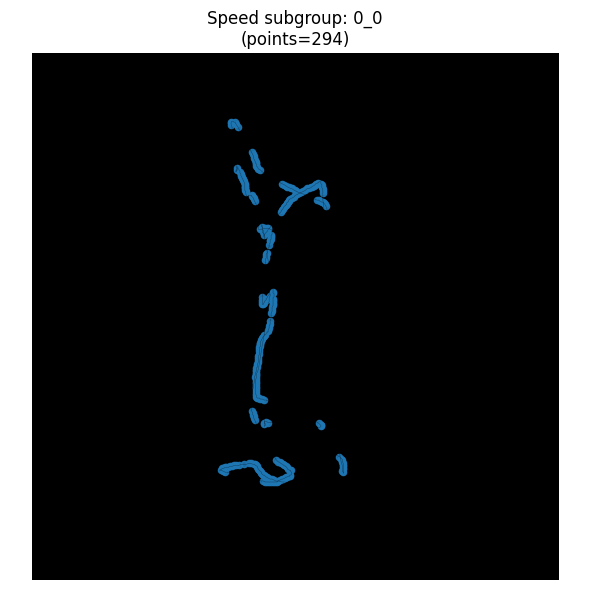

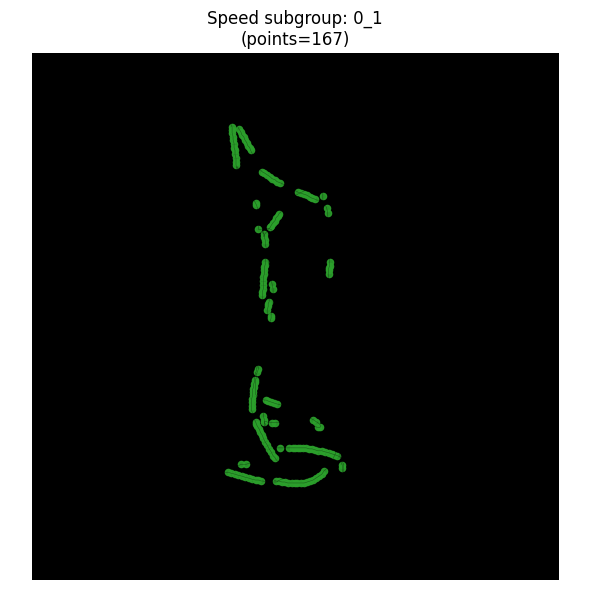

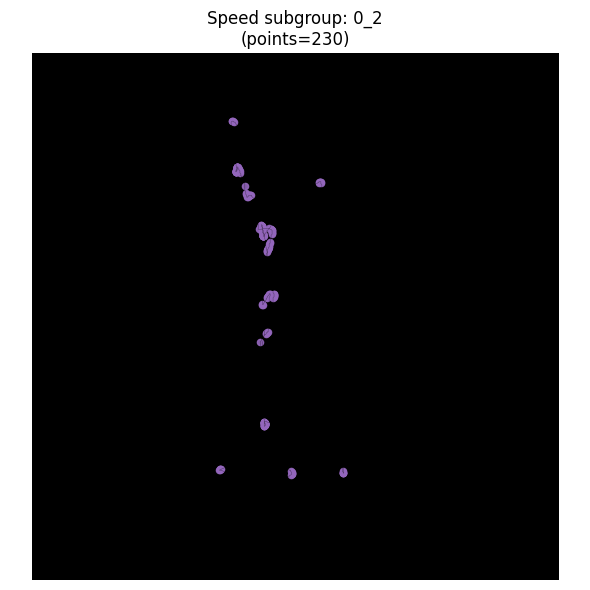

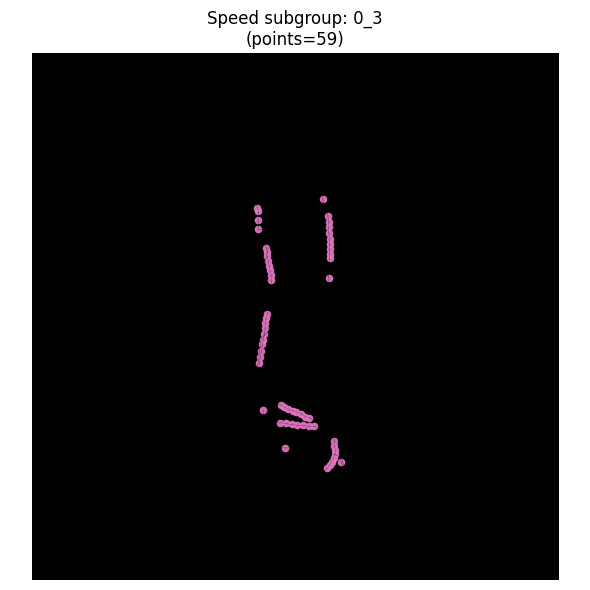

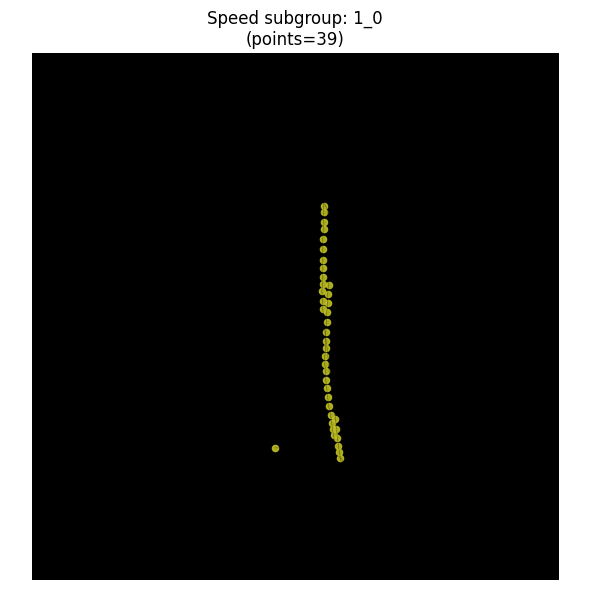

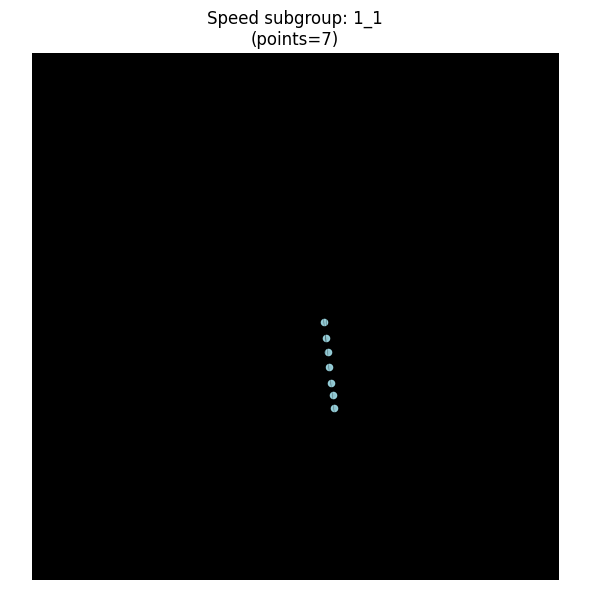

/tmp/ipython-input-1174664917.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


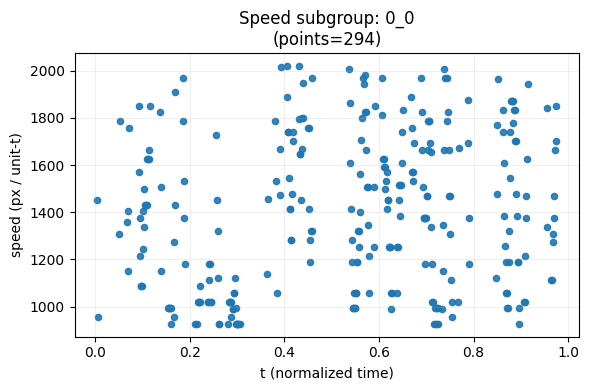

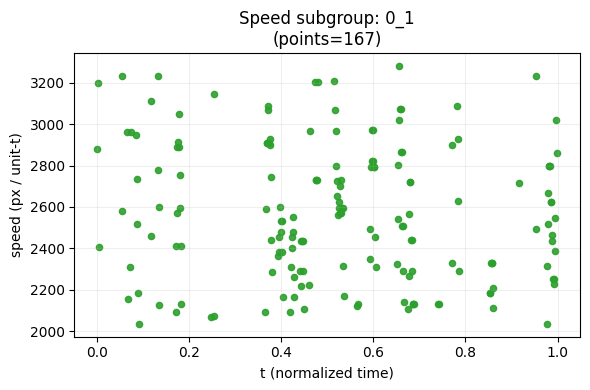

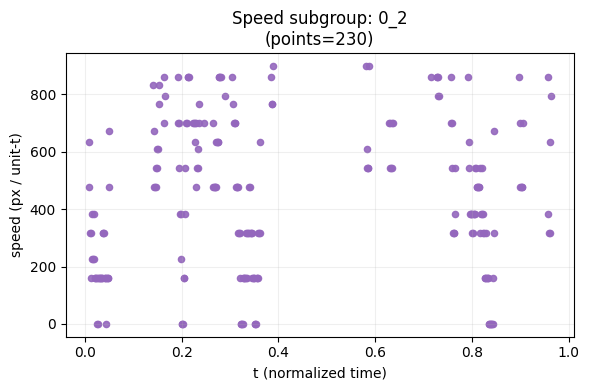

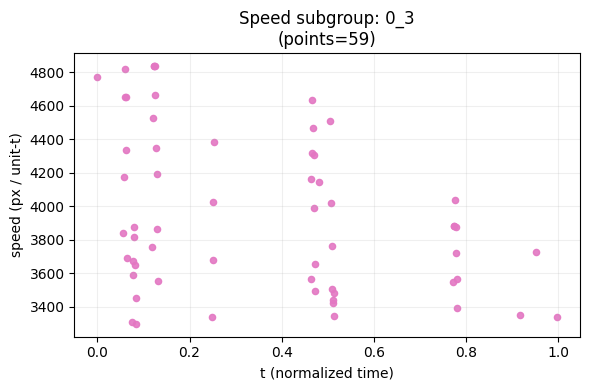

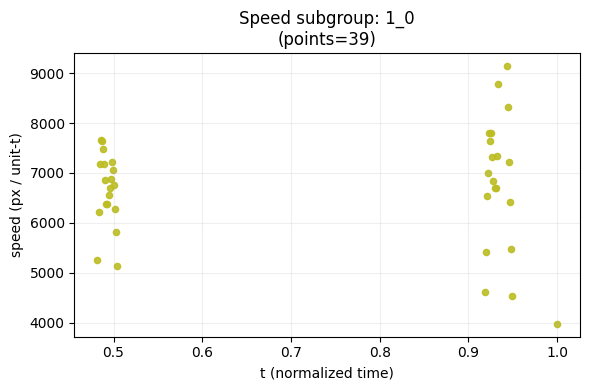

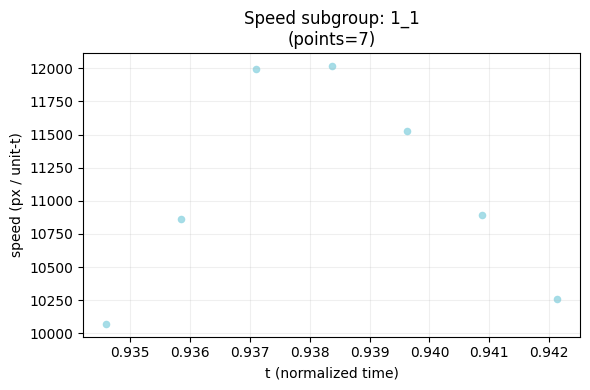

In [ ]:
# After your refinement step
refined_labels = refined_labels_g  # or _q or _k

# (Optional) load background
# image = plt.imread("/path/to/stimulus.png")
image = np.zeros((540,540))  # blank example

# Plot each subgroup in XY space
visualize_each_speed_group(x_ord, y_ord, t_ord, v, refined_labels, image=image, invert_y=True)

# Plot each subgroup in (t, speed) space
visualize_each_speed_group_in_t_speed(t_ord, v, refined_labels)

In [ ]:


def visualize_each_speed_group_with_time(x, y, t, refined_labels, image=None, invert_y=True):
    """
    One XY plot per speed subgroup.
    Point color encodes time weight t in [0,1].
    """
    uniq = np.unique(refined_labels)
    for u in uniq:
        m = (refined_labels == u)
        if not np.any(m):
            continue

        plt.figure(figsize=(6,6))
        if image is not None:
            plt.imshow(image, cmap="gray", interpolation="nearest")
        sc = plt.scatter(x[m], y[m], c=t[m], s=18, cmap="viridis", vmin=0.0, vmax=1.0)
        plt.plot(x, y, lw=0.5, alpha=0.35, color="k")   # thin path overlay
        if invert_y:
            plt.gca().invert_yaxis()
        plt.axis("equal"); plt.axis("off")
        cb = plt.colorbar(sc, fraction=0.046, pad=0.04)
        cb.set_label("time weight t")
        plt.title(f"Subgroup {u} — XY colored by t (n={m.sum()})")
        plt.tight_layout(); plt.show()


In [ ]:
def visualize_each_speed_group_in_t_speed_with_time(t, v, refined_labels):
    uniq = np.unique(refined_labels)
    for u in uniq:
        m = (refined_labels == u)
        if not np.any(m):
            continue
        plt.figure(figsize=(6,4))
        sc = plt.scatter(t[m], v[m], c=t[m], s=18, cmap="viridis", vmin=0.0, vmax=1.0)
        plt.xlabel("t (normalized time)"); plt.ylabel("speed (px / unit-t)")
        plt.title(f"Subgroup {u} — (t, speed) colored by t (n={m.sum()})")
        cb = plt.colorbar(sc, fraction=0.046, pad=0.04)
        cb.set_label("time weight t")
        plt.grid(alpha=0.2)
        plt.tight_layout(); plt.show()


In [ ]:
def subgroup_time_ribbon(t, refined_labels, n_bins=20):
    """
    Stacked proportion over time bins: for each time bin, what fraction of points
    belong to each subgroup?
    """
    t = np.asarray(t)
    uniq = np.unique(refined_labels)
    bins = np.linspace(0, 1, n_bins+1)
    mids = 0.5*(bins[:-1] + bins[1:])
    counts = np.zeros((len(uniq), n_bins), dtype=float)

    # count per subgroup per bin
    for i, u in enumerate(uniq):
        m = (refined_labels == u)
        if not np.any(m): continue
        hist, _ = np.histogram(t[m], bins=bins)
        counts[i] = hist

    # convert to proportions per bin
    colsum = counts.sum(axis=0, keepdims=True) + 1e-9
    props = counts / colsum

    # plot stacked area
    plt.figure(figsize=(8,4))
    bottoms = np.zeros(n_bins)
    cmap = plt.cm.get_cmap("tab20", len(uniq))
    for i, u in enumerate(uniq):
        plt.fill_between(mids, bottoms, bottoms+props[i],
                         color=cmap(i), alpha=0.9, label=str(u), step="mid")
        bottoms += props[i]
    plt.xlim(0,1); plt.ylim(0,1.0)
    plt.xlabel("t (normalized time)"); plt.ylabel("proportion per time bin")
    plt.title("Subgroup timeline (proportion vs. t)")
    plt.legend(ncol=min(3, len(uniq)), fontsize=8, frameon=True)
    plt.grid(alpha=0.2)
    plt.tight_layout(); plt.show()


In [ ]:
def subgroup_time_heatmap(t, refined_labels, n_bins=30, normalize="row"):
    """
    Heatmap of subgroup vs. time bins.
    normalize: None | 'row' (per subgroup) | 'col' (per time bin)
    """
    t = np.asarray(t)
    uniq = np.unique(refined_labels)
    bins = np.linspace(0, 1, n_bins+1)
    M = np.zeros((len(uniq), n_bins), dtype=float)

    for i, u in enumerate(uniq):
        m = (refined_labels == u)
        hist, _ = np.histogram(t[m], bins=bins)
        M[i] = hist

    if normalize == "row":
        M = M / (M.sum(axis=1, keepdims=True) + 1e-9)
    elif normalize == "col":
        M = M / (M.sum(axis=0, keepdims=True) + 1e-9)

    plt.figure(figsize=(max(8, n_bins/3), 0.5*len(uniq) + 2))
    im = plt.imshow(M, aspect="auto", cmap="viridis", interpolation="nearest",
                    extent=[0,1, -0.5, len(uniq)-0.5], origin="lower")
    plt.yticks(range(len(uniq)), [str(u) for u in uniq])
    plt.xlabel("t (normalized time)"); plt.ylabel("subgroup")
    cb = plt.colorbar(im); cb.set_label("proportion" if normalize else "count")
    plt.title("Subgroup × time heatmap")
    plt.tight_layout(); plt.show()


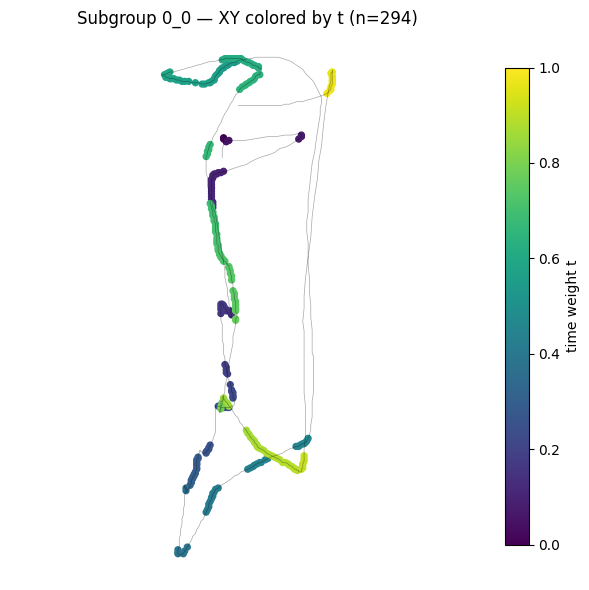

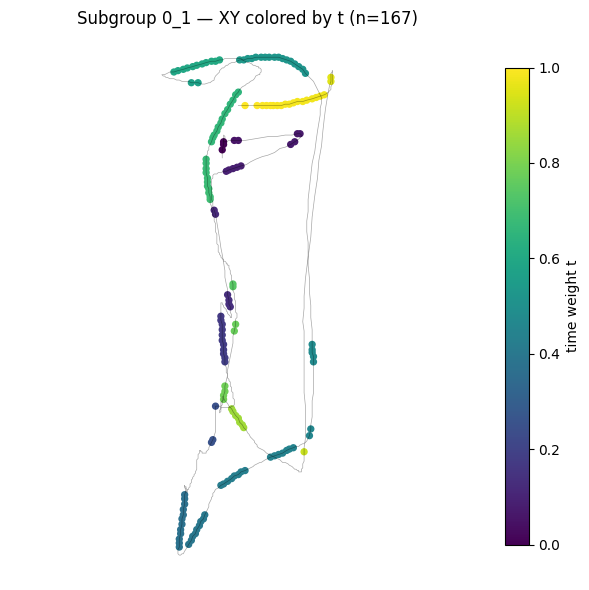

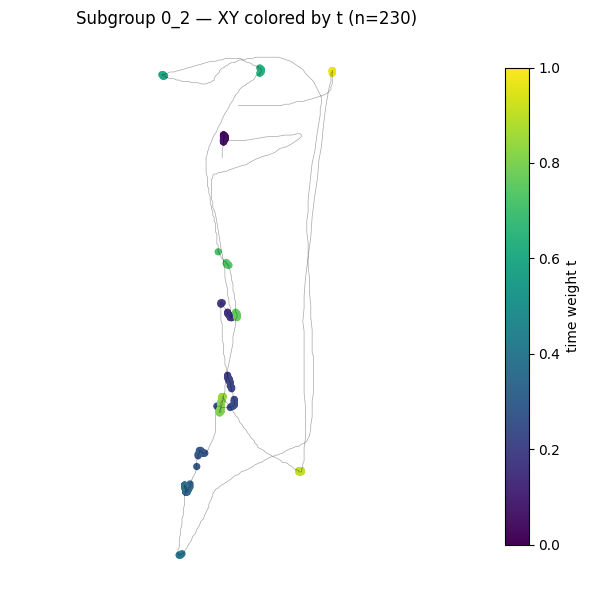

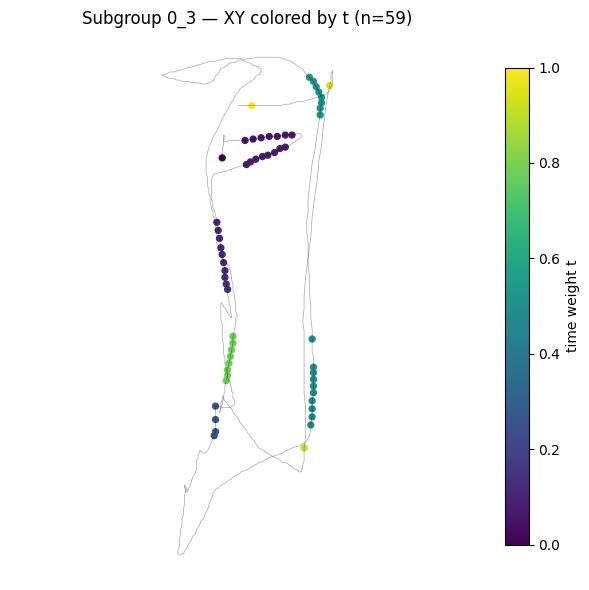

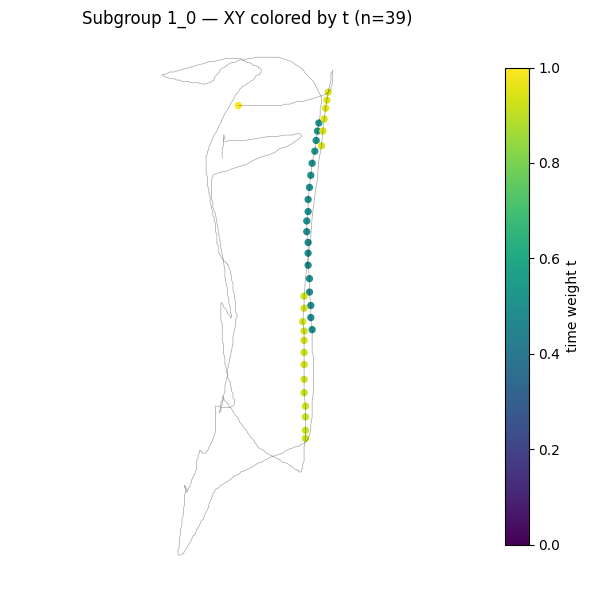

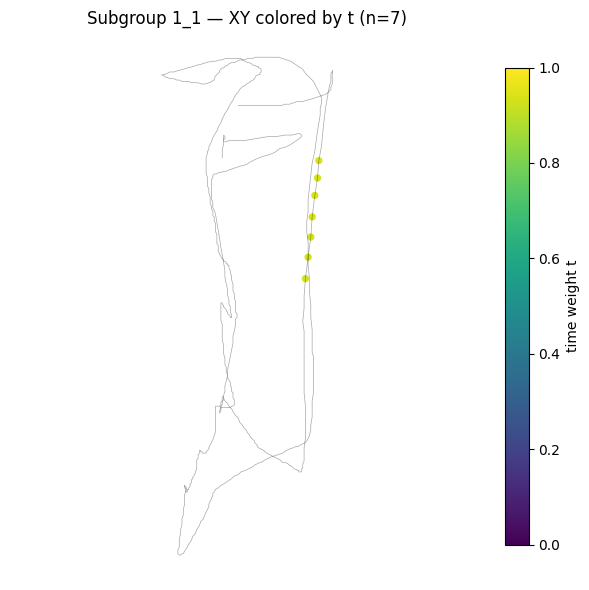

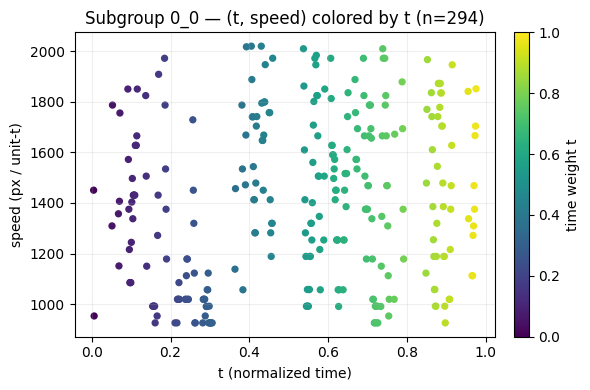

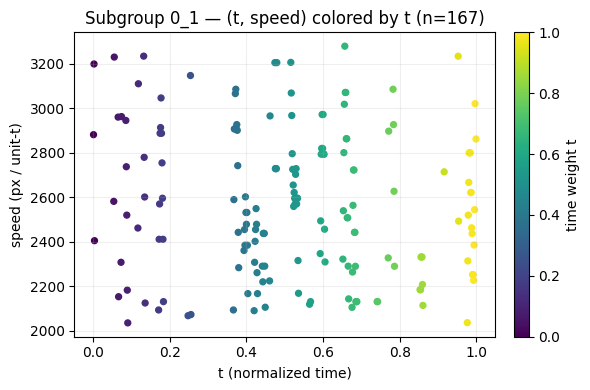

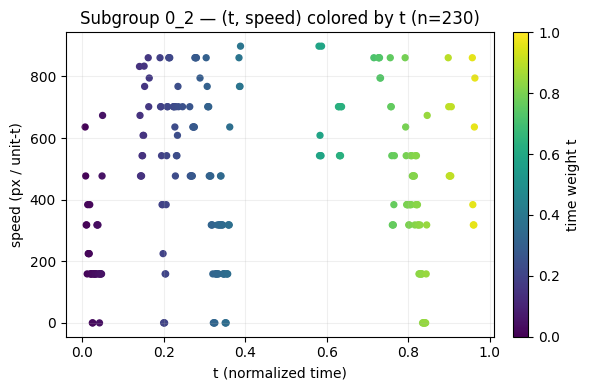

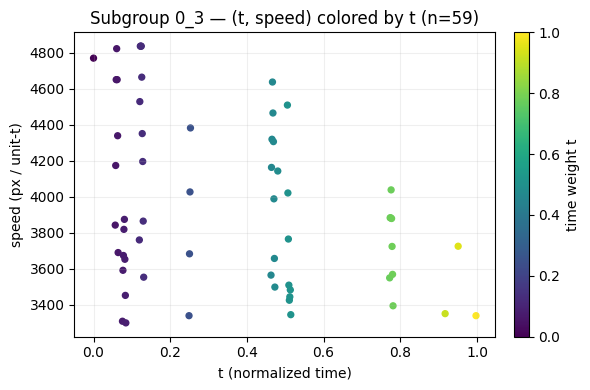

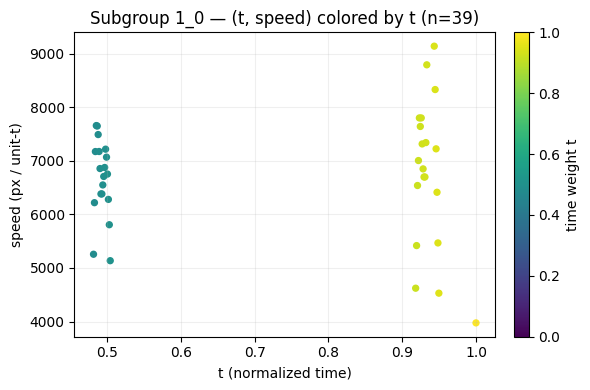

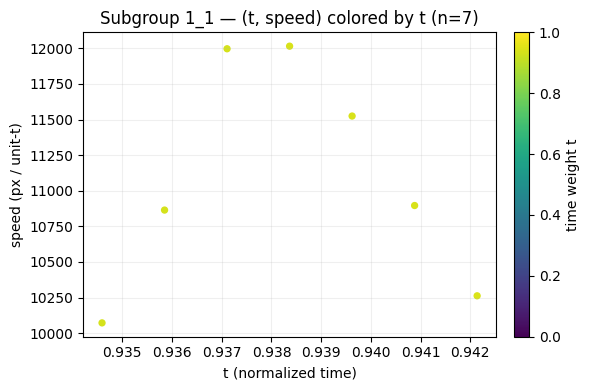

/tmp/ipython-input-607783522.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


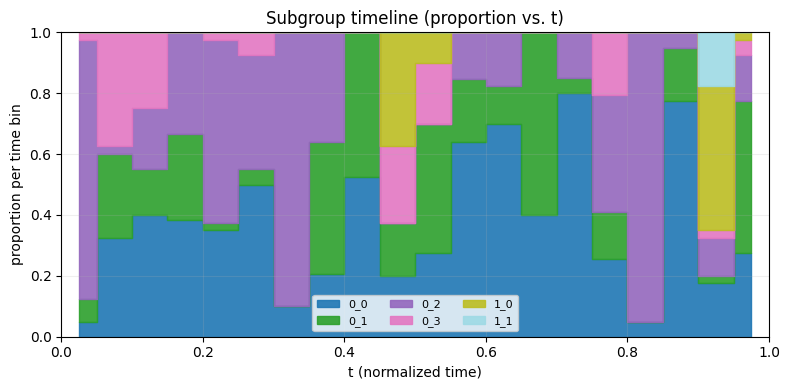

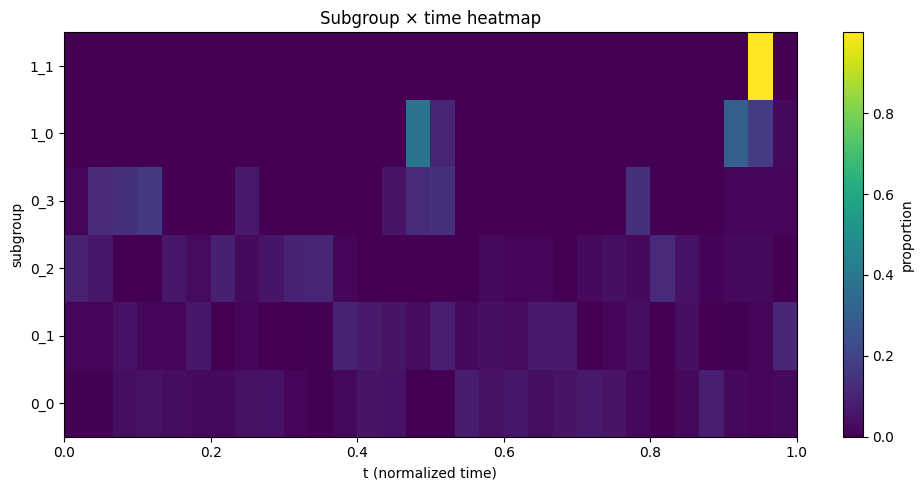

In [ ]:
# After you compute x_ord, y_ord, t_ord, v, and refined_labels (strings)
# Optional background image:
# image = ...  # (540,540) in [0,1] or None
image = None

# 1) XY per subgroup with color=t
visualize_each_speed_group_with_time(x_ord, y_ord, t_ord, refined_labels, image=image, invert_y=True)

# 2) (t, speed) per subgroup with color=t
visualize_each_speed_group_in_t_speed_with_time(t_ord, v, refined_labels)

# 3) Stacked timeline of subgroup proportions over t
subgroup_time_ribbon(t_ord, refined_labels, n_bins=20)

# 4) Heatmap (use 'row' to see each subgroup’s temporal profile normalized to 1)
subgroup_time_heatmap(t_ord, refined_labels, n_bins=30, normalize="row")


## Potential uses of Eye-movement Segmentation
reweight layer for encoder.
reweight latent into latent "retro-spective" (I am in a loop!)